In [53]:
import os
import time
import random
import platform
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

# 한글 문제
from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 17,8

import warnings
warnings.filterwarnings(action='ignore')

# 데이터 전처리

#### ECLO만 뽑아내기위한 작업

In [81]:
# ECLO만 뽑아내기 위한 train 호출. (전처리 안된 원본데이터)
train = pd.read_csv('./open/train.csv')
# 전국데이터 호출. (전처리 안된 원본데이터)
countrywide = pd.read_csv('./open/external_open/countrywide_accident.csv')
#전국 데이터와 대구 데이터들의 eclo만 뽑아낸것. 총 row 642,384개
eclo = pd.concat([train['ECLO'], countrywide['ECLO']], sort=False)

#### 요일, 기상, 노면, 유형, 연, 월, 시, 도시, 도로형태로 전처리된 데이터

In [82]:
countrywide_df = pd.read_csv('./open/countrywide_processed.csv')
train_df = pd.read_csv('./open/train_processed.csv')
test_df = pd.read_csv('./open/test_processed.csv')

#### 모든 컬럼 일괄적으로 원핫인 하기위해 데이터타입 통일

In [83]:
# 문자열로 변환하는 함수 정의
def convert_to_str(df, columns):
    for col in columns:
        df[col] = df[col].astype(str)
    return df
# train_df, test_df, countrywide에 대한 문자열 변환
columns_to_convert = ['연', '월', '시간']
train_df = convert_to_str(train_df, columns_to_convert)
test_df = convert_to_str(test_df, columns_to_convert)
countrywide_df = convert_to_str(countrywide_df, columns_to_convert)

#### data라는 변수에 모두 넣어서 한번에 원핫인코딩

In [86]:
data = pd.get_dummies(data)

Index(['요일_금요일', '요일_목요일', '요일_수요일', '요일_월요일', '요일_일요일', '요일_토요일', '요일_화요일',
       '기상상태_기타', '기상상태_눈', '기상상태_맑음', '기상상태_비', '기상상태_안개', '기상상태_흐림',
       '노면상태_건조', '노면상태_기타', '노면상태_서리/결빙', '노면상태_적설', '노면상태_젖음/습기', '노면상태_침수',
       '노면상태_해빙', '사고유형_차대사람', '사고유형_차대차', '사고유형_차량단독', '사고유형_철길건널목', '연_2019',
       '연_2020', '연_2021', '연_2022', '월_1', '월_10', '월_11', '월_12', '월_2',
       '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', '월_9', '시간_0', '시간_1',
       '시간_10', '시간_11', '시간_12', '시간_13', '시간_14', '시간_15', '시간_16', '시간_17',
       '시간_18', '시간_19', '시간_2', '시간_20', '시간_21', '시간_22', '시간_23', '시간_3',
       '시간_4', '시간_5', '시간_6', '시간_7', '시간_8', '시간_9', '도시_강원도', '도시_경기도',
       '도시_경상남도', '도시_경상북도', '도시_광주광역시', '도시_대구광역시', '도시_대전광역시', '도시_미분류',
       '도시_부산광역시', '도시_서울특별시', '도시_세종특별자치시', '도시_울산광역시', '도시_인천광역시', '도시_전라남도',
       '도시_전라북도', '도시_제주특별자치도', '도시_충청남도', '도시_충청북도', '도로형태1_교차로', '도로형태1_기타',
       '도로형태1_단일로', '도로형태1_미분류', '도로형태1_주차장', '도로형태2_고가도로위', '도로형태2_교량',
       '

In [75]:
#데이터 3개 합쳐
data = pd.concat([train_df, countrywide_df, test_df], sort=False)
data = pd.get_dummies(data)

#### 트레인과 전국데이터 만큼 덜어내기

In [32]:
sum_train_ctw_len = len(train) + len(countrywide)
train_enco = data[:sum_train_ctw_len]
test_enco = data[sum_train_ctw_len:]

- 참고자료 : Catboost의 파라미터 설명
    - iterations:트리의 수 또는 라운드 수
    - depth:각 트리의 최대 깊이
    - learning_rate: 각 트리의 기여도
    - eval_set: 검증 세트를 지정
    - early_stopping_rounds: 검증 세트에서 성능이 향상되지 않으면 얼마나 많은 라운드를 기다릴지를 지정
    - verbose: 학습 과정을 출력할 때의 상세도를 조절(안중요)

# Case1-catboost - 로그변환X, 전국데이터X

- 코드생략
RMSLE: 0.46122

# Case2-catboost - 로그변환O, 전국데이터X

- 코드생략
RMSLE: 0.44702

# Case3-catboost - 로그변환X, 전국데이터O

RMSLE: 0.45516

In [33]:
# X_train은 대구+전국 데이터 원핫인코딩 된 데이터(642,384개), y_train은 eclo만(642,384개) 뽑아낸것. 
X_train = train_enco
y_train = eclo

In [45]:
# X_train은 대구+전국 데이터 원핫인코딩 된 데이터(642,384개), y_train은 eclo만(642,384개) 뽑아낸것. 
X_train = train_enco
y_train = eclo

# train 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# CatBoost 모델 생성, 학습, 예측 iterations=500, depth=10
model_cbr = CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.05)
model_cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=100)
predictions_cbr = model_cbr.predict(X_valid)

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_true) - np.log1p(y_pred))))

# 테스트 데이터의 실제 값
y_true = y_valid
# 테스트 데이터의 예측 값
y_pred = predictions_cbr

# RMSLE
rmsle_value = rmsle(y_true, y_pred)
print("RMSLE:", rmsle_value)

0:	learn: 3.5999467	test: 3.5385127	best: 3.5385127 (0)	total: 49.4ms	remaining: 49.4s
100:	learn: 3.5301334	test: 3.4797110	best: 3.4797110 (100)	total: 4.73s	remaining: 42.1s
200:	learn: 3.5148898	test: 3.4758877	best: 3.4758877 (200)	total: 9.36s	remaining: 37.2s
300:	learn: 3.5013647	test: 3.4744999	best: 3.4744733 (292)	total: 13.8s	remaining: 32.1s
400:	learn: 3.4900902	test: 3.4740658	best: 3.4740646 (397)	total: 18.2s	remaining: 27.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.474022122
bestIteration = 412

Shrink model to first 413 iterations.
RMSLE: 0.4551609149868639


# Case4-catboost - 로그변환O, 전국데이터O (Best)

RMSLE: 0.44126

In [37]:
# X_train, y_train 다시 초기화
X_train = train_enco
y_train = np.log2(eclo)

# 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# CatBoost 시간 측정 시작
start_time = time.time()

# model_cbr을 로그로 학습시킨 모델로 변경하기
model_cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=100)

# 학습 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"모델 학습 시간: {elapsed_time} 초")

# 테스트 데이터 예측
predictions_cbr = model_cbr.predict(X_valid)
# 테스트 데이터의 실제 값
y_true = y_valid
# 테스트 데이터의 예측 값
y_pred = predictions_cbr

# 로그상태에서 RMSLE 계산. 하지만 제출할때는 eclo가 로그가 아닌 상태에서 예측해야하니 이결과는 참고용으로..
rmsle_value = rmsle(y_true, y_pred)
print("로그 역변환 전 RMSLE:", rmsle_value)
# 로그 역변환 후 RMSLE 계산
predicted_eclo_back = np.exp2(predictions_cbr)
y_true_back = np.exp2(y_true)
rmsle_value_back = rmsle(y_true_back, predicted_eclo_back)
print("로그역변환 후 최종 RMSLE:", rmsle_value_back)


# R2 계산
r2_value = r2_score(y_true, y_pred)
print("R2 Score:", r2_value)

# 로그 역변환 후 R2 계산
r2_value_back = r2_score(y_true_back, predicted_eclo_back)
print("로그역변환 후 최종 R2 Score:", r2_value_back)


0:	learn: 0.8139916	test: 0.8129800	best: 0.8129800 (0)	total: 37.3ms	remaining: 18.6s
100:	learn: 0.8001056	test: 0.7996463	best: 0.7996463 (100)	total: 2.82s	remaining: 11.1s
200:	learn: 0.7987322	test: 0.7985237	best: 0.7985237 (200)	total: 5.61s	remaining: 8.34s
300:	learn: 0.7978903	test: 0.7980541	best: 0.7980541 (300)	total: 8.45s	remaining: 5.58s
400:	learn: 0.7971293	test: 0.7978210	best: 0.7978208 (398)	total: 11.2s	remaining: 2.76s
499:	learn: 0.7965619	test: 0.7976994	best: 0.7976980 (498)	total: 13.7s	remaining: 0us

bestTest = 0.7976980077
bestIteration = 498

Shrink model to first 499 iterations.
모델 학습 시간: 31.938014030456543 초
로그 역변환 전 RMSLE: 0.30750030038755344
로그역변환 후 최종 RMSLE: 0.4412582847654493
R2 Score: 0.03968057958152582
로그역변환 후 최종 R2 Score: -0.011950892701581672


In [12]:
# X_train, y_train 다시 초기화
X_train = train_enco
y_train = np.log2(eclo)

# 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# CatBoost 시간 측정 시작
start_time = time.time()

# model_cbr을 로그로 학습시킨 모델로 변경하기
model_cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=100)

# 학습 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time
print(f"모델 학습 시간: {elapsed_time} 초")

# 테스트 데이터 예측
predictions_cbr = model_cbr.predict(X_valid)
# 테스트 데이터의 실제 값
y_true = y_valid
# 테스트 데이터의 예측 값
y_pred = predictions_cbr

# 로그상태에서 RMSLE 계산. 하지만 제출할때는 eclo가 로그가 아닌 상태에서 예측해야하니 이결과는 참고용으로..
rmsle_value = rmsle(y_true, y_pred)
print("로그 역변환 전 RMSLE:", rmsle_value)
# 로그 역변환 후 RMSLE 계산
predicted_eclo_back = np.exp2(predictions_cbr)
y_true_back = np.exp2(y_true)
rmsle_value_back = rmsle(y_true_back, predicted_eclo_back)
print("로그역변환 후 최종 RMSLE:", rmsle_value_back)


# R2 계산
r2_value = r2_score(y_true, y_pred)
print("R2 Score:", r2_value)

# 로그 역변환 후 R2 계산
r2_value_back = r2_score(y_true_back, predicted_eclo_back)
print("로그역변환 후 최종 R2 Score:", r2_value_back)


0:	learn: 0.8161376	total: 19.5ms	remaining: 1.94s
1:	learn: 0.8159220	total: 36.8ms	remaining: 1.8s
2:	learn: 0.8157095	total: 53.5ms	remaining: 1.73s
3:	learn: 0.8155021	total: 70.2ms	remaining: 1.68s
4:	learn: 0.8152976	total: 87.3ms	remaining: 1.66s
5:	learn: 0.8150990	total: 105ms	remaining: 1.64s
6:	learn: 0.8149087	total: 121ms	remaining: 1.61s
7:	learn: 0.8147147	total: 139ms	remaining: 1.6s
8:	learn: 0.8145257	total: 156ms	remaining: 1.57s
9:	learn: 0.8143372	total: 174ms	remaining: 1.57s
10:	learn: 0.8141661	total: 190ms	remaining: 1.54s
11:	learn: 0.8139863	total: 209ms	remaining: 1.53s
12:	learn: 0.8138098	total: 228ms	remaining: 1.53s
13:	learn: 0.8136376	total: 247ms	remaining: 1.52s
14:	learn: 0.8134709	total: 264ms	remaining: 1.49s
15:	learn: 0.8133170	total: 280ms	remaining: 1.47s
16:	learn: 0.8131567	total: 298ms	remaining: 1.45s
17:	learn: 0.8129967	total: 316ms	remaining: 1.44s
18:	learn: 0.8128415	total: 332ms	remaining: 1.42s
19:	learn: 0.8126872	total: 348ms	rema

70:	learn: 0.8066356	total: 1.31s	remaining: 537ms
71:	learn: 0.8065736	total: 1.33s	remaining: 518ms
72:	learn: 0.8065128	total: 1.35s	remaining: 499ms
73:	learn: 0.8064546	total: 1.37s	remaining: 481ms
74:	learn: 0.8063975	total: 1.39s	remaining: 462ms
75:	learn: 0.8063407	total: 1.4s	remaining: 443ms
76:	learn: 0.8062767	total: 1.42s	remaining: 425ms
77:	learn: 0.8062186	total: 1.44s	remaining: 406ms
78:	learn: 0.8061626	total: 1.46s	remaining: 388ms
79:	learn: 0.8061029	total: 1.48s	remaining: 370ms
80:	learn: 0.8060531	total: 1.5s	remaining: 351ms
81:	learn: 0.8059933	total: 1.52s	remaining: 333ms
82:	learn: 0.8059418	total: 1.53s	remaining: 315ms
83:	learn: 0.8058911	total: 1.55s	remaining: 296ms
84:	learn: 0.8058410	total: 1.57s	remaining: 278ms
85:	learn: 0.8057956	total: 1.59s	remaining: 259ms
86:	learn: 0.8057372	total: 1.61s	remaining: 241ms
87:	learn: 0.8056836	total: 1.63s	remaining: 222ms
88:	learn: 0.8056284	total: 1.65s	remaining: 204ms
89:	learn: 0.8055778	total: 1.67s

36:	learn: 0.8039185	total: 665ms	remaining: 1.13s
37:	learn: 0.8038276	total: 682ms	remaining: 1.11s
38:	learn: 0.8037489	total: 701ms	remaining: 1.1s
39:	learn: 0.8036546	total: 721ms	remaining: 1.08s
40:	learn: 0.8035821	total: 742ms	remaining: 1.07s
41:	learn: 0.8035025	total: 762ms	remaining: 1.05s
42:	learn: 0.8034223	total: 783ms	remaining: 1.04s
43:	learn: 0.8033654	total: 804ms	remaining: 1.02s
44:	learn: 0.8032986	total: 824ms	remaining: 1.01s
45:	learn: 0.8032217	total: 842ms	remaining: 988ms
46:	learn: 0.8031368	total: 864ms	remaining: 974ms
47:	learn: 0.8030745	total: 886ms	remaining: 960ms
48:	learn: 0.8030164	total: 906ms	remaining: 943ms
49:	learn: 0.8029677	total: 924ms	remaining: 924ms
50:	learn: 0.8029054	total: 944ms	remaining: 907ms
51:	learn: 0.8028397	total: 961ms	remaining: 887ms
52:	learn: 0.8027923	total: 982ms	remaining: 871ms
53:	learn: 0.8027256	total: 1s	remaining: 854ms
54:	learn: 0.8026812	total: 1.02s	remaining: 835ms
55:	learn: 0.8026257	total: 1.04s	r

0:	learn: 0.8124160	total: 20.8ms	remaining: 2.06s
1:	learn: 0.8114305	total: 40.6ms	remaining: 1.99s
2:	learn: 0.8105693	total: 58.9ms	remaining: 1.9s
3:	learn: 0.8098161	total: 75.9ms	remaining: 1.82s
4:	learn: 0.8090662	total: 93.6ms	remaining: 1.78s
5:	learn: 0.8084173	total: 111ms	remaining: 1.74s
6:	learn: 0.8078078	total: 128ms	remaining: 1.7s
7:	learn: 0.8072329	total: 145ms	remaining: 1.67s
8:	learn: 0.8067242	total: 164ms	remaining: 1.66s
9:	learn: 0.8062702	total: 180ms	remaining: 1.62s
10:	learn: 0.8058555	total: 197ms	remaining: 1.59s
11:	learn: 0.8054497	total: 215ms	remaining: 1.58s
12:	learn: 0.8051161	total: 236ms	remaining: 1.58s
13:	learn: 0.8047568	total: 256ms	remaining: 1.57s
14:	learn: 0.8044537	total: 272ms	remaining: 1.54s
15:	learn: 0.8041963	total: 291ms	remaining: 1.53s
16:	learn: 0.8039624	total: 310ms	remaining: 1.51s
17:	learn: 0.8037321	total: 329ms	remaining: 1.5s
18:	learn: 0.8035149	total: 347ms	remaining: 1.48s
19:	learn: 0.8033068	total: 365ms	remai

71:	learn: 0.8003886	total: 1.31s	remaining: 510ms
72:	learn: 0.8003597	total: 1.33s	remaining: 493ms
73:	learn: 0.8003363	total: 1.35s	remaining: 475ms
74:	learn: 0.8003006	total: 1.37s	remaining: 457ms
75:	learn: 0.8002762	total: 1.39s	remaining: 440ms
76:	learn: 0.8002418	total: 1.41s	remaining: 421ms
77:	learn: 0.8002147	total: 1.43s	remaining: 402ms
78:	learn: 0.8001868	total: 1.45s	remaining: 385ms
79:	learn: 0.8001608	total: 1.47s	remaining: 367ms
80:	learn: 0.8001353	total: 1.49s	remaining: 350ms
81:	learn: 0.8000999	total: 1.51s	remaining: 331ms
82:	learn: 0.8000782	total: 1.53s	remaining: 313ms
83:	learn: 0.8000456	total: 1.55s	remaining: 295ms
84:	learn: 0.8000171	total: 1.56s	remaining: 276ms
85:	learn: 0.7999978	total: 1.59s	remaining: 258ms
86:	learn: 0.7999737	total: 1.6s	remaining: 240ms
87:	learn: 0.7999329	total: 1.62s	remaining: 221ms
88:	learn: 0.7998969	total: 1.64s	remaining: 202ms
89:	learn: 0.7998629	total: 1.65s	remaining: 184ms
90:	learn: 0.7998248	total: 1.67

36:	learn: 0.7994235	total: 657ms	remaining: 1.12s
37:	learn: 0.7993643	total: 674ms	remaining: 1.1s
38:	learn: 0.7992834	total: 692ms	remaining: 1.08s
39:	learn: 0.7992166	total: 713ms	remaining: 1.07s
40:	learn: 0.7991673	total: 730ms	remaining: 1.05s
41:	learn: 0.7991090	total: 748ms	remaining: 1.03s
42:	learn: 0.7990636	total: 765ms	remaining: 1.01s
43:	learn: 0.7990108	total: 782ms	remaining: 995ms
44:	learn: 0.7989720	total: 800ms	remaining: 978ms
45:	learn: 0.7988971	total: 818ms	remaining: 960ms
46:	learn: 0.7988326	total: 835ms	remaining: 942ms
47:	learn: 0.7987673	total: 855ms	remaining: 926ms
48:	learn: 0.7987307	total: 875ms	remaining: 911ms
49:	learn: 0.7986938	total: 893ms	remaining: 893ms
50:	learn: 0.7986622	total: 912ms	remaining: 876ms
51:	learn: 0.7986218	total: 929ms	remaining: 857ms
52:	learn: 0.7985678	total: 948ms	remaining: 841ms
53:	learn: 0.7985123	total: 967ms	remaining: 824ms
54:	learn: 0.7984568	total: 985ms	remaining: 806ms
55:	learn: 0.7984226	total: 1s	r

109:	learn: 0.8057774	total: 1.96s	remaining: 6.95s
110:	learn: 0.8057386	total: 1.98s	remaining: 6.93s
111:	learn: 0.8057054	total: 2s	remaining: 6.92s
112:	learn: 0.8056726	total: 2.02s	remaining: 6.91s
113:	learn: 0.8056388	total: 2.04s	remaining: 6.89s
114:	learn: 0.8056039	total: 2.06s	remaining: 6.88s
115:	learn: 0.8055746	total: 2.07s	remaining: 6.87s
116:	learn: 0.8055321	total: 2.1s	remaining: 6.87s
117:	learn: 0.8055006	total: 2.12s	remaining: 6.86s
118:	learn: 0.8054662	total: 2.14s	remaining: 6.86s
119:	learn: 0.8054379	total: 2.16s	remaining: 6.84s
120:	learn: 0.8054036	total: 2.18s	remaining: 6.83s
121:	learn: 0.8053690	total: 2.2s	remaining: 6.82s
122:	learn: 0.8053391	total: 2.21s	remaining: 6.79s
123:	learn: 0.8053094	total: 2.23s	remaining: 6.77s
124:	learn: 0.8052836	total: 2.25s	remaining: 6.75s
125:	learn: 0.8052450	total: 2.27s	remaining: 6.74s
126:	learn: 0.8052183	total: 2.29s	remaining: 6.72s
127:	learn: 0.8051905	total: 2.31s	remaining: 6.7s
128:	learn: 0.8051

271:	learn: 0.8027972	total: 4.96s	remaining: 4.16s
272:	learn: 0.8027879	total: 4.98s	remaining: 4.14s
273:	learn: 0.8027797	total: 5s	remaining: 4.12s
274:	learn: 0.8027690	total: 5.02s	remaining: 4.11s
275:	learn: 0.8027616	total: 5.04s	remaining: 4.09s
276:	learn: 0.8027528	total: 5.06s	remaining: 4.07s
277:	learn: 0.8027386	total: 5.08s	remaining: 4.05s
278:	learn: 0.8027279	total: 5.1s	remaining: 4.04s
279:	learn: 0.8027148	total: 5.12s	remaining: 4.02s
280:	learn: 0.8027069	total: 5.13s	remaining: 4s
281:	learn: 0.8026978	total: 5.15s	remaining: 3.98s
282:	learn: 0.8026891	total: 5.17s	remaining: 3.97s
283:	learn: 0.8026797	total: 5.19s	remaining: 3.95s
284:	learn: 0.8026713	total: 5.21s	remaining: 3.93s
285:	learn: 0.8026625	total: 5.23s	remaining: 3.92s
286:	learn: 0.8026535	total: 5.25s	remaining: 3.9s
287:	learn: 0.8026450	total: 5.27s	remaining: 3.88s
288:	learn: 0.8026358	total: 5.29s	remaining: 3.86s
289:	learn: 0.8026257	total: 5.31s	remaining: 3.84s
290:	learn: 0.802618

432:	learn: 0.8016082	total: 7.96s	remaining: 1.23s
433:	learn: 0.8016022	total: 7.98s	remaining: 1.21s
434:	learn: 0.8015955	total: 8s	remaining: 1.2s
435:	learn: 0.8015895	total: 8.02s	remaining: 1.18s
436:	learn: 0.8015845	total: 8.04s	remaining: 1.16s
437:	learn: 0.8015790	total: 8.06s	remaining: 1.14s
438:	learn: 0.8015732	total: 8.08s	remaining: 1.12s
439:	learn: 0.8015678	total: 8.1s	remaining: 1.1s
440:	learn: 0.8015614	total: 8.12s	remaining: 1.09s
441:	learn: 0.8015556	total: 8.13s	remaining: 1.07s
442:	learn: 0.8015510	total: 8.15s	remaining: 1.05s
443:	learn: 0.8015457	total: 8.17s	remaining: 1.03s
444:	learn: 0.8015393	total: 8.19s	remaining: 1.01s
445:	learn: 0.8015349	total: 8.2s	remaining: 993ms
446:	learn: 0.8015300	total: 8.22s	remaining: 975ms
447:	learn: 0.8015252	total: 8.24s	remaining: 957ms
448:	learn: 0.8015194	total: 8.26s	remaining: 939ms
449:	learn: 0.8015131	total: 8.28s	remaining: 920ms
450:	learn: 0.8015069	total: 8.3s	remaining: 902ms
451:	learn: 0.801502

102:	learn: 0.8050224	total: 1.91s	remaining: 7.38s
103:	learn: 0.8049854	total: 1.93s	remaining: 7.36s
104:	learn: 0.8049479	total: 1.95s	remaining: 7.33s
105:	learn: 0.8049088	total: 1.97s	remaining: 7.3s
106:	learn: 0.8048724	total: 1.98s	remaining: 7.28s
107:	learn: 0.8048268	total: 2s	remaining: 7.27s
108:	learn: 0.8047905	total: 2.02s	remaining: 7.25s
109:	learn: 0.8047553	total: 2.04s	remaining: 7.23s
110:	learn: 0.8047168	total: 2.05s	remaining: 7.2s
111:	learn: 0.8046825	total: 2.07s	remaining: 7.17s
112:	learn: 0.8046482	total: 2.09s	remaining: 7.15s
113:	learn: 0.8046141	total: 2.1s	remaining: 7.13s
114:	learn: 0.8045790	total: 2.12s	remaining: 7.1s
115:	learn: 0.8045451	total: 2.14s	remaining: 7.08s
116:	learn: 0.8045108	total: 2.16s	remaining: 7.06s
117:	learn: 0.8044763	total: 2.18s	remaining: 7.04s
118:	learn: 0.8044482	total: 2.19s	remaining: 7.03s
119:	learn: 0.8044219	total: 2.21s	remaining: 7s
120:	learn: 0.8043838	total: 2.23s	remaining: 6.99s
121:	learn: 0.8043479	

265:	learn: 0.8018695	total: 4.9s	remaining: 4.31s
266:	learn: 0.8018605	total: 4.92s	remaining: 4.29s
267:	learn: 0.8018490	total: 4.94s	remaining: 4.28s
268:	learn: 0.8018372	total: 4.96s	remaining: 4.26s
269:	learn: 0.8018244	total: 4.98s	remaining: 4.24s
270:	learn: 0.8018138	total: 5s	remaining: 4.22s
271:	learn: 0.8018025	total: 5.02s	remaining: 4.21s
272:	learn: 0.8017929	total: 5.04s	remaining: 4.19s
273:	learn: 0.8017830	total: 5.06s	remaining: 4.17s
274:	learn: 0.8017730	total: 5.08s	remaining: 4.15s
275:	learn: 0.8017661	total: 5.1s	remaining: 4.14s
276:	learn: 0.8017572	total: 5.12s	remaining: 4.12s
277:	learn: 0.8017450	total: 5.14s	remaining: 4.1s
278:	learn: 0.8017358	total: 5.16s	remaining: 4.08s
279:	learn: 0.8017267	total: 5.17s	remaining: 4.07s
280:	learn: 0.8017180	total: 5.19s	remaining: 4.04s
281:	learn: 0.8017090	total: 5.21s	remaining: 4.03s
282:	learn: 0.8016989	total: 5.23s	remaining: 4.01s
283:	learn: 0.8016902	total: 5.25s	remaining: 4s
284:	learn: 0.8016824

427:	learn: 0.8006934	total: 7.96s	remaining: 1.34s
428:	learn: 0.8006887	total: 7.98s	remaining: 1.32s
429:	learn: 0.8006834	total: 8s	remaining: 1.3s
430:	learn: 0.8006793	total: 8.02s	remaining: 1.28s
431:	learn: 0.8006746	total: 8.03s	remaining: 1.26s
432:	learn: 0.8006685	total: 8.05s	remaining: 1.25s
433:	learn: 0.8006612	total: 8.07s	remaining: 1.23s
434:	learn: 0.8006554	total: 8.09s	remaining: 1.21s
435:	learn: 0.8006497	total: 8.11s	remaining: 1.19s
436:	learn: 0.8006446	total: 8.13s	remaining: 1.17s
437:	learn: 0.8006384	total: 8.15s	remaining: 1.15s
438:	learn: 0.8006336	total: 8.17s	remaining: 1.14s
439:	learn: 0.8006280	total: 8.19s	remaining: 1.12s
440:	learn: 0.8006238	total: 8.21s	remaining: 1.1s
441:	learn: 0.8006188	total: 8.23s	remaining: 1.08s
442:	learn: 0.8006120	total: 8.25s	remaining: 1.06s
443:	learn: 0.8006056	total: 8.27s	remaining: 1.04s
444:	learn: 0.8005995	total: 8.29s	remaining: 1.02s
445:	learn: 0.8005941	total: 8.31s	remaining: 1s
446:	learn: 0.800590

95:	learn: 0.8035884	total: 1.71s	remaining: 7.18s
96:	learn: 0.8035425	total: 1.72s	remaining: 7.16s
97:	learn: 0.8035019	total: 1.74s	remaining: 7.14s
98:	learn: 0.8034659	total: 1.76s	remaining: 7.13s
99:	learn: 0.8034261	total: 1.77s	remaining: 7.1s
100:	learn: 0.8033868	total: 1.79s	remaining: 7.08s
101:	learn: 0.8033533	total: 1.81s	remaining: 7.06s
102:	learn: 0.8033115	total: 1.83s	remaining: 7.04s
103:	learn: 0.8032765	total: 1.84s	remaining: 7.02s
104:	learn: 0.8032408	total: 1.86s	remaining: 7s
105:	learn: 0.8032053	total: 1.88s	remaining: 6.98s
106:	learn: 0.8031710	total: 1.89s	remaining: 6.95s
107:	learn: 0.8031258	total: 1.91s	remaining: 6.93s
108:	learn: 0.8030899	total: 1.93s	remaining: 6.92s
109:	learn: 0.8030563	total: 1.95s	remaining: 6.9s
110:	learn: 0.8030185	total: 1.96s	remaining: 6.88s
111:	learn: 0.8029840	total: 1.98s	remaining: 6.86s
112:	learn: 0.8029452	total: 2s	remaining: 6.85s
113:	learn: 0.8029118	total: 2.02s	remaining: 6.83s
114:	learn: 0.8028767	tot

258:	learn: 0.8002946	total: 4.73s	remaining: 4.4s
259:	learn: 0.8002854	total: 4.74s	remaining: 4.38s
260:	learn: 0.8002759	total: 4.76s	remaining: 4.36s
261:	learn: 0.8002668	total: 4.78s	remaining: 4.34s
262:	learn: 0.8002558	total: 4.8s	remaining: 4.33s
263:	learn: 0.8002447	total: 4.82s	remaining: 4.31s
264:	learn: 0.8002342	total: 4.84s	remaining: 4.29s
265:	learn: 0.8002228	total: 4.85s	remaining: 4.27s
266:	learn: 0.8002133	total: 4.87s	remaining: 4.25s
267:	learn: 0.8002031	total: 4.89s	remaining: 4.23s
268:	learn: 0.8001918	total: 4.91s	remaining: 4.21s
269:	learn: 0.8001815	total: 4.92s	remaining: 4.19s
270:	learn: 0.8001719	total: 4.94s	remaining: 4.17s
271:	learn: 0.8001588	total: 4.96s	remaining: 4.16s
272:	learn: 0.8001496	total: 4.98s	remaining: 4.14s
273:	learn: 0.8001398	total: 5s	remaining: 4.12s
274:	learn: 0.8001292	total: 5.02s	remaining: 4.1s
275:	learn: 0.8001207	total: 5.04s	remaining: 4.09s
276:	learn: 0.8001117	total: 5.06s	remaining: 4.07s
277:	learn: 0.8000

421:	learn: 0.7990991	total: 7.74s	remaining: 1.43s
422:	learn: 0.7990942	total: 7.75s	remaining: 1.41s
423:	learn: 0.7990902	total: 7.77s	remaining: 1.39s
424:	learn: 0.7990834	total: 7.79s	remaining: 1.37s
425:	learn: 0.7990790	total: 7.81s	remaining: 1.36s
426:	learn: 0.7990721	total: 7.83s	remaining: 1.34s
427:	learn: 0.7990672	total: 7.84s	remaining: 1.32s
428:	learn: 0.7990616	total: 7.86s	remaining: 1.3s
429:	learn: 0.7990564	total: 7.88s	remaining: 1.28s
430:	learn: 0.7990520	total: 7.9s	remaining: 1.26s
431:	learn: 0.7990481	total: 7.92s	remaining: 1.25s
432:	learn: 0.7990425	total: 7.93s	remaining: 1.23s
433:	learn: 0.7990369	total: 7.95s	remaining: 1.21s
434:	learn: 0.7990319	total: 7.97s	remaining: 1.19s
435:	learn: 0.7990272	total: 7.99s	remaining: 1.17s
436:	learn: 0.7990219	total: 8.01s	remaining: 1.16s
437:	learn: 0.7990163	total: 8.04s	remaining: 1.14s
438:	learn: 0.7990116	total: 8.05s	remaining: 1.12s
439:	learn: 0.7990066	total: 8.08s	remaining: 1.1s
440:	learn: 0.7

83:	learn: 0.8016297	total: 1.49s	remaining: 7.4s
84:	learn: 0.8015993	total: 1.51s	remaining: 7.37s
85:	learn: 0.8015700	total: 1.53s	remaining: 7.35s
86:	learn: 0.8015464	total: 1.54s	remaining: 7.34s
87:	learn: 0.8015207	total: 1.56s	remaining: 7.32s
88:	learn: 0.8014892	total: 1.58s	remaining: 7.3s
89:	learn: 0.8014606	total: 1.6s	remaining: 7.29s
90:	learn: 0.8014314	total: 1.61s	remaining: 7.26s
91:	learn: 0.8014103	total: 1.63s	remaining: 7.24s
92:	learn: 0.8013892	total: 1.65s	remaining: 7.22s
93:	learn: 0.8013668	total: 1.67s	remaining: 7.23s
94:	learn: 0.8013448	total: 1.69s	remaining: 7.21s
95:	learn: 0.8013260	total: 1.71s	remaining: 7.19s
96:	learn: 0.8013020	total: 1.73s	remaining: 7.18s
97:	learn: 0.8012818	total: 1.75s	remaining: 7.17s
98:	learn: 0.8012658	total: 1.77s	remaining: 7.16s
99:	learn: 0.8012538	total: 1.79s	remaining: 7.15s
100:	learn: 0.8012408	total: 1.81s	remaining: 7.14s
101:	learn: 0.8012236	total: 1.83s	remaining: 7.13s
102:	learn: 0.8011939	total: 1.8

247:	learn: 0.7991406	total: 4.52s	remaining: 4.59s
248:	learn: 0.7991320	total: 4.53s	remaining: 4.57s
249:	learn: 0.7991207	total: 4.55s	remaining: 4.55s
250:	learn: 0.7991096	total: 4.57s	remaining: 4.53s
251:	learn: 0.7990962	total: 4.58s	remaining: 4.51s
252:	learn: 0.7990834	total: 4.6s	remaining: 4.49s
253:	learn: 0.7990711	total: 4.62s	remaining: 4.47s
254:	learn: 0.7990581	total: 4.64s	remaining: 4.46s
255:	learn: 0.7990443	total: 4.66s	remaining: 4.44s
256:	learn: 0.7990319	total: 4.67s	remaining: 4.42s
257:	learn: 0.7990178	total: 4.69s	remaining: 4.4s
258:	learn: 0.7990056	total: 4.7s	remaining: 4.38s
259:	learn: 0.7989968	total: 4.72s	remaining: 4.36s
260:	learn: 0.7989865	total: 4.74s	remaining: 4.34s
261:	learn: 0.7989762	total: 4.76s	remaining: 4.32s
262:	learn: 0.7989636	total: 4.77s	remaining: 4.3s
263:	learn: 0.7989534	total: 4.79s	remaining: 4.28s
264:	learn: 0.7989423	total: 4.81s	remaining: 4.26s
265:	learn: 0.7989298	total: 4.83s	remaining: 4.25s
266:	learn: 0.79

414:	learn: 0.7974561	total: 7.51s	remaining: 1.54s
415:	learn: 0.7974483	total: 7.53s	remaining: 1.52s
416:	learn: 0.7974390	total: 7.55s	remaining: 1.5s
417:	learn: 0.7974279	total: 7.57s	remaining: 1.48s
418:	learn: 0.7974189	total: 7.59s	remaining: 1.47s
419:	learn: 0.7974098	total: 7.6s	remaining: 1.45s
420:	learn: 0.7974013	total: 7.62s	remaining: 1.43s
421:	learn: 0.7973920	total: 7.64s	remaining: 1.41s
422:	learn: 0.7973825	total: 7.66s	remaining: 1.39s
423:	learn: 0.7973747	total: 7.67s	remaining: 1.38s
424:	learn: 0.7973663	total: 7.69s	remaining: 1.36s
425:	learn: 0.7973598	total: 7.71s	remaining: 1.34s
426:	learn: 0.7973499	total: 7.73s	remaining: 1.32s
427:	learn: 0.7973422	total: 7.75s	remaining: 1.3s
428:	learn: 0.7973338	total: 7.76s	remaining: 1.28s
429:	learn: 0.7973275	total: 7.78s	remaining: 1.27s
430:	learn: 0.7973194	total: 7.8s	remaining: 1.25s
431:	learn: 0.7973112	total: 7.82s	remaining: 1.23s
432:	learn: 0.7973041	total: 7.84s	remaining: 1.21s
433:	learn: 0.79

83:	learn: 0.8006629	total: 1.55s	remaining: 7.67s
84:	learn: 0.8006324	total: 1.56s	remaining: 7.64s
85:	learn: 0.8006079	total: 1.58s	remaining: 7.63s
86:	learn: 0.8005830	total: 1.6s	remaining: 7.6s
87:	learn: 0.8005565	total: 1.62s	remaining: 7.58s
88:	learn: 0.8005340	total: 1.64s	remaining: 7.55s
89:	learn: 0.8005082	total: 1.65s	remaining: 7.53s
90:	learn: 0.8004775	total: 1.67s	remaining: 7.52s
91:	learn: 0.8004551	total: 1.69s	remaining: 7.51s
92:	learn: 0.8004371	total: 1.71s	remaining: 7.49s
93:	learn: 0.8004090	total: 1.73s	remaining: 7.48s
94:	learn: 0.8003889	total: 1.75s	remaining: 7.46s
95:	learn: 0.8003686	total: 1.77s	remaining: 7.43s
96:	learn: 0.8003460	total: 1.78s	remaining: 7.42s
97:	learn: 0.8003282	total: 1.8s	remaining: 7.39s
98:	learn: 0.8003086	total: 1.82s	remaining: 7.38s
99:	learn: 0.8002911	total: 1.84s	remaining: 7.37s
100:	learn: 0.8002694	total: 1.86s	remaining: 7.35s
101:	learn: 0.8002509	total: 1.88s	remaining: 7.33s
102:	learn: 0.8002208	total: 1.9

249:	learn: 0.7982689	total: 4.59s	remaining: 4.59s
250:	learn: 0.7982550	total: 4.61s	remaining: 4.57s
251:	learn: 0.7982428	total: 4.62s	remaining: 4.55s
252:	learn: 0.7982320	total: 4.64s	remaining: 4.53s
253:	learn: 0.7982221	total: 4.66s	remaining: 4.51s
254:	learn: 0.7982117	total: 4.67s	remaining: 4.49s
255:	learn: 0.7982001	total: 4.69s	remaining: 4.47s
256:	learn: 0.7981924	total: 4.71s	remaining: 4.45s
257:	learn: 0.7981830	total: 4.73s	remaining: 4.44s
258:	learn: 0.7981686	total: 4.75s	remaining: 4.42s
259:	learn: 0.7981578	total: 4.76s	remaining: 4.4s
260:	learn: 0.7981471	total: 4.78s	remaining: 4.38s
261:	learn: 0.7981382	total: 4.8s	remaining: 4.36s
262:	learn: 0.7981260	total: 4.82s	remaining: 4.34s
263:	learn: 0.7981138	total: 4.84s	remaining: 4.33s
264:	learn: 0.7981049	total: 4.86s	remaining: 4.31s
265:	learn: 0.7980968	total: 4.88s	remaining: 4.29s
266:	learn: 0.7980862	total: 4.89s	remaining: 4.27s
267:	learn: 0.7980719	total: 4.91s	remaining: 4.25s
268:	learn: 0.

408:	learn: 0.7967347	total: 7.42s	remaining: 1.65s
409:	learn: 0.7967266	total: 7.44s	remaining: 1.63s
410:	learn: 0.7967187	total: 7.46s	remaining: 1.61s
411:	learn: 0.7967089	total: 7.47s	remaining: 1.6s
412:	learn: 0.7967031	total: 7.5s	remaining: 1.58s
413:	learn: 0.7966930	total: 7.51s	remaining: 1.56s
414:	learn: 0.7966890	total: 7.53s	remaining: 1.54s
415:	learn: 0.7966802	total: 7.55s	remaining: 1.52s
416:	learn: 0.7966711	total: 7.57s	remaining: 1.51s
417:	learn: 0.7966628	total: 7.58s	remaining: 1.49s
418:	learn: 0.7966536	total: 7.6s	remaining: 1.47s
419:	learn: 0.7966480	total: 7.62s	remaining: 1.45s
420:	learn: 0.7966423	total: 7.64s	remaining: 1.43s
421:	learn: 0.7966361	total: 7.66s	remaining: 1.42s
422:	learn: 0.7966285	total: 7.68s	remaining: 1.4s
423:	learn: 0.7966209	total: 7.69s	remaining: 1.38s
424:	learn: 0.7966140	total: 7.71s	remaining: 1.36s
425:	learn: 0.7966087	total: 7.73s	remaining: 1.34s
426:	learn: 0.7966004	total: 7.75s	remaining: 1.32s
427:	learn: 0.79

74:	learn: 0.7993328	total: 1.33s	remaining: 7.53s
75:	learn: 0.7992996	total: 1.35s	remaining: 7.53s
76:	learn: 0.7992614	total: 1.37s	remaining: 7.51s
77:	learn: 0.7992330	total: 1.38s	remaining: 7.49s
78:	learn: 0.7991972	total: 1.4s	remaining: 7.49s
79:	learn: 0.7991700	total: 1.42s	remaining: 7.47s
80:	learn: 0.7991360	total: 1.44s	remaining: 7.46s
81:	learn: 0.7991045	total: 1.46s	remaining: 7.45s
82:	learn: 0.7990817	total: 1.48s	remaining: 7.43s
83:	learn: 0.7990571	total: 1.5s	remaining: 7.41s
84:	learn: 0.7990261	total: 1.51s	remaining: 7.38s
85:	learn: 0.7989998	total: 1.53s	remaining: 7.36s
86:	learn: 0.7989748	total: 1.55s	remaining: 7.35s
87:	learn: 0.7989493	total: 1.56s	remaining: 7.33s
88:	learn: 0.7989293	total: 1.58s	remaining: 7.3s
89:	learn: 0.7989034	total: 1.6s	remaining: 7.29s
90:	learn: 0.7988777	total: 1.62s	remaining: 7.28s
91:	learn: 0.7988558	total: 1.64s	remaining: 7.27s
92:	learn: 0.7988355	total: 1.66s	remaining: 7.25s
93:	learn: 0.7988138	total: 1.67s	r

240:	learn: 0.7968115	total: 4.37s	remaining: 4.69s
241:	learn: 0.7968017	total: 4.39s	remaining: 4.68s
242:	learn: 0.7967919	total: 4.41s	remaining: 4.66s
243:	learn: 0.7967815	total: 4.42s	remaining: 4.64s
244:	learn: 0.7967692	total: 4.44s	remaining: 4.62s
245:	learn: 0.7967588	total: 4.46s	remaining: 4.6s
246:	learn: 0.7967513	total: 4.48s	remaining: 4.58s
247:	learn: 0.7967462	total: 4.5s	remaining: 4.57s
248:	learn: 0.7967334	total: 4.51s	remaining: 4.55s
249:	learn: 0.7967228	total: 4.53s	remaining: 4.53s
250:	learn: 0.7967080	total: 4.54s	remaining: 4.51s
251:	learn: 0.7966948	total: 4.56s	remaining: 4.49s
252:	learn: 0.7966825	total: 4.58s	remaining: 4.47s
253:	learn: 0.7966670	total: 4.59s	remaining: 4.45s
254:	learn: 0.7966580	total: 4.61s	remaining: 4.43s
255:	learn: 0.7966476	total: 4.63s	remaining: 4.41s
256:	learn: 0.7966342	total: 4.65s	remaining: 4.39s
257:	learn: 0.7966247	total: 4.66s	remaining: 4.38s
258:	learn: 0.7966160	total: 4.68s	remaining: 4.36s
259:	learn: 0.

400:	learn: 0.7951963	total: 7.17s	remaining: 1.77s
401:	learn: 0.7951889	total: 7.19s	remaining: 1.75s
402:	learn: 0.7951761	total: 7.21s	remaining: 1.73s
403:	learn: 0.7951666	total: 7.22s	remaining: 1.72s
404:	learn: 0.7951579	total: 7.24s	remaining: 1.7s
405:	learn: 0.7951510	total: 7.26s	remaining: 1.68s
406:	learn: 0.7951405	total: 7.28s	remaining: 1.66s
407:	learn: 0.7951326	total: 7.29s	remaining: 1.65s
408:	learn: 0.7951207	total: 7.31s	remaining: 1.63s
409:	learn: 0.7951128	total: 7.33s	remaining: 1.61s
410:	learn: 0.7951044	total: 7.35s	remaining: 1.59s
411:	learn: 0.7950962	total: 7.37s	remaining: 1.57s
412:	learn: 0.7950887	total: 7.38s	remaining: 1.55s
413:	learn: 0.7950808	total: 7.4s	remaining: 1.54s
414:	learn: 0.7950726	total: 7.42s	remaining: 1.52s
415:	learn: 0.7950638	total: 7.44s	remaining: 1.5s
416:	learn: 0.7950553	total: 7.46s	remaining: 1.48s
417:	learn: 0.7950484	total: 7.47s	remaining: 1.47s
418:	learn: 0.7950425	total: 7.49s	remaining: 1.45s
419:	learn: 0.7

63:	learn: 0.8006683	total: 1.11s	remaining: 7.57s
64:	learn: 0.8006346	total: 1.13s	remaining: 7.56s
65:	learn: 0.8005957	total: 1.15s	remaining: 7.56s
66:	learn: 0.8005674	total: 1.17s	remaining: 7.56s
67:	learn: 0.8005262	total: 1.19s	remaining: 7.54s
68:	learn: 0.8004923	total: 1.2s	remaining: 7.52s
69:	learn: 0.8004591	total: 1.22s	remaining: 7.51s
70:	learn: 0.8004224	total: 1.24s	remaining: 7.5s
71:	learn: 0.8003886	total: 1.26s	remaining: 7.5s
72:	learn: 0.8003597	total: 1.28s	remaining: 7.49s
73:	learn: 0.8003363	total: 1.3s	remaining: 7.48s
74:	learn: 0.8003006	total: 1.32s	remaining: 7.46s
75:	learn: 0.8002762	total: 1.34s	remaining: 7.46s
76:	learn: 0.8002418	total: 1.35s	remaining: 7.43s
77:	learn: 0.8002147	total: 1.37s	remaining: 7.42s
78:	learn: 0.8001868	total: 1.39s	remaining: 7.42s
79:	learn: 0.8001608	total: 1.41s	remaining: 7.4s
80:	learn: 0.8001353	total: 1.43s	remaining: 7.39s
81:	learn: 0.8000999	total: 1.45s	remaining: 7.37s
82:	learn: 0.8000782	total: 1.46s	re

233:	learn: 0.7970591	total: 4.14s	remaining: 4.71s
234:	learn: 0.7970438	total: 4.16s	remaining: 4.69s
235:	learn: 0.7970288	total: 4.18s	remaining: 4.67s
236:	learn: 0.7970097	total: 4.19s	remaining: 4.65s
237:	learn: 0.7969900	total: 4.21s	remaining: 4.64s
238:	learn: 0.7969742	total: 4.23s	remaining: 4.62s
239:	learn: 0.7969547	total: 4.25s	remaining: 4.6s
240:	learn: 0.7969377	total: 4.26s	remaining: 4.58s
241:	learn: 0.7969209	total: 4.28s	remaining: 4.56s
242:	learn: 0.7969076	total: 4.3s	remaining: 4.54s
243:	learn: 0.7968928	total: 4.32s	remaining: 4.53s
244:	learn: 0.7968808	total: 4.34s	remaining: 4.51s
245:	learn: 0.7968697	total: 4.36s	remaining: 4.5s
246:	learn: 0.7968603	total: 4.38s	remaining: 4.48s
247:	learn: 0.7968388	total: 4.39s	remaining: 4.46s
248:	learn: 0.7968243	total: 4.41s	remaining: 4.44s
249:	learn: 0.7968072	total: 4.42s	remaining: 4.42s
250:	learn: 0.7967892	total: 4.44s	remaining: 4.4s
251:	learn: 0.7967743	total: 4.46s	remaining: 4.38s
252:	learn: 0.79

402:	learn: 0.7948411	total: 7.37s	remaining: 1.77s
403:	learn: 0.7948338	total: 7.39s	remaining: 1.76s
404:	learn: 0.7948227	total: 7.41s	remaining: 1.74s
405:	learn: 0.7948081	total: 7.43s	remaining: 1.72s
406:	learn: 0.7947911	total: 7.44s	remaining: 1.7s
407:	learn: 0.7947807	total: 7.46s	remaining: 1.68s
408:	learn: 0.7947752	total: 7.48s	remaining: 1.66s
409:	learn: 0.7947646	total: 7.5s	remaining: 1.65s
410:	learn: 0.7947506	total: 7.52s	remaining: 1.63s
411:	learn: 0.7947377	total: 7.53s	remaining: 1.61s
412:	learn: 0.7947212	total: 7.55s	remaining: 1.59s
413:	learn: 0.7947087	total: 7.57s	remaining: 1.57s
414:	learn: 0.7947010	total: 7.59s	remaining: 1.55s
415:	learn: 0.7946888	total: 7.61s	remaining: 1.54s
416:	learn: 0.7946799	total: 7.63s	remaining: 1.52s
417:	learn: 0.7946661	total: 7.65s	remaining: 1.5s
418:	learn: 0.7946516	total: 7.67s	remaining: 1.48s
419:	learn: 0.7946381	total: 7.69s	remaining: 1.46s
420:	learn: 0.7946248	total: 7.7s	remaining: 1.45s
421:	learn: 0.79

70:	learn: 0.7994976	total: 1.33s	remaining: 8.02s
71:	learn: 0.7994609	total: 1.35s	remaining: 8.01s
72:	learn: 0.7994290	total: 1.37s	remaining: 7.99s
73:	learn: 0.7994059	total: 1.39s	remaining: 7.97s
74:	learn: 0.7993849	total: 1.4s	remaining: 7.96s
75:	learn: 0.7993529	total: 1.43s	remaining: 7.96s
76:	learn: 0.7993094	total: 1.45s	remaining: 7.94s
77:	learn: 0.7992811	total: 1.47s	remaining: 7.93s
78:	learn: 0.7992426	total: 1.48s	remaining: 7.9s
79:	learn: 0.7992062	total: 1.5s	remaining: 7.88s
80:	learn: 0.7991794	total: 1.52s	remaining: 7.87s
81:	learn: 0.7991399	total: 1.54s	remaining: 7.84s
82:	learn: 0.7991168	total: 1.56s	remaining: 7.82s
83:	learn: 0.7990907	total: 1.58s	remaining: 7.8s
84:	learn: 0.7990648	total: 1.59s	remaining: 7.78s
85:	learn: 0.7990423	total: 1.61s	remaining: 7.77s
86:	learn: 0.7990183	total: 1.63s	remaining: 7.75s
87:	learn: 0.7989938	total: 1.65s	remaining: 7.72s
88:	learn: 0.7989728	total: 1.67s	remaining: 7.69s
89:	learn: 0.7989523	total: 1.69s	r

238:	learn: 0.7961096	total: 4.55s	remaining: 4.97s
239:	learn: 0.7961018	total: 4.58s	remaining: 4.96s
240:	learn: 0.7960824	total: 4.59s	remaining: 4.94s
241:	learn: 0.7960704	total: 4.61s	remaining: 4.92s
242:	learn: 0.7960586	total: 4.63s	remaining: 4.9s
243:	learn: 0.7960471	total: 4.66s	remaining: 4.88s
244:	learn: 0.7960398	total: 4.68s	remaining: 4.87s
245:	learn: 0.7960265	total: 4.69s	remaining: 4.85s
246:	learn: 0.7960101	total: 4.71s	remaining: 4.83s
247:	learn: 0.7960010	total: 4.73s	remaining: 4.81s
248:	learn: 0.7959871	total: 4.75s	remaining: 4.79s
249:	learn: 0.7959706	total: 4.76s	remaining: 4.76s
250:	learn: 0.7959542	total: 4.79s	remaining: 4.75s
251:	learn: 0.7959403	total: 4.8s	remaining: 4.73s
252:	learn: 0.7959224	total: 4.82s	remaining: 4.71s
253:	learn: 0.7959087	total: 4.84s	remaining: 4.69s
254:	learn: 0.7958961	total: 4.87s	remaining: 4.67s
255:	learn: 0.7958814	total: 4.88s	remaining: 4.66s
256:	learn: 0.7958760	total: 4.91s	remaining: 4.64s
257:	learn: 0.

406:	learn: 0.7939620	total: 7.79s	remaining: 1.78s
407:	learn: 0.7939478	total: 7.81s	remaining: 1.76s
408:	learn: 0.7939364	total: 7.83s	remaining: 1.74s
409:	learn: 0.7939246	total: 7.84s	remaining: 1.72s
410:	learn: 0.7939114	total: 7.86s	remaining: 1.7s
411:	learn: 0.7938973	total: 7.88s	remaining: 1.68s
412:	learn: 0.7938848	total: 7.9s	remaining: 1.66s
413:	learn: 0.7938679	total: 7.91s	remaining: 1.64s
414:	learn: 0.7938590	total: 7.93s	remaining: 1.63s
415:	learn: 0.7938472	total: 7.95s	remaining: 1.6s
416:	learn: 0.7938321	total: 7.97s	remaining: 1.58s
417:	learn: 0.7938224	total: 7.98s	remaining: 1.57s
418:	learn: 0.7938126	total: 8s	remaining: 1.55s
419:	learn: 0.7938043	total: 8.02s	remaining: 1.53s
420:	learn: 0.7937927	total: 8.04s	remaining: 1.51s
421:	learn: 0.7937820	total: 8.06s	remaining: 1.49s
422:	learn: 0.7937693	total: 8.08s	remaining: 1.47s
423:	learn: 0.7937530	total: 8.1s	remaining: 1.45s
424:	learn: 0.7937343	total: 8.11s	remaining: 1.43s
425:	learn: 0.79372

69:	learn: 0.7979186	total: 1.28s	remaining: 7.88s
70:	learn: 0.7978902	total: 1.3s	remaining: 7.87s
71:	learn: 0.7978574	total: 1.32s	remaining: 7.83s
72:	learn: 0.7978304	total: 1.33s	remaining: 7.8s
73:	learn: 0.7978035	total: 1.35s	remaining: 7.79s
74:	learn: 0.7977767	total: 1.37s	remaining: 7.77s
75:	learn: 0.7977487	total: 1.39s	remaining: 7.76s
76:	learn: 0.7977172	total: 1.41s	remaining: 7.72s
77:	learn: 0.7976868	total: 1.42s	remaining: 7.69s
78:	learn: 0.7976683	total: 1.44s	remaining: 7.67s
79:	learn: 0.7976338	total: 1.45s	remaining: 7.63s
80:	learn: 0.7976090	total: 1.47s	remaining: 7.62s
81:	learn: 0.7975805	total: 1.49s	remaining: 7.6s
82:	learn: 0.7975625	total: 1.51s	remaining: 7.58s
83:	learn: 0.7975318	total: 1.53s	remaining: 7.57s
84:	learn: 0.7975003	total: 1.54s	remaining: 7.54s
85:	learn: 0.7974742	total: 1.56s	remaining: 7.52s
86:	learn: 0.7974506	total: 1.58s	remaining: 7.5s
87:	learn: 0.7974217	total: 1.6s	remaining: 7.47s
88:	learn: 0.7974031	total: 1.61s	re

238:	learn: 0.7945521	total: 4.32s	remaining: 4.72s
239:	learn: 0.7945359	total: 4.34s	remaining: 4.7s
240:	learn: 0.7945203	total: 4.36s	remaining: 4.68s
241:	learn: 0.7945142	total: 4.38s	remaining: 4.67s
242:	learn: 0.7944959	total: 4.4s	remaining: 4.65s
243:	learn: 0.7944790	total: 4.41s	remaining: 4.63s
244:	learn: 0.7944704	total: 4.43s	remaining: 4.61s
245:	learn: 0.7944576	total: 4.45s	remaining: 4.6s
246:	learn: 0.7944463	total: 4.47s	remaining: 4.58s
247:	learn: 0.7944324	total: 4.49s	remaining: 4.56s
248:	learn: 0.7944194	total: 4.5s	remaining: 4.54s
249:	learn: 0.7944115	total: 4.53s	remaining: 4.53s
250:	learn: 0.7943995	total: 4.55s	remaining: 4.51s
251:	learn: 0.7943829	total: 4.56s	remaining: 4.49s
252:	learn: 0.7943718	total: 4.59s	remaining: 4.48s
253:	learn: 0.7943566	total: 4.6s	remaining: 4.46s
254:	learn: 0.7943443	total: 4.62s	remaining: 4.44s
255:	learn: 0.7943380	total: 4.65s	remaining: 4.43s
256:	learn: 0.7943307	total: 4.67s	remaining: 4.41s
257:	learn: 0.794

401:	learn: 0.7926301	total: 7.36s	remaining: 1.79s
402:	learn: 0.7926187	total: 7.38s	remaining: 1.77s
403:	learn: 0.7926047	total: 7.39s	remaining: 1.76s
404:	learn: 0.7925992	total: 7.41s	remaining: 1.74s
405:	learn: 0.7925844	total: 7.43s	remaining: 1.72s
406:	learn: 0.7925740	total: 7.44s	remaining: 1.7s
407:	learn: 0.7925618	total: 7.46s	remaining: 1.68s
408:	learn: 0.7925555	total: 7.48s	remaining: 1.66s
409:	learn: 0.7925412	total: 7.49s	remaining: 1.65s
410:	learn: 0.7925343	total: 7.51s	remaining: 1.63s
411:	learn: 0.7925220	total: 7.53s	remaining: 1.61s
412:	learn: 0.7925147	total: 7.55s	remaining: 1.59s
413:	learn: 0.7925058	total: 7.57s	remaining: 1.57s
414:	learn: 0.7924981	total: 7.6s	remaining: 1.56s
415:	learn: 0.7924790	total: 7.61s	remaining: 1.54s
416:	learn: 0.7924690	total: 7.63s	remaining: 1.52s
417:	learn: 0.7924583	total: 7.65s	remaining: 1.5s
418:	learn: 0.7924494	total: 7.67s	remaining: 1.48s
419:	learn: 0.7924420	total: 7.69s	remaining: 1.46s
420:	learn: 0.7

63:	learn: 0.8081095	total: 1.13s	remaining: 16.5s
64:	learn: 0.8080388	total: 1.15s	remaining: 16.5s
65:	learn: 0.8079754	total: 1.16s	remaining: 16.5s
66:	learn: 0.8079173	total: 1.18s	remaining: 16.4s
67:	learn: 0.8078473	total: 1.2s	remaining: 16.4s
68:	learn: 0.8077929	total: 1.21s	remaining: 16.4s
69:	learn: 0.8077348	total: 1.23s	remaining: 16.4s
70:	learn: 0.8076719	total: 1.25s	remaining: 16.4s
71:	learn: 0.8076098	total: 1.27s	remaining: 16.4s
72:	learn: 0.8075504	total: 1.29s	remaining: 16.3s
73:	learn: 0.8074915	total: 1.31s	remaining: 16.4s
74:	learn: 0.8074341	total: 1.33s	remaining: 16.4s
75:	learn: 0.8073752	total: 1.34s	remaining: 16.4s
76:	learn: 0.8073109	total: 1.37s	remaining: 16.4s
77:	learn: 0.8072531	total: 1.38s	remaining: 16.4s
78:	learn: 0.8071986	total: 1.4s	remaining: 16.4s
79:	learn: 0.8071382	total: 1.42s	remaining: 16.4s
80:	learn: 0.8070891	total: 1.44s	remaining: 16.4s
81:	learn: 0.8070260	total: 1.46s	remaining: 16.4s
82:	learn: 0.8069736	total: 1.48s

231:	learn: 0.8032539	total: 4.12s	remaining: 13.7s
232:	learn: 0.8032371	total: 4.14s	remaining: 13.6s
233:	learn: 0.8032248	total: 4.16s	remaining: 13.6s
234:	learn: 0.8032144	total: 4.18s	remaining: 13.6s
235:	learn: 0.8032020	total: 4.2s	remaining: 13.6s
236:	learn: 0.8031878	total: 4.22s	remaining: 13.6s
237:	learn: 0.8031735	total: 4.24s	remaining: 13.6s
238:	learn: 0.8031586	total: 4.26s	remaining: 13.6s
239:	learn: 0.8031463	total: 4.28s	remaining: 13.5s
240:	learn: 0.8031342	total: 4.3s	remaining: 13.5s
241:	learn: 0.8031234	total: 4.32s	remaining: 13.5s
242:	learn: 0.8031137	total: 4.33s	remaining: 13.5s
243:	learn: 0.8031021	total: 4.35s	remaining: 13.5s
244:	learn: 0.8030911	total: 4.37s	remaining: 13.5s
245:	learn: 0.8030807	total: 4.39s	remaining: 13.4s
246:	learn: 0.8030711	total: 4.4s	remaining: 13.4s
247:	learn: 0.8030597	total: 4.42s	remaining: 13.4s
248:	learn: 0.8030486	total: 4.44s	remaining: 13.4s
249:	learn: 0.8030375	total: 4.46s	remaining: 13.4s
250:	learn: 0.8

396:	learn: 0.8018205	total: 7.16s	remaining: 10.9s
397:	learn: 0.8018140	total: 7.18s	remaining: 10.9s
398:	learn: 0.8018093	total: 7.2s	remaining: 10.8s
399:	learn: 0.8018036	total: 7.22s	remaining: 10.8s
400:	learn: 0.8017982	total: 7.24s	remaining: 10.8s
401:	learn: 0.8017926	total: 7.26s	remaining: 10.8s
402:	learn: 0.8017864	total: 7.28s	remaining: 10.8s
403:	learn: 0.8017807	total: 7.3s	remaining: 10.8s
404:	learn: 0.8017756	total: 7.32s	remaining: 10.8s
405:	learn: 0.8017701	total: 7.34s	remaining: 10.7s
406:	learn: 0.8017649	total: 7.36s	remaining: 10.7s
407:	learn: 0.8017584	total: 7.38s	remaining: 10.7s
408:	learn: 0.8017509	total: 7.39s	remaining: 10.7s
409:	learn: 0.8017425	total: 7.41s	remaining: 10.7s
410:	learn: 0.8017372	total: 7.43s	remaining: 10.6s
411:	learn: 0.8017288	total: 7.45s	remaining: 10.6s
412:	learn: 0.8017242	total: 7.46s	remaining: 10.6s
413:	learn: 0.8017187	total: 7.48s	remaining: 10.6s
414:	learn: 0.8017126	total: 7.5s	remaining: 10.6s
415:	learn: 0.8

559:	learn: 0.8009992	total: 10.2s	remaining: 8.02s
560:	learn: 0.8009950	total: 10.2s	remaining: 8s
561:	learn: 0.8009900	total: 10.2s	remaining: 7.98s
562:	learn: 0.8009857	total: 10.3s	remaining: 7.96s
563:	learn: 0.8009815	total: 10.3s	remaining: 7.95s
564:	learn: 0.8009772	total: 10.3s	remaining: 7.93s
565:	learn: 0.8009734	total: 10.3s	remaining: 7.91s
566:	learn: 0.8009689	total: 10.3s	remaining: 7.89s
567:	learn: 0.8009649	total: 10.4s	remaining: 7.87s
568:	learn: 0.8009608	total: 10.4s	remaining: 7.86s
569:	learn: 0.8009552	total: 10.4s	remaining: 7.84s
570:	learn: 0.8009505	total: 10.4s	remaining: 7.82s
571:	learn: 0.8009471	total: 10.4s	remaining: 7.8s
572:	learn: 0.8009435	total: 10.4s	remaining: 7.78s
573:	learn: 0.8009393	total: 10.5s	remaining: 7.76s
574:	learn: 0.8009356	total: 10.5s	remaining: 7.75s
575:	learn: 0.8009307	total: 10.5s	remaining: 7.73s
576:	learn: 0.8009244	total: 10.5s	remaining: 7.71s
577:	learn: 0.8009208	total: 10.5s	remaining: 7.69s
578:	learn: 0.80

727:	learn: 0.8003868	total: 13.5s	remaining: 5.04s
728:	learn: 0.8003843	total: 13.5s	remaining: 5.02s
729:	learn: 0.8003811	total: 13.5s	remaining: 5s
730:	learn: 0.8003783	total: 13.5s	remaining: 4.98s
731:	learn: 0.8003752	total: 13.6s	remaining: 4.96s
732:	learn: 0.8003720	total: 13.6s	remaining: 4.94s
733:	learn: 0.8003689	total: 13.6s	remaining: 4.92s
734:	learn: 0.8003684	total: 13.6s	remaining: 4.9s
735:	learn: 0.8003664	total: 13.6s	remaining: 4.88s
736:	learn: 0.8003636	total: 13.6s	remaining: 4.87s
737:	learn: 0.8003600	total: 13.7s	remaining: 4.85s
738:	learn: 0.8003558	total: 13.7s	remaining: 4.83s
739:	learn: 0.8003539	total: 13.7s	remaining: 4.81s
740:	learn: 0.8003522	total: 13.7s	remaining: 4.79s
741:	learn: 0.8003492	total: 13.7s	remaining: 4.77s
742:	learn: 0.8003458	total: 13.7s	remaining: 4.75s
743:	learn: 0.8003436	total: 13.8s	remaining: 4.74s
744:	learn: 0.8003405	total: 13.8s	remaining: 4.72s
745:	learn: 0.8003370	total: 13.8s	remaining: 4.7s
746:	learn: 0.800

886:	learn: 0.7999429	total: 16.5s	remaining: 2.1s
887:	learn: 0.7999402	total: 16.5s	remaining: 2.08s
888:	learn: 0.7999380	total: 16.5s	remaining: 2.06s
889:	learn: 0.7999358	total: 16.6s	remaining: 2.05s
890:	learn: 0.7999331	total: 16.6s	remaining: 2.03s
891:	learn: 0.7999317	total: 16.6s	remaining: 2.01s
892:	learn: 0.7999288	total: 16.6s	remaining: 1.99s
893:	learn: 0.7999255	total: 16.6s	remaining: 1.97s
894:	learn: 0.7999230	total: 16.7s	remaining: 1.95s
895:	learn: 0.7999208	total: 16.7s	remaining: 1.94s
896:	learn: 0.7999185	total: 16.7s	remaining: 1.92s
897:	learn: 0.7999154	total: 16.7s	remaining: 1.9s
898:	learn: 0.7999124	total: 16.7s	remaining: 1.88s
899:	learn: 0.7999088	total: 16.7s	remaining: 1.86s
900:	learn: 0.7999061	total: 16.8s	remaining: 1.84s
901:	learn: 0.7999023	total: 16.8s	remaining: 1.82s
902:	learn: 0.7998992	total: 16.8s	remaining: 1.8s
903:	learn: 0.7998975	total: 16.8s	remaining: 1.78s
904:	learn: 0.7998945	total: 16.8s	remaining: 1.77s
905:	learn: 0.7

46:	learn: 0.8084785	total: 903ms	remaining: 18.3s
47:	learn: 0.8083915	total: 923ms	remaining: 18.3s
48:	learn: 0.8082987	total: 942ms	remaining: 18.3s
49:	learn: 0.8082104	total: 959ms	remaining: 18.2s
50:	learn: 0.8081175	total: 976ms	remaining: 18.2s
51:	learn: 0.8080330	total: 992ms	remaining: 18.1s
52:	learn: 0.8079485	total: 1.01s	remaining: 18s
53:	learn: 0.8078602	total: 1.03s	remaining: 18s
54:	learn: 0.8077763	total: 1.05s	remaining: 18s
55:	learn: 0.8076959	total: 1.07s	remaining: 18s
56:	learn: 0.8076139	total: 1.08s	remaining: 18s
57:	learn: 0.8075352	total: 1.1s	remaining: 17.9s
58:	learn: 0.8074637	total: 1.12s	remaining: 17.9s
59:	learn: 0.8073850	total: 1.14s	remaining: 17.9s
60:	learn: 0.8073042	total: 1.16s	remaining: 17.9s
61:	learn: 0.8072272	total: 1.18s	remaining: 17.8s
62:	learn: 0.8071527	total: 1.19s	remaining: 17.7s
63:	learn: 0.8070789	total: 1.21s	remaining: 17.7s
64:	learn: 0.8070084	total: 1.23s	remaining: 17.7s
65:	learn: 0.8069450	total: 1.25s	remainin

207:	learn: 0.8025822	total: 3.88s	remaining: 14.8s
208:	learn: 0.8025686	total: 3.89s	remaining: 14.7s
209:	learn: 0.8025533	total: 3.91s	remaining: 14.7s
210:	learn: 0.8025406	total: 3.93s	remaining: 14.7s
211:	learn: 0.8025297	total: 3.96s	remaining: 14.7s
212:	learn: 0.8025169	total: 3.97s	remaining: 14.7s
213:	learn: 0.8025005	total: 3.99s	remaining: 14.7s
214:	learn: 0.8024851	total: 4.01s	remaining: 14.6s
215:	learn: 0.8024716	total: 4.03s	remaining: 14.6s
216:	learn: 0.8024590	total: 4.05s	remaining: 14.6s
217:	learn: 0.8024460	total: 4.07s	remaining: 14.6s
218:	learn: 0.8024313	total: 4.08s	remaining: 14.6s
219:	learn: 0.8024174	total: 4.1s	remaining: 14.5s
220:	learn: 0.8024026	total: 4.12s	remaining: 14.5s
221:	learn: 0.8023880	total: 4.14s	remaining: 14.5s
222:	learn: 0.8023743	total: 4.15s	remaining: 14.5s
223:	learn: 0.8023573	total: 4.17s	remaining: 14.5s
224:	learn: 0.8023446	total: 4.19s	remaining: 14.4s
225:	learn: 0.8023320	total: 4.21s	remaining: 14.4s
226:	learn: 0

375:	learn: 0.8009959	total: 7.09s	remaining: 11.8s
376:	learn: 0.8009902	total: 7.11s	remaining: 11.8s
377:	learn: 0.8009848	total: 7.13s	remaining: 11.7s
378:	learn: 0.8009774	total: 7.15s	remaining: 11.7s
379:	learn: 0.8009717	total: 7.17s	remaining: 11.7s
380:	learn: 0.8009660	total: 7.19s	remaining: 11.7s
381:	learn: 0.8009594	total: 7.21s	remaining: 11.7s
382:	learn: 0.8009530	total: 7.23s	remaining: 11.6s
383:	learn: 0.8009456	total: 7.25s	remaining: 11.6s
384:	learn: 0.8009388	total: 7.26s	remaining: 11.6s
385:	learn: 0.8009337	total: 7.28s	remaining: 11.6s
386:	learn: 0.8009267	total: 7.3s	remaining: 11.6s
387:	learn: 0.8009211	total: 7.32s	remaining: 11.5s
388:	learn: 0.8009154	total: 7.34s	remaining: 11.5s
389:	learn: 0.8009089	total: 7.35s	remaining: 11.5s
390:	learn: 0.8009035	total: 7.37s	remaining: 11.5s
391:	learn: 0.8008964	total: 7.39s	remaining: 11.5s
392:	learn: 0.8008909	total: 7.41s	remaining: 11.4s
393:	learn: 0.8008859	total: 7.43s	remaining: 11.4s
394:	learn: 0

537:	learn: 0.8001662	total: 10.1s	remaining: 8.66s
538:	learn: 0.8001616	total: 10.1s	remaining: 8.64s
539:	learn: 0.8001580	total: 10.1s	remaining: 8.62s
540:	learn: 0.8001521	total: 10.1s	remaining: 8.6s
541:	learn: 0.8001480	total: 10.2s	remaining: 8.58s
542:	learn: 0.8001434	total: 10.2s	remaining: 8.56s
543:	learn: 0.8001394	total: 10.2s	remaining: 8.54s
544:	learn: 0.8001354	total: 10.2s	remaining: 8.52s
545:	learn: 0.8001305	total: 10.2s	remaining: 8.5s
546:	learn: 0.8001274	total: 10.2s	remaining: 8.48s
547:	learn: 0.8001224	total: 10.3s	remaining: 8.46s
548:	learn: 0.8001171	total: 10.3s	remaining: 8.44s
549:	learn: 0.8001140	total: 10.3s	remaining: 8.42s
550:	learn: 0.8001105	total: 10.3s	remaining: 8.4s
551:	learn: 0.8001068	total: 10.3s	remaining: 8.38s
552:	learn: 0.8001031	total: 10.3s	remaining: 8.37s
553:	learn: 0.8000996	total: 10.4s	remaining: 8.35s
554:	learn: 0.8000955	total: 10.4s	remaining: 8.33s
555:	learn: 0.8000915	total: 10.4s	remaining: 8.31s
556:	learn: 0.8

702:	learn: 0.7995682	total: 13.1s	remaining: 5.55s
703:	learn: 0.7995657	total: 13.2s	remaining: 5.53s
704:	learn: 0.7995623	total: 13.2s	remaining: 5.51s
705:	learn: 0.7995599	total: 13.2s	remaining: 5.5s
706:	learn: 0.7995582	total: 13.2s	remaining: 5.48s
707:	learn: 0.7995550	total: 13.2s	remaining: 5.46s
708:	learn: 0.7995531	total: 13.3s	remaining: 5.45s
709:	learn: 0.7995505	total: 13.3s	remaining: 5.43s
710:	learn: 0.7995471	total: 13.3s	remaining: 5.41s
711:	learn: 0.7995430	total: 13.3s	remaining: 5.39s
712:	learn: 0.7995394	total: 13.3s	remaining: 5.37s
713:	learn: 0.7995354	total: 13.4s	remaining: 5.35s
714:	learn: 0.7995318	total: 13.4s	remaining: 5.33s
715:	learn: 0.7995279	total: 13.4s	remaining: 5.32s
716:	learn: 0.7995253	total: 13.4s	remaining: 5.3s
717:	learn: 0.7995214	total: 13.4s	remaining: 5.28s
718:	learn: 0.7995183	total: 13.5s	remaining: 5.26s
719:	learn: 0.7995152	total: 13.5s	remaining: 5.24s
720:	learn: 0.7995115	total: 13.5s	remaining: 5.22s
721:	learn: 0.

868:	learn: 0.7991022	total: 16.2s	remaining: 2.44s
869:	learn: 0.7991005	total: 16.2s	remaining: 2.42s
870:	learn: 0.7990984	total: 16.2s	remaining: 2.4s
871:	learn: 0.7990965	total: 16.2s	remaining: 2.38s
872:	learn: 0.7990937	total: 16.2s	remaining: 2.36s
873:	learn: 0.7990914	total: 16.3s	remaining: 2.35s
874:	learn: 0.7990885	total: 16.3s	remaining: 2.33s
875:	learn: 0.7990859	total: 16.3s	remaining: 2.31s
876:	learn: 0.7990838	total: 16.3s	remaining: 2.29s
877:	learn: 0.7990817	total: 16.3s	remaining: 2.27s
878:	learn: 0.7990798	total: 16.4s	remaining: 2.25s
879:	learn: 0.7990771	total: 16.4s	remaining: 2.23s
880:	learn: 0.7990745	total: 16.4s	remaining: 2.22s
881:	learn: 0.7990720	total: 16.4s	remaining: 2.2s
882:	learn: 0.7990694	total: 16.4s	remaining: 2.18s
883:	learn: 0.7990678	total: 16.5s	remaining: 2.16s
884:	learn: 0.7990650	total: 16.5s	remaining: 2.14s
885:	learn: 0.7990619	total: 16.5s	remaining: 2.12s
886:	learn: 0.7990590	total: 16.5s	remaining: 2.1s
887:	learn: 0.7

36:	learn: 0.8076563	total: 667ms	remaining: 17.4s
37:	learn: 0.8075502	total: 686ms	remaining: 17.4s
38:	learn: 0.8074387	total: 704ms	remaining: 17.3s
39:	learn: 0.8073322	total: 723ms	remaining: 17.4s
40:	learn: 0.8072279	total: 739ms	remaining: 17.3s
41:	learn: 0.8071310	total: 756ms	remaining: 17.2s
42:	learn: 0.8070385	total: 774ms	remaining: 17.2s
43:	learn: 0.8069474	total: 791ms	remaining: 17.2s
44:	learn: 0.8068512	total: 807ms	remaining: 17.1s
45:	learn: 0.8067595	total: 822ms	remaining: 17.1s
46:	learn: 0.8066724	total: 842ms	remaining: 17.1s
47:	learn: 0.8065846	total: 862ms	remaining: 17.1s
48:	learn: 0.8064931	total: 881ms	remaining: 17.1s
49:	learn: 0.8064057	total: 898ms	remaining: 17.1s
50:	learn: 0.8063277	total: 916ms	remaining: 17s
51:	learn: 0.8062389	total: 934ms	remaining: 17s
52:	learn: 0.8061478	total: 950ms	remaining: 17s
53:	learn: 0.8060620	total: 969ms	remaining: 17s
54:	learn: 0.8059821	total: 985ms	remaining: 16.9s
55:	learn: 0.8059009	total: 1s	remainin

206:	learn: 0.8009257	total: 3.7s	remaining: 14.2s
207:	learn: 0.8009130	total: 3.72s	remaining: 14.2s
208:	learn: 0.8008997	total: 3.73s	remaining: 14.1s
209:	learn: 0.8008879	total: 3.75s	remaining: 14.1s
210:	learn: 0.8008764	total: 3.77s	remaining: 14.1s
211:	learn: 0.8008660	total: 3.79s	remaining: 14.1s
212:	learn: 0.8008527	total: 3.81s	remaining: 14.1s
213:	learn: 0.8008364	total: 3.82s	remaining: 14s
214:	learn: 0.8008209	total: 3.84s	remaining: 14s
215:	learn: 0.8008102	total: 3.86s	remaining: 14s
216:	learn: 0.8007943	total: 3.88s	remaining: 14s
217:	learn: 0.8007794	total: 3.9s	remaining: 14s
218:	learn: 0.8007648	total: 3.91s	remaining: 13.9s
219:	learn: 0.8007527	total: 3.93s	remaining: 13.9s
220:	learn: 0.8007382	total: 3.94s	remaining: 13.9s
221:	learn: 0.8007238	total: 3.96s	remaining: 13.9s
222:	learn: 0.8007106	total: 3.98s	remaining: 13.9s
223:	learn: 0.8006931	total: 4s	remaining: 13.9s
224:	learn: 0.8006819	total: 4.02s	remaining: 13.8s
225:	learn: 0.8006698	total

374:	learn: 0.7993690	total: 6.77s	remaining: 11.3s
375:	learn: 0.7993638	total: 6.79s	remaining: 11.3s
376:	learn: 0.7993579	total: 6.81s	remaining: 11.3s
377:	learn: 0.7993508	total: 6.83s	remaining: 11.2s
378:	learn: 0.7993435	total: 6.84s	remaining: 11.2s
379:	learn: 0.7993383	total: 6.86s	remaining: 11.2s
380:	learn: 0.7993329	total: 6.88s	remaining: 11.2s
381:	learn: 0.7993262	total: 6.9s	remaining: 11.2s
382:	learn: 0.7993192	total: 6.92s	remaining: 11.2s
383:	learn: 0.7993133	total: 6.94s	remaining: 11.1s
384:	learn: 0.7993067	total: 6.96s	remaining: 11.1s
385:	learn: 0.7993008	total: 6.97s	remaining: 11.1s
386:	learn: 0.7992939	total: 6.99s	remaining: 11.1s
387:	learn: 0.7992886	total: 7s	remaining: 11s
388:	learn: 0.7992832	total: 7.02s	remaining: 11s
389:	learn: 0.7992775	total: 7.04s	remaining: 11s
390:	learn: 0.7992728	total: 7.05s	remaining: 11s
391:	learn: 0.7992670	total: 7.07s	remaining: 11s
392:	learn: 0.7992606	total: 7.09s	remaining: 10.9s
393:	learn: 0.7992558	tota

539:	learn: 0.7985548	total: 9.79s	remaining: 8.34s
540:	learn: 0.7985494	total: 9.81s	remaining: 8.32s
541:	learn: 0.7985460	total: 9.82s	remaining: 8.3s
542:	learn: 0.7985424	total: 9.84s	remaining: 8.28s
543:	learn: 0.7985400	total: 9.86s	remaining: 8.27s
544:	learn: 0.7985355	total: 9.88s	remaining: 8.24s
545:	learn: 0.7985303	total: 9.89s	remaining: 8.23s
546:	learn: 0.7985257	total: 9.91s	remaining: 8.21s
547:	learn: 0.7985219	total: 9.93s	remaining: 8.19s
548:	learn: 0.7985180	total: 9.95s	remaining: 8.17s
549:	learn: 0.7985162	total: 9.96s	remaining: 8.15s
550:	learn: 0.7985122	total: 9.98s	remaining: 8.13s
551:	learn: 0.7985067	total: 10s	remaining: 8.12s
552:	learn: 0.7985016	total: 10s	remaining: 8.1s
553:	learn: 0.7984981	total: 10s	remaining: 8.08s
554:	learn: 0.7984945	total: 10.1s	remaining: 8.06s
555:	learn: 0.7984913	total: 10.1s	remaining: 8.04s
556:	learn: 0.7984885	total: 10.1s	remaining: 8.03s
557:	learn: 0.7984850	total: 10.1s	remaining: 8.01s
558:	learn: 0.798481

706:	learn: 0.7979686	total: 12.8s	remaining: 5.3s
707:	learn: 0.7979649	total: 12.8s	remaining: 5.29s
708:	learn: 0.7979624	total: 12.8s	remaining: 5.27s
709:	learn: 0.7979591	total: 12.9s	remaining: 5.25s
710:	learn: 0.7979563	total: 12.9s	remaining: 5.23s
711:	learn: 0.7979540	total: 12.9s	remaining: 5.22s
712:	learn: 0.7979509	total: 12.9s	remaining: 5.2s
713:	learn: 0.7979475	total: 12.9s	remaining: 5.18s
714:	learn: 0.7979449	total: 12.9s	remaining: 5.16s
715:	learn: 0.7979428	total: 13s	remaining: 5.14s
716:	learn: 0.7979405	total: 13s	remaining: 5.13s
717:	learn: 0.7979375	total: 13s	remaining: 5.11s
718:	learn: 0.7979336	total: 13s	remaining: 5.09s
719:	learn: 0.7979303	total: 13s	remaining: 5.07s
720:	learn: 0.7979265	total: 13.1s	remaining: 5.05s
721:	learn: 0.7979237	total: 13.1s	remaining: 5.03s
722:	learn: 0.7979202	total: 13.1s	remaining: 5.01s
723:	learn: 0.7979169	total: 13.1s	remaining: 5s
724:	learn: 0.7979140	total: 13.1s	remaining: 4.98s
725:	learn: 0.7979103	total

872:	learn: 0.7975144	total: 15.8s	remaining: 2.3s
873:	learn: 0.7975123	total: 15.8s	remaining: 2.28s
874:	learn: 0.7975092	total: 15.8s	remaining: 2.26s
875:	learn: 0.7975067	total: 15.9s	remaining: 2.25s
876:	learn: 0.7975049	total: 15.9s	remaining: 2.23s
877:	learn: 0.7975015	total: 15.9s	remaining: 2.21s
878:	learn: 0.7974986	total: 15.9s	remaining: 2.19s
879:	learn: 0.7974964	total: 15.9s	remaining: 2.17s
880:	learn: 0.7974943	total: 16s	remaining: 2.15s
881:	learn: 0.7974906	total: 16s	remaining: 2.14s
882:	learn: 0.7974880	total: 16s	remaining: 2.12s
883:	learn: 0.7974859	total: 16s	remaining: 2.1s
884:	learn: 0.7974826	total: 16s	remaining: 2.08s
885:	learn: 0.7974807	total: 16s	remaining: 2.06s
886:	learn: 0.7974788	total: 16.1s	remaining: 2.04s
887:	learn: 0.7974761	total: 16.1s	remaining: 2.03s
888:	learn: 0.7974741	total: 16.1s	remaining: 2.01s
889:	learn: 0.7974719	total: 16.1s	remaining: 1.99s
890:	learn: 0.7974686	total: 16.1s	remaining: 1.97s
891:	learn: 0.7974660	tota

38:	learn: 0.8037489	total: 687ms	remaining: 16.9s
39:	learn: 0.8036546	total: 706ms	remaining: 16.9s
40:	learn: 0.8035821	total: 725ms	remaining: 17s
41:	learn: 0.8035025	total: 744ms	remaining: 17s
42:	learn: 0.8034223	total: 764ms	remaining: 17s
43:	learn: 0.8033654	total: 783ms	remaining: 17s
44:	learn: 0.8032986	total: 801ms	remaining: 17s
45:	learn: 0.8032217	total: 818ms	remaining: 17s
46:	learn: 0.8031368	total: 838ms	remaining: 17s
47:	learn: 0.8030745	total: 859ms	remaining: 17s
48:	learn: 0.8030164	total: 877ms	remaining: 17s
49:	learn: 0.8029677	total: 893ms	remaining: 17s
50:	learn: 0.8029054	total: 911ms	remaining: 17s
51:	learn: 0.8028397	total: 928ms	remaining: 16.9s
52:	learn: 0.8027923	total: 948ms	remaining: 16.9s
53:	learn: 0.8027256	total: 967ms	remaining: 16.9s
54:	learn: 0.8026812	total: 985ms	remaining: 16.9s
55:	learn: 0.8026257	total: 1s	remaining: 16.9s
56:	learn: 0.8025790	total: 1.02s	remaining: 16.9s
57:	learn: 0.8025403	total: 1.04s	remaining: 16.9s
58:	l

207:	learn: 0.7995873	total: 3.74s	remaining: 14.2s
208:	learn: 0.7995748	total: 3.76s	remaining: 14.2s
209:	learn: 0.7995644	total: 3.77s	remaining: 14.2s
210:	learn: 0.7995517	total: 3.79s	remaining: 14.2s
211:	learn: 0.7995385	total: 3.81s	remaining: 14.2s
212:	learn: 0.7995272	total: 3.83s	remaining: 14.1s
213:	learn: 0.7995220	total: 3.84s	remaining: 14.1s
214:	learn: 0.7995115	total: 3.86s	remaining: 14.1s
215:	learn: 0.7995012	total: 3.88s	remaining: 14.1s
216:	learn: 0.7994897	total: 3.9s	remaining: 14.1s
217:	learn: 0.7994796	total: 3.92s	remaining: 14.1s
218:	learn: 0.7994670	total: 3.94s	remaining: 14s
219:	learn: 0.7994555	total: 3.95s	remaining: 14s
220:	learn: 0.7994469	total: 3.97s	remaining: 14s
221:	learn: 0.7994395	total: 3.99s	remaining: 14s
222:	learn: 0.7994259	total: 4.01s	remaining: 14s
223:	learn: 0.7994174	total: 4.03s	remaining: 13.9s
224:	learn: 0.7994095	total: 4.04s	remaining: 13.9s
225:	learn: 0.7993988	total: 4.06s	remaining: 13.9s
226:	learn: 0.7993853	t

374:	learn: 0.7978027	total: 6.72s	remaining: 11.2s
375:	learn: 0.7977919	total: 6.74s	remaining: 11.2s
376:	learn: 0.7977815	total: 6.76s	remaining: 11.2s
377:	learn: 0.7977728	total: 6.78s	remaining: 11.2s
378:	learn: 0.7977627	total: 6.79s	remaining: 11.1s
379:	learn: 0.7977566	total: 6.82s	remaining: 11.1s
380:	learn: 0.7977485	total: 6.83s	remaining: 11.1s
381:	learn: 0.7977389	total: 6.85s	remaining: 11.1s
382:	learn: 0.7977319	total: 6.87s	remaining: 11.1s
383:	learn: 0.7977232	total: 6.89s	remaining: 11.1s
384:	learn: 0.7977147	total: 6.91s	remaining: 11s
385:	learn: 0.7977050	total: 6.93s	remaining: 11s
386:	learn: 0.7976961	total: 6.95s	remaining: 11s
387:	learn: 0.7976871	total: 6.97s	remaining: 11s
388:	learn: 0.7976823	total: 6.99s	remaining: 11s
389:	learn: 0.7976735	total: 7.01s	remaining: 11s
390:	learn: 0.7976627	total: 7.03s	remaining: 10.9s
391:	learn: 0.7976511	total: 7.04s	remaining: 10.9s
392:	learn: 0.7976411	total: 7.06s	remaining: 10.9s
393:	learn: 0.7976346	to

541:	learn: 0.7964460	total: 9.73s	remaining: 8.22s
542:	learn: 0.7964398	total: 9.75s	remaining: 8.2s
543:	learn: 0.7964301	total: 9.76s	remaining: 8.18s
544:	learn: 0.7964215	total: 9.78s	remaining: 8.16s
545:	learn: 0.7964141	total: 9.79s	remaining: 8.14s
546:	learn: 0.7964071	total: 9.81s	remaining: 8.12s
547:	learn: 0.7964032	total: 9.83s	remaining: 8.11s
548:	learn: 0.7963962	total: 9.84s	remaining: 8.09s
549:	learn: 0.7963884	total: 9.86s	remaining: 8.07s
550:	learn: 0.7963810	total: 9.88s	remaining: 8.05s
551:	learn: 0.7963741	total: 9.9s	remaining: 8.03s
552:	learn: 0.7963658	total: 9.92s	remaining: 8.02s
553:	learn: 0.7963594	total: 9.94s	remaining: 8s
554:	learn: 0.7963527	total: 9.95s	remaining: 7.98s
555:	learn: 0.7963462	total: 9.97s	remaining: 7.96s
556:	learn: 0.7963381	total: 9.99s	remaining: 7.95s
557:	learn: 0.7963316	total: 10s	remaining: 7.93s
558:	learn: 0.7963245	total: 10s	remaining: 7.91s
559:	learn: 0.7963160	total: 10s	remaining: 7.89s
560:	learn: 0.7963071	t

706:	learn: 0.7953614	total: 12.7s	remaining: 5.27s
707:	learn: 0.7953542	total: 12.7s	remaining: 5.25s
708:	learn: 0.7953477	total: 12.7s	remaining: 5.23s
709:	learn: 0.7953428	total: 12.8s	remaining: 5.21s
710:	learn: 0.7953342	total: 12.8s	remaining: 5.19s
711:	learn: 0.7953292	total: 12.8s	remaining: 5.18s
712:	learn: 0.7953220	total: 12.8s	remaining: 5.16s
713:	learn: 0.7953148	total: 12.8s	remaining: 5.14s
714:	learn: 0.7953080	total: 12.8s	remaining: 5.12s
715:	learn: 0.7953007	total: 12.9s	remaining: 5.1s
716:	learn: 0.7952944	total: 12.9s	remaining: 5.09s
717:	learn: 0.7952860	total: 12.9s	remaining: 5.07s
718:	learn: 0.7952821	total: 12.9s	remaining: 5.05s
719:	learn: 0.7952769	total: 12.9s	remaining: 5.04s
720:	learn: 0.7952727	total: 13s	remaining: 5.02s
721:	learn: 0.7952676	total: 13s	remaining: 5s
722:	learn: 0.7952596	total: 13s	remaining: 4.98s
723:	learn: 0.7952525	total: 13s	remaining: 4.96s
724:	learn: 0.7952440	total: 13s	remaining: 4.95s
725:	learn: 0.7952387	tota

875:	learn: 0.7943228	total: 15.8s	remaining: 2.23s
876:	learn: 0.7943192	total: 15.8s	remaining: 2.22s
877:	learn: 0.7943121	total: 15.8s	remaining: 2.2s
878:	learn: 0.7943079	total: 15.8s	remaining: 2.18s
879:	learn: 0.7943015	total: 15.9s	remaining: 2.16s
880:	learn: 0.7942982	total: 15.9s	remaining: 2.14s
881:	learn: 0.7942940	total: 15.9s	remaining: 2.13s
882:	learn: 0.7942893	total: 15.9s	remaining: 2.11s
883:	learn: 0.7942837	total: 15.9s	remaining: 2.09s
884:	learn: 0.7942765	total: 15.9s	remaining: 2.07s
885:	learn: 0.7942684	total: 16s	remaining: 2.05s
886:	learn: 0.7942623	total: 16s	remaining: 2.04s
887:	learn: 0.7942556	total: 16s	remaining: 2.02s
888:	learn: 0.7942501	total: 16s	remaining: 2s
889:	learn: 0.7942419	total: 16s	remaining: 1.98s
890:	learn: 0.7942380	total: 16.1s	remaining: 1.96s
891:	learn: 0.7942330	total: 16.1s	remaining: 1.95s
892:	learn: 0.7942262	total: 16.1s	remaining: 1.93s
893:	learn: 0.7942213	total: 16.1s	remaining: 1.91s
894:	learn: 0.7942188	tota

37:	learn: 0.8028217	total: 668ms	remaining: 16.9s
38:	learn: 0.8027370	total: 686ms	remaining: 16.9s
39:	learn: 0.8026479	total: 705ms	remaining: 16.9s
40:	learn: 0.8025765	total: 722ms	remaining: 16.9s
41:	learn: 0.8025048	total: 741ms	remaining: 16.9s
42:	learn: 0.8024233	total: 761ms	remaining: 16.9s
43:	learn: 0.8023759	total: 782ms	remaining: 17s
44:	learn: 0.8022901	total: 802ms	remaining: 17s
45:	learn: 0.8022334	total: 823ms	remaining: 17.1s
46:	learn: 0.8021727	total: 845ms	remaining: 17.1s
47:	learn: 0.8021099	total: 864ms	remaining: 17.1s
48:	learn: 0.8020517	total: 883ms	remaining: 17.1s
49:	learn: 0.8019977	total: 900ms	remaining: 17.1s
50:	learn: 0.8019458	total: 918ms	remaining: 17.1s
51:	learn: 0.8018918	total: 935ms	remaining: 17s
52:	learn: 0.8018384	total: 955ms	remaining: 17.1s
53:	learn: 0.8017766	total: 975ms	remaining: 17.1s
54:	learn: 0.8017307	total: 994ms	remaining: 17.1s
55:	learn: 0.8016775	total: 1.01s	remaining: 17.1s
56:	learn: 0.8016321	total: 1.03s	rem

201:	learn: 0.7987328	total: 3.67s	remaining: 14.5s
202:	learn: 0.7987229	total: 3.69s	remaining: 14.5s
203:	learn: 0.7987101	total: 3.71s	remaining: 14.5s
204:	learn: 0.7987026	total: 3.75s	remaining: 14.5s
205:	learn: 0.7986971	total: 3.77s	remaining: 14.5s
206:	learn: 0.7986838	total: 3.79s	remaining: 14.5s
207:	learn: 0.7986698	total: 3.81s	remaining: 14.5s
208:	learn: 0.7986607	total: 3.83s	remaining: 14.5s
209:	learn: 0.7986532	total: 3.85s	remaining: 14.5s
210:	learn: 0.7986462	total: 3.87s	remaining: 14.5s
211:	learn: 0.7986342	total: 3.88s	remaining: 14.4s
212:	learn: 0.7986237	total: 3.9s	remaining: 14.4s
213:	learn: 0.7986135	total: 3.92s	remaining: 14.4s
214:	learn: 0.7986061	total: 3.95s	remaining: 14.4s
215:	learn: 0.7985987	total: 3.96s	remaining: 14.4s
216:	learn: 0.7985882	total: 3.98s	remaining: 14.4s
217:	learn: 0.7985763	total: 4s	remaining: 14.4s
218:	learn: 0.7985685	total: 4.02s	remaining: 14.3s
219:	learn: 0.7985554	total: 4.04s	remaining: 14.3s
220:	learn: 0.79

368:	learn: 0.7970614	total: 6.69s	remaining: 11.4s
369:	learn: 0.7970519	total: 6.71s	remaining: 11.4s
370:	learn: 0.7970424	total: 6.73s	remaining: 11.4s
371:	learn: 0.7970355	total: 6.74s	remaining: 11.4s
372:	learn: 0.7970272	total: 6.76s	remaining: 11.4s
373:	learn: 0.7970201	total: 6.78s	remaining: 11.3s
374:	learn: 0.7970132	total: 6.8s	remaining: 11.3s
375:	learn: 0.7970079	total: 6.82s	remaining: 11.3s
376:	learn: 0.7969959	total: 6.84s	remaining: 11.3s
377:	learn: 0.7969857	total: 6.85s	remaining: 11.3s
378:	learn: 0.7969774	total: 6.87s	remaining: 11.3s
379:	learn: 0.7969697	total: 6.89s	remaining: 11.2s
380:	learn: 0.7969603	total: 6.9s	remaining: 11.2s
381:	learn: 0.7969478	total: 6.92s	remaining: 11.2s
382:	learn: 0.7969430	total: 6.94s	remaining: 11.2s
383:	learn: 0.7969322	total: 6.96s	remaining: 11.2s
384:	learn: 0.7969237	total: 6.98s	remaining: 11.1s
385:	learn: 0.7969109	total: 7s	remaining: 11.1s
386:	learn: 0.7969029	total: 7.01s	remaining: 11.1s
387:	learn: 0.796

528:	learn: 0.7958458	total: 9.7s	remaining: 8.63s
529:	learn: 0.7958365	total: 9.71s	remaining: 8.61s
530:	learn: 0.7958277	total: 9.73s	remaining: 8.6s
531:	learn: 0.7958204	total: 9.75s	remaining: 8.58s
532:	learn: 0.7958117	total: 9.77s	remaining: 8.56s
533:	learn: 0.7958056	total: 9.78s	remaining: 8.54s
534:	learn: 0.7958001	total: 9.8s	remaining: 8.52s
535:	learn: 0.7957937	total: 9.82s	remaining: 8.5s
536:	learn: 0.7957860	total: 9.84s	remaining: 8.48s
537:	learn: 0.7957782	total: 9.86s	remaining: 8.47s
538:	learn: 0.7957711	total: 9.88s	remaining: 8.45s
539:	learn: 0.7957635	total: 9.9s	remaining: 8.43s
540:	learn: 0.7957559	total: 9.92s	remaining: 8.41s
541:	learn: 0.7957484	total: 9.93s	remaining: 8.39s
542:	learn: 0.7957430	total: 9.96s	remaining: 8.38s
543:	learn: 0.7957381	total: 9.97s	remaining: 8.36s
544:	learn: 0.7957288	total: 9.99s	remaining: 8.34s
545:	learn: 0.7957196	total: 10s	remaining: 8.32s
546:	learn: 0.7957109	total: 10s	remaining: 8.31s
547:	learn: 0.7957049

693:	learn: 0.7947079	total: 12.7s	remaining: 5.59s
694:	learn: 0.7947011	total: 12.7s	remaining: 5.58s
695:	learn: 0.7946952	total: 12.7s	remaining: 5.56s
696:	learn: 0.7946896	total: 12.7s	remaining: 5.54s
697:	learn: 0.7946843	total: 12.8s	remaining: 5.52s
698:	learn: 0.7946759	total: 12.8s	remaining: 5.5s
699:	learn: 0.7946726	total: 12.8s	remaining: 5.49s
700:	learn: 0.7946662	total: 12.8s	remaining: 5.47s
701:	learn: 0.7946614	total: 12.8s	remaining: 5.45s
702:	learn: 0.7946560	total: 12.9s	remaining: 5.43s
703:	learn: 0.7946504	total: 12.9s	remaining: 5.42s
704:	learn: 0.7946451	total: 12.9s	remaining: 5.4s
705:	learn: 0.7946347	total: 12.9s	remaining: 5.38s
706:	learn: 0.7946302	total: 12.9s	remaining: 5.36s
707:	learn: 0.7946219	total: 13s	remaining: 5.34s
708:	learn: 0.7946159	total: 13s	remaining: 5.32s
709:	learn: 0.7946113	total: 13s	remaining: 5.31s
710:	learn: 0.7946023	total: 13s	remaining: 5.29s
711:	learn: 0.7945947	total: 13s	remaining: 5.27s
712:	learn: 0.7945871	to

852:	learn: 0.7937690	total: 15.7s	remaining: 2.7s
853:	learn: 0.7937653	total: 15.7s	remaining: 2.68s
854:	learn: 0.7937596	total: 15.7s	remaining: 2.66s
855:	learn: 0.7937531	total: 15.7s	remaining: 2.64s
856:	learn: 0.7937468	total: 15.7s	remaining: 2.63s
857:	learn: 0.7937397	total: 15.8s	remaining: 2.61s
858:	learn: 0.7937351	total: 15.8s	remaining: 2.59s
859:	learn: 0.7937300	total: 15.8s	remaining: 2.57s
860:	learn: 0.7937234	total: 15.8s	remaining: 2.55s
861:	learn: 0.7937191	total: 15.8s	remaining: 2.53s
862:	learn: 0.7937150	total: 15.8s	remaining: 2.52s
863:	learn: 0.7937115	total: 15.9s	remaining: 2.5s
864:	learn: 0.7937082	total: 15.9s	remaining: 2.48s
865:	learn: 0.7936999	total: 15.9s	remaining: 2.46s
866:	learn: 0.7936923	total: 15.9s	remaining: 2.44s
867:	learn: 0.7936872	total: 15.9s	remaining: 2.42s
868:	learn: 0.7936806	total: 16s	remaining: 2.4s
869:	learn: 0.7936757	total: 16s	remaining: 2.39s
870:	learn: 0.7936712	total: 16s	remaining: 2.37s
871:	learn: 0.7936673

12:	learn: 0.8051161	total: 236ms	remaining: 17.9s
13:	learn: 0.8047568	total: 256ms	remaining: 18s
14:	learn: 0.8044537	total: 272ms	remaining: 17.9s
15:	learn: 0.8041963	total: 289ms	remaining: 17.8s
16:	learn: 0.8039624	total: 308ms	remaining: 17.8s
17:	learn: 0.8037321	total: 327ms	remaining: 17.9s
18:	learn: 0.8035149	total: 345ms	remaining: 17.8s
19:	learn: 0.8033068	total: 362ms	remaining: 17.7s
20:	learn: 0.8031309	total: 379ms	remaining: 17.7s
21:	learn: 0.8029430	total: 395ms	remaining: 17.6s
22:	learn: 0.8027603	total: 416ms	remaining: 17.7s
23:	learn: 0.8026049	total: 434ms	remaining: 17.7s
24:	learn: 0.8024599	total: 453ms	remaining: 17.7s
25:	learn: 0.8023341	total: 472ms	remaining: 17.7s
26:	learn: 0.8022151	total: 489ms	remaining: 17.6s
27:	learn: 0.8020940	total: 507ms	remaining: 17.6s
28:	learn: 0.8019778	total: 524ms	remaining: 17.5s
29:	learn: 0.8018519	total: 541ms	remaining: 17.5s
30:	learn: 0.8017444	total: 560ms	remaining: 17.5s
31:	learn: 0.8016376	total: 576ms

182:	learn: 0.7974335	total: 3.28s	remaining: 14.6s
183:	learn: 0.7974254	total: 3.3s	remaining: 14.6s
184:	learn: 0.7974153	total: 3.32s	remaining: 14.6s
185:	learn: 0.7974035	total: 3.33s	remaining: 14.6s
186:	learn: 0.7973887	total: 3.35s	remaining: 14.6s
187:	learn: 0.7973779	total: 3.37s	remaining: 14.6s
188:	learn: 0.7973651	total: 3.39s	remaining: 14.5s
189:	learn: 0.7973551	total: 3.41s	remaining: 14.5s
190:	learn: 0.7973400	total: 3.42s	remaining: 14.5s
191:	learn: 0.7973289	total: 3.44s	remaining: 14.5s
192:	learn: 0.7973180	total: 3.46s	remaining: 14.5s
193:	learn: 0.7973071	total: 3.48s	remaining: 14.5s
194:	learn: 0.7972959	total: 3.5s	remaining: 14.4s
195:	learn: 0.7972858	total: 3.52s	remaining: 14.4s
196:	learn: 0.7972762	total: 3.54s	remaining: 14.4s
197:	learn: 0.7972666	total: 3.55s	remaining: 14.4s
198:	learn: 0.7972575	total: 3.57s	remaining: 14.4s
199:	learn: 0.7972417	total: 3.59s	remaining: 14.4s
200:	learn: 0.7972277	total: 3.61s	remaining: 14.3s
201:	learn: 0.

341:	learn: 0.7957327	total: 6.1s	remaining: 11.7s
342:	learn: 0.7957214	total: 6.12s	remaining: 11.7s
343:	learn: 0.7957115	total: 6.14s	remaining: 11.7s
344:	learn: 0.7957027	total: 6.16s	remaining: 11.7s
345:	learn: 0.7956929	total: 6.17s	remaining: 11.7s
346:	learn: 0.7956825	total: 6.19s	remaining: 11.7s
347:	learn: 0.7956719	total: 6.21s	remaining: 11.6s
348:	learn: 0.7956634	total: 6.23s	remaining: 11.6s
349:	learn: 0.7956481	total: 6.24s	remaining: 11.6s
350:	learn: 0.7956404	total: 6.26s	remaining: 11.6s
351:	learn: 0.7956312	total: 6.28s	remaining: 11.6s
352:	learn: 0.7956207	total: 6.3s	remaining: 11.5s
353:	learn: 0.7956109	total: 6.31s	remaining: 11.5s
354:	learn: 0.7956027	total: 6.33s	remaining: 11.5s
355:	learn: 0.7955944	total: 6.35s	remaining: 11.5s
356:	learn: 0.7955859	total: 6.37s	remaining: 11.5s
357:	learn: 0.7955766	total: 6.38s	remaining: 11.4s
358:	learn: 0.7955677	total: 6.4s	remaining: 11.4s
359:	learn: 0.7955573	total: 6.42s	remaining: 11.4s
360:	learn: 0.7

500:	learn: 0.7944113	total: 8.92s	remaining: 8.89s
501:	learn: 0.7944043	total: 8.94s	remaining: 8.87s
502:	learn: 0.7944006	total: 8.96s	remaining: 8.86s
503:	learn: 0.7943941	total: 8.98s	remaining: 8.84s
504:	learn: 0.7943905	total: 9s	remaining: 8.82s
505:	learn: 0.7943825	total: 9.02s	remaining: 8.8s
506:	learn: 0.7943756	total: 9.04s	remaining: 8.79s
507:	learn: 0.7943682	total: 9.05s	remaining: 8.77s
508:	learn: 0.7943612	total: 9.07s	remaining: 8.75s
509:	learn: 0.7943538	total: 9.09s	remaining: 8.73s
510:	learn: 0.7943479	total: 9.11s	remaining: 8.71s
511:	learn: 0.7943400	total: 9.12s	remaining: 8.7s
512:	learn: 0.7943331	total: 9.14s	remaining: 8.68s
513:	learn: 0.7943265	total: 9.16s	remaining: 8.66s
514:	learn: 0.7943209	total: 9.18s	remaining: 8.64s
515:	learn: 0.7943159	total: 9.2s	remaining: 8.63s
516:	learn: 0.7943061	total: 9.22s	remaining: 8.61s
517:	learn: 0.7942998	total: 9.23s	remaining: 8.59s
518:	learn: 0.7942932	total: 9.25s	remaining: 8.57s
519:	learn: 0.7942

660:	learn: 0.7934550	total: 12s	remaining: 6.15s
661:	learn: 0.7934493	total: 12s	remaining: 6.13s
662:	learn: 0.7934435	total: 12s	remaining: 6.11s
663:	learn: 0.7934343	total: 12s	remaining: 6.09s
664:	learn: 0.7934310	total: 12.1s	remaining: 6.08s
665:	learn: 0.7934229	total: 12.1s	remaining: 6.06s
666:	learn: 0.7934167	total: 12.1s	remaining: 6.04s
667:	learn: 0.7934056	total: 12.1s	remaining: 6.02s
668:	learn: 0.7934000	total: 12.1s	remaining: 6s
669:	learn: 0.7933926	total: 12.2s	remaining: 5.99s
670:	learn: 0.7933869	total: 12.2s	remaining: 5.97s
671:	learn: 0.7933817	total: 12.2s	remaining: 5.95s
672:	learn: 0.7933778	total: 12.2s	remaining: 5.93s
673:	learn: 0.7933753	total: 12.2s	remaining: 5.92s
674:	learn: 0.7933699	total: 12.3s	remaining: 5.9s
675:	learn: 0.7933644	total: 12.3s	remaining: 5.88s
676:	learn: 0.7933588	total: 12.3s	remaining: 5.86s
677:	learn: 0.7933538	total: 12.3s	remaining: 5.84s
678:	learn: 0.7933482	total: 12.3s	remaining: 5.83s
679:	learn: 0.7933394	to

823:	learn: 0.7925141	total: 15s	remaining: 3.21s
824:	learn: 0.7925101	total: 15.1s	remaining: 3.19s
825:	learn: 0.7925029	total: 15.1s	remaining: 3.17s
826:	learn: 0.7924967	total: 15.1s	remaining: 3.16s
827:	learn: 0.7924924	total: 15.1s	remaining: 3.14s
828:	learn: 0.7924884	total: 15.1s	remaining: 3.12s
829:	learn: 0.7924804	total: 15.1s	remaining: 3.1s
830:	learn: 0.7924745	total: 15.2s	remaining: 3.08s
831:	learn: 0.7924691	total: 15.2s	remaining: 3.06s
832:	learn: 0.7924638	total: 15.2s	remaining: 3.05s
833:	learn: 0.7924588	total: 15.2s	remaining: 3.03s
834:	learn: 0.7924546	total: 15.2s	remaining: 3.01s
835:	learn: 0.7924483	total: 15.3s	remaining: 2.99s
836:	learn: 0.7924446	total: 15.3s	remaining: 2.97s
837:	learn: 0.7924391	total: 15.3s	remaining: 2.96s
838:	learn: 0.7924299	total: 15.3s	remaining: 2.94s
839:	learn: 0.7924230	total: 15.3s	remaining: 2.92s
840:	learn: 0.7924205	total: 15.3s	remaining: 2.9s
841:	learn: 0.7924149	total: 15.4s	remaining: 2.88s
842:	learn: 0.79

984:	learn: 0.7916607	total: 18.1s	remaining: 275ms
985:	learn: 0.7916563	total: 18.1s	remaining: 257ms
986:	learn: 0.7916517	total: 18.1s	remaining: 239ms
987:	learn: 0.7916469	total: 18.1s	remaining: 220ms
988:	learn: 0.7916461	total: 18.2s	remaining: 202ms
989:	learn: 0.7916385	total: 18.2s	remaining: 184ms
990:	learn: 0.7916324	total: 18.2s	remaining: 165ms
991:	learn: 0.7916262	total: 18.2s	remaining: 147ms
992:	learn: 0.7916227	total: 18.3s	remaining: 129ms
993:	learn: 0.7916155	total: 18.3s	remaining: 110ms
994:	learn: 0.7916108	total: 18.3s	remaining: 92ms
995:	learn: 0.7916061	total: 18.3s	remaining: 73.6ms
996:	learn: 0.7916020	total: 18.3s	remaining: 55.2ms
997:	learn: 0.7915976	total: 18.4s	remaining: 36.8ms
998:	learn: 0.7915938	total: 18.4s	remaining: 18.4ms
999:	learn: 0.7915875	total: 18.4s	remaining: 0us
0:	learn: 0.8142944	total: 19.5ms	remaining: 19.5s
1:	learn: 0.8126187	total: 36.1ms	remaining: 18s
2:	learn: 0.8112273	total: 53.9ms	remaining: 17.9s
3:	learn: 0.8100

148:	learn: 0.7985774	total: 2.62s	remaining: 15s
149:	learn: 0.7985541	total: 2.64s	remaining: 15s
150:	learn: 0.7985364	total: 2.66s	remaining: 15s
151:	learn: 0.7985124	total: 2.68s	remaining: 14.9s
152:	learn: 0.7984905	total: 2.69s	remaining: 14.9s
153:	learn: 0.7984711	total: 2.71s	remaining: 14.9s
154:	learn: 0.7984534	total: 2.73s	remaining: 14.9s
155:	learn: 0.7984344	total: 2.74s	remaining: 14.8s
156:	learn: 0.7984135	total: 2.76s	remaining: 14.8s
157:	learn: 0.7983971	total: 2.77s	remaining: 14.8s
158:	learn: 0.7983738	total: 2.79s	remaining: 14.8s
159:	learn: 0.7983570	total: 2.81s	remaining: 14.8s
160:	learn: 0.7983377	total: 2.83s	remaining: 14.7s
161:	learn: 0.7983198	total: 2.84s	remaining: 14.7s
162:	learn: 0.7982975	total: 2.86s	remaining: 14.7s
163:	learn: 0.7982742	total: 2.88s	remaining: 14.7s
164:	learn: 0.7982594	total: 2.9s	remaining: 14.7s
165:	learn: 0.7982390	total: 2.91s	remaining: 14.6s
166:	learn: 0.7982257	total: 2.93s	remaining: 14.6s
167:	learn: 0.79820

313:	learn: 0.7959639	total: 5.62s	remaining: 12.3s
314:	learn: 0.7959535	total: 5.64s	remaining: 12.3s
315:	learn: 0.7959393	total: 5.66s	remaining: 12.3s
316:	learn: 0.7959219	total: 5.68s	remaining: 12.2s
317:	learn: 0.7959128	total: 5.7s	remaining: 12.2s
318:	learn: 0.7958987	total: 5.72s	remaining: 12.2s
319:	learn: 0.7958832	total: 5.73s	remaining: 12.2s
320:	learn: 0.7958691	total: 5.75s	remaining: 12.2s
321:	learn: 0.7958613	total: 5.77s	remaining: 12.2s
322:	learn: 0.7958470	total: 5.79s	remaining: 12.1s
323:	learn: 0.7958373	total: 5.81s	remaining: 12.1s
324:	learn: 0.7958266	total: 5.83s	remaining: 12.1s
325:	learn: 0.7958117	total: 5.84s	remaining: 12.1s
326:	learn: 0.7957933	total: 5.86s	remaining: 12.1s
327:	learn: 0.7957829	total: 5.88s	remaining: 12.1s
328:	learn: 0.7957747	total: 5.9s	remaining: 12s
329:	learn: 0.7957635	total: 5.92s	remaining: 12s
330:	learn: 0.7957521	total: 5.94s	remaining: 12s
331:	learn: 0.7957456	total: 5.97s	remaining: 12s
332:	learn: 0.7957315	

474:	learn: 0.7939947	total: 8.64s	remaining: 9.55s
475:	learn: 0.7939869	total: 8.66s	remaining: 9.54s
476:	learn: 0.7939741	total: 8.68s	remaining: 9.52s
477:	learn: 0.7939618	total: 8.7s	remaining: 9.5s
478:	learn: 0.7939506	total: 8.71s	remaining: 9.48s
479:	learn: 0.7939418	total: 8.73s	remaining: 9.46s
480:	learn: 0.7939263	total: 8.75s	remaining: 9.44s
481:	learn: 0.7939192	total: 8.77s	remaining: 9.42s
482:	learn: 0.7939035	total: 8.78s	remaining: 9.4s
483:	learn: 0.7938898	total: 8.8s	remaining: 9.38s
484:	learn: 0.7938778	total: 8.82s	remaining: 9.36s
485:	learn: 0.7938636	total: 8.83s	remaining: 9.34s
486:	learn: 0.7938541	total: 8.85s	remaining: 9.32s
487:	learn: 0.7938410	total: 8.87s	remaining: 9.3s
488:	learn: 0.7938276	total: 8.88s	remaining: 9.28s
489:	learn: 0.7938167	total: 8.9s	remaining: 9.27s
490:	learn: 0.7938056	total: 8.92s	remaining: 9.25s
491:	learn: 0.7937968	total: 8.94s	remaining: 9.23s
492:	learn: 0.7937815	total: 8.96s	remaining: 9.21s
493:	learn: 0.7937

636:	learn: 0.7923221	total: 11.6s	remaining: 6.64s
637:	learn: 0.7923132	total: 11.7s	remaining: 6.62s
638:	learn: 0.7922959	total: 11.7s	remaining: 6.6s
639:	learn: 0.7922801	total: 11.7s	remaining: 6.58s
640:	learn: 0.7922728	total: 11.7s	remaining: 6.56s
641:	learn: 0.7922642	total: 11.7s	remaining: 6.55s
642:	learn: 0.7922552	total: 11.8s	remaining: 6.53s
643:	learn: 0.7922446	total: 11.8s	remaining: 6.51s
644:	learn: 0.7922360	total: 11.8s	remaining: 6.49s
645:	learn: 0.7922238	total: 11.8s	remaining: 6.47s
646:	learn: 0.7922185	total: 11.8s	remaining: 6.46s
647:	learn: 0.7922091	total: 11.9s	remaining: 6.44s
648:	learn: 0.7921992	total: 11.9s	remaining: 6.42s
649:	learn: 0.7921868	total: 11.9s	remaining: 6.4s
650:	learn: 0.7921741	total: 11.9s	remaining: 6.38s
651:	learn: 0.7921649	total: 11.9s	remaining: 6.37s
652:	learn: 0.7921589	total: 11.9s	remaining: 6.35s
653:	learn: 0.7921508	total: 12s	remaining: 6.33s
654:	learn: 0.7921420	total: 12s	remaining: 6.31s
655:	learn: 0.7921

798:	learn: 0.7906530	total: 14.7s	remaining: 3.7s
799:	learn: 0.7906426	total: 14.7s	remaining: 3.68s
800:	learn: 0.7906346	total: 14.7s	remaining: 3.66s
801:	learn: 0.7906230	total: 14.8s	remaining: 3.64s
802:	learn: 0.7906133	total: 14.8s	remaining: 3.63s
803:	learn: 0.7906041	total: 14.8s	remaining: 3.61s
804:	learn: 0.7905936	total: 14.8s	remaining: 3.59s
805:	learn: 0.7905878	total: 14.8s	remaining: 3.57s
806:	learn: 0.7905774	total: 14.8s	remaining: 3.55s
807:	learn: 0.7905668	total: 14.9s	remaining: 3.53s
808:	learn: 0.7905513	total: 14.9s	remaining: 3.51s
809:	learn: 0.7905458	total: 14.9s	remaining: 3.5s
810:	learn: 0.7905390	total: 14.9s	remaining: 3.48s
811:	learn: 0.7905278	total: 14.9s	remaining: 3.46s
812:	learn: 0.7905170	total: 15s	remaining: 3.44s
813:	learn: 0.7905109	total: 15s	remaining: 3.42s
814:	learn: 0.7905006	total: 15s	remaining: 3.41s
815:	learn: 0.7904949	total: 15s	remaining: 3.39s
816:	learn: 0.7904892	total: 15s	remaining: 3.37s
817:	learn: 0.7904794	to

960:	learn: 0.7891835	total: 17.7s	remaining: 719ms
961:	learn: 0.7891721	total: 17.7s	remaining: 700ms
962:	learn: 0.7891612	total: 17.7s	remaining: 682ms
963:	learn: 0.7891476	total: 17.8s	remaining: 663ms
964:	learn: 0.7891380	total: 17.8s	remaining: 645ms
965:	learn: 0.7891292	total: 17.8s	remaining: 627ms
966:	learn: 0.7891177	total: 17.8s	remaining: 608ms
967:	learn: 0.7891097	total: 17.8s	remaining: 590ms
968:	learn: 0.7890960	total: 17.9s	remaining: 571ms
969:	learn: 0.7890921	total: 17.9s	remaining: 553ms
970:	learn: 0.7890815	total: 17.9s	remaining: 534ms
971:	learn: 0.7890684	total: 17.9s	remaining: 516ms
972:	learn: 0.7890637	total: 17.9s	remaining: 498ms
973:	learn: 0.7890510	total: 17.9s	remaining: 479ms
974:	learn: 0.7890370	total: 18s	remaining: 461ms
975:	learn: 0.7890292	total: 18s	remaining: 442ms
976:	learn: 0.7890166	total: 18s	remaining: 424ms
977:	learn: 0.7890128	total: 18s	remaining: 405ms
978:	learn: 0.7890128	total: 18s	remaining: 387ms
979:	learn: 0.7890021	

131:	learn: 0.7980716	total: 2.38s	remaining: 15.6s
132:	learn: 0.7980473	total: 2.4s	remaining: 15.6s
133:	learn: 0.7980221	total: 2.42s	remaining: 15.6s
134:	learn: 0.7979908	total: 2.43s	remaining: 15.6s
135:	learn: 0.7979647	total: 2.45s	remaining: 15.6s
136:	learn: 0.7979476	total: 2.47s	remaining: 15.5s
137:	learn: 0.7979218	total: 2.48s	remaining: 15.5s
138:	learn: 0.7978955	total: 2.5s	remaining: 15.5s
139:	learn: 0.7978813	total: 2.52s	remaining: 15.5s
140:	learn: 0.7978584	total: 2.54s	remaining: 15.5s
141:	learn: 0.7978333	total: 2.56s	remaining: 15.4s
142:	learn: 0.7978135	total: 2.58s	remaining: 15.4s
143:	learn: 0.7977964	total: 2.59s	remaining: 15.4s
144:	learn: 0.7977743	total: 2.61s	remaining: 15.4s
145:	learn: 0.7977515	total: 2.63s	remaining: 15.4s
146:	learn: 0.7977264	total: 2.65s	remaining: 15.4s
147:	learn: 0.7977085	total: 2.67s	remaining: 15.3s
148:	learn: 0.7976831	total: 2.68s	remaining: 15.3s
149:	learn: 0.7976613	total: 2.7s	remaining: 15.3s
150:	learn: 0.7

297:	learn: 0.7952846	total: 5.4s	remaining: 12.7s
298:	learn: 0.7952787	total: 5.42s	remaining: 12.7s
299:	learn: 0.7952687	total: 5.45s	remaining: 12.7s
300:	learn: 0.7952532	total: 5.46s	remaining: 12.7s
301:	learn: 0.7952430	total: 5.48s	remaining: 12.7s
302:	learn: 0.7952258	total: 5.5s	remaining: 12.6s
303:	learn: 0.7952144	total: 5.51s	remaining: 12.6s
304:	learn: 0.7952029	total: 5.53s	remaining: 12.6s
305:	learn: 0.7951908	total: 5.55s	remaining: 12.6s
306:	learn: 0.7951778	total: 5.57s	remaining: 12.6s
307:	learn: 0.7951639	total: 5.59s	remaining: 12.6s
308:	learn: 0.7951540	total: 5.6s	remaining: 12.5s
309:	learn: 0.7951486	total: 5.63s	remaining: 12.5s
310:	learn: 0.7951290	total: 5.64s	remaining: 12.5s
311:	learn: 0.7951150	total: 5.66s	remaining: 12.5s
312:	learn: 0.7951040	total: 5.67s	remaining: 12.5s
313:	learn: 0.7950884	total: 5.69s	remaining: 12.4s
314:	learn: 0.7950779	total: 5.71s	remaining: 12.4s
315:	learn: 0.7950694	total: 5.73s	remaining: 12.4s
316:	learn: 0.7

463:	learn: 0.7933187	total: 8.41s	remaining: 9.72s
464:	learn: 0.7933068	total: 8.43s	remaining: 9.7s
465:	learn: 0.7932971	total: 8.45s	remaining: 9.68s
466:	learn: 0.7932880	total: 8.46s	remaining: 9.66s
467:	learn: 0.7932765	total: 8.48s	remaining: 9.64s
468:	learn: 0.7932699	total: 8.5s	remaining: 9.63s
469:	learn: 0.7932616	total: 8.52s	remaining: 9.61s
470:	learn: 0.7932482	total: 8.54s	remaining: 9.59s
471:	learn: 0.7932365	total: 8.56s	remaining: 9.57s
472:	learn: 0.7932234	total: 8.57s	remaining: 9.55s
473:	learn: 0.7932129	total: 8.59s	remaining: 9.54s
474:	learn: 0.7931971	total: 8.61s	remaining: 9.52s
475:	learn: 0.7931904	total: 8.63s	remaining: 9.5s
476:	learn: 0.7931790	total: 8.65s	remaining: 9.48s
477:	learn: 0.7931707	total: 8.67s	remaining: 9.47s
478:	learn: 0.7931527	total: 8.69s	remaining: 9.45s
479:	learn: 0.7931439	total: 8.7s	remaining: 9.43s
480:	learn: 0.7931367	total: 8.72s	remaining: 9.41s
481:	learn: 0.7931185	total: 8.74s	remaining: 9.39s
482:	learn: 0.79

627:	learn: 0.7916027	total: 11.4s	remaining: 6.75s
628:	learn: 0.7915942	total: 11.4s	remaining: 6.73s
629:	learn: 0.7915782	total: 11.4s	remaining: 6.71s
630:	learn: 0.7915689	total: 11.4s	remaining: 6.69s
631:	learn: 0.7915664	total: 11.5s	remaining: 6.67s
632:	learn: 0.7915543	total: 11.5s	remaining: 6.66s
633:	learn: 0.7915423	total: 11.5s	remaining: 6.63s
634:	learn: 0.7915295	total: 11.5s	remaining: 6.62s
635:	learn: 0.7915184	total: 11.5s	remaining: 6.6s
636:	learn: 0.7915066	total: 11.5s	remaining: 6.58s
637:	learn: 0.7915020	total: 11.6s	remaining: 6.56s
638:	learn: 0.7914896	total: 11.6s	remaining: 6.54s
639:	learn: 0.7914861	total: 11.6s	remaining: 6.53s
640:	learn: 0.7914750	total: 11.6s	remaining: 6.51s
641:	learn: 0.7914654	total: 11.6s	remaining: 6.49s
642:	learn: 0.7914553	total: 11.7s	remaining: 6.47s
643:	learn: 0.7914468	total: 11.7s	remaining: 6.45s
644:	learn: 0.7914345	total: 11.7s	remaining: 6.43s
645:	learn: 0.7914228	total: 11.7s	remaining: 6.42s
646:	learn: 0

793:	learn: 0.7899979	total: 14.4s	remaining: 3.74s
794:	learn: 0.7899921	total: 14.4s	remaining: 3.72s
795:	learn: 0.7899779	total: 14.4s	remaining: 3.7s
796:	learn: 0.7899693	total: 14.5s	remaining: 3.68s
797:	learn: 0.7899584	total: 14.5s	remaining: 3.67s
798:	learn: 0.7899472	total: 14.5s	remaining: 3.65s
799:	learn: 0.7899422	total: 14.5s	remaining: 3.63s
800:	learn: 0.7899290	total: 14.5s	remaining: 3.61s
801:	learn: 0.7899179	total: 14.6s	remaining: 3.59s
802:	learn: 0.7899149	total: 14.6s	remaining: 3.57s
803:	learn: 0.7899113	total: 14.6s	remaining: 3.56s
804:	learn: 0.7899040	total: 14.6s	remaining: 3.54s
805:	learn: 0.7898955	total: 14.6s	remaining: 3.52s
806:	learn: 0.7898810	total: 14.6s	remaining: 3.5s
807:	learn: 0.7898720	total: 14.7s	remaining: 3.48s
808:	learn: 0.7898633	total: 14.7s	remaining: 3.46s
809:	learn: 0.7898585	total: 14.7s	remaining: 3.45s
810:	learn: 0.7898523	total: 14.7s	remaining: 3.43s
811:	learn: 0.7898429	total: 14.7s	remaining: 3.41s
812:	learn: 0.

961:	learn: 0.7884449	total: 17.4s	remaining: 689ms
962:	learn: 0.7884319	total: 17.5s	remaining: 671ms
963:	learn: 0.7884235	total: 17.5s	remaining: 653ms
964:	learn: 0.7884166	total: 17.5s	remaining: 634ms
965:	learn: 0.7884107	total: 17.5s	remaining: 616ms
966:	learn: 0.7883991	total: 17.5s	remaining: 598ms
967:	learn: 0.7883912	total: 17.5s	remaining: 580ms
968:	learn: 0.7883779	total: 17.6s	remaining: 562ms
969:	learn: 0.7883688	total: 17.6s	remaining: 544ms
970:	learn: 0.7883612	total: 17.6s	remaining: 526ms
971:	learn: 0.7883554	total: 17.6s	remaining: 508ms
972:	learn: 0.7883465	total: 17.6s	remaining: 489ms
973:	learn: 0.7883419	total: 17.7s	remaining: 471ms
974:	learn: 0.7883307	total: 17.7s	remaining: 453ms
975:	learn: 0.7883248	total: 17.7s	remaining: 435ms
976:	learn: 0.7883155	total: 17.7s	remaining: 417ms
977:	learn: 0.7883104	total: 17.7s	remaining: 399ms
978:	learn: 0.7883020	total: 17.8s	remaining: 381ms
979:	learn: 0.7882880	total: 17.8s	remaining: 363ms
980:	learn: 

130:	learn: 0.7965484	total: 2.38s	remaining: 15.8s
131:	learn: 0.7965283	total: 2.39s	remaining: 15.7s
132:	learn: 0.7965076	total: 2.41s	remaining: 15.7s
133:	learn: 0.7964831	total: 2.43s	remaining: 15.7s
134:	learn: 0.7964663	total: 2.44s	remaining: 15.7s
135:	learn: 0.7964509	total: 2.46s	remaining: 15.6s
136:	learn: 0.7964298	total: 2.48s	remaining: 15.6s
137:	learn: 0.7964142	total: 2.5s	remaining: 15.6s
138:	learn: 0.7963833	total: 2.52s	remaining: 15.6s
139:	learn: 0.7963676	total: 2.54s	remaining: 15.6s
140:	learn: 0.7963430	total: 2.55s	remaining: 15.6s
141:	learn: 0.7963139	total: 2.57s	remaining: 15.5s
142:	learn: 0.7962937	total: 2.59s	remaining: 15.5s
143:	learn: 0.7962717	total: 2.61s	remaining: 15.5s
144:	learn: 0.7962548	total: 2.63s	remaining: 15.5s
145:	learn: 0.7962342	total: 2.64s	remaining: 15.5s
146:	learn: 0.7962140	total: 2.66s	remaining: 15.4s
147:	learn: 0.7961999	total: 2.68s	remaining: 15.4s
148:	learn: 0.7961787	total: 2.7s	remaining: 15.4s
149:	learn: 0.

298:	learn: 0.7938105	total: 5.39s	remaining: 12.6s
299:	learn: 0.7937979	total: 5.41s	remaining: 12.6s
300:	learn: 0.7937877	total: 5.43s	remaining: 12.6s
301:	learn: 0.7937673	total: 5.45s	remaining: 12.6s
302:	learn: 0.7937537	total: 5.46s	remaining: 12.6s
303:	learn: 0.7937385	total: 5.48s	remaining: 12.6s
304:	learn: 0.7937241	total: 5.5s	remaining: 12.5s
305:	learn: 0.7937001	total: 5.51s	remaining: 12.5s
306:	learn: 0.7936904	total: 5.53s	remaining: 12.5s
307:	learn: 0.7936752	total: 5.55s	remaining: 12.5s
308:	learn: 0.7936619	total: 5.57s	remaining: 12.4s
309:	learn: 0.7936457	total: 5.58s	remaining: 12.4s
310:	learn: 0.7936327	total: 5.6s	remaining: 12.4s
311:	learn: 0.7936244	total: 5.63s	remaining: 12.4s
312:	learn: 0.7936166	total: 5.64s	remaining: 12.4s
313:	learn: 0.7936032	total: 5.66s	remaining: 12.4s
314:	learn: 0.7935947	total: 5.68s	remaining: 12.4s
315:	learn: 0.7935845	total: 5.7s	remaining: 12.3s
316:	learn: 0.7935695	total: 5.72s	remaining: 12.3s
317:	learn: 0.7

462:	learn: 0.7919695	total: 8.44s	remaining: 9.78s
463:	learn: 0.7919619	total: 8.46s	remaining: 9.77s
464:	learn: 0.7919517	total: 8.48s	remaining: 9.75s
465:	learn: 0.7919422	total: 8.5s	remaining: 9.74s
466:	learn: 0.7919339	total: 8.52s	remaining: 9.72s
467:	learn: 0.7919200	total: 8.54s	remaining: 9.71s
468:	learn: 0.7919088	total: 8.55s	remaining: 9.69s
469:	learn: 0.7918986	total: 8.57s	remaining: 9.67s
470:	learn: 0.7918900	total: 8.59s	remaining: 9.65s
471:	learn: 0.7918843	total: 8.61s	remaining: 9.63s
472:	learn: 0.7918689	total: 8.63s	remaining: 9.61s
473:	learn: 0.7918551	total: 8.64s	remaining: 9.59s
474:	learn: 0.7918470	total: 8.66s	remaining: 9.57s
475:	learn: 0.7918352	total: 8.68s	remaining: 9.55s
476:	learn: 0.7918262	total: 8.7s	remaining: 9.54s
477:	learn: 0.7918133	total: 8.71s	remaining: 9.52s
478:	learn: 0.7918001	total: 8.73s	remaining: 9.5s
479:	learn: 0.7917897	total: 8.75s	remaining: 9.48s
480:	learn: 0.7917730	total: 8.77s	remaining: 9.46s
481:	learn: 0.7

627:	learn: 0.7902695	total: 11.4s	remaining: 6.77s
628:	learn: 0.7902614	total: 11.4s	remaining: 6.75s
629:	learn: 0.7902514	total: 11.5s	remaining: 6.73s
630:	learn: 0.7902397	total: 11.5s	remaining: 6.71s
631:	learn: 0.7902272	total: 11.5s	remaining: 6.69s
632:	learn: 0.7902124	total: 11.5s	remaining: 6.67s
633:	learn: 0.7901968	total: 11.5s	remaining: 6.65s
634:	learn: 0.7901842	total: 11.5s	remaining: 6.63s
635:	learn: 0.7901733	total: 11.6s	remaining: 6.62s
636:	learn: 0.7901631	total: 11.6s	remaining: 6.6s
637:	learn: 0.7901490	total: 11.6s	remaining: 6.58s
638:	learn: 0.7901430	total: 11.6s	remaining: 6.56s
639:	learn: 0.7901399	total: 11.6s	remaining: 6.54s
640:	learn: 0.7901287	total: 11.6s	remaining: 6.52s
641:	learn: 0.7901154	total: 11.7s	remaining: 6.5s
642:	learn: 0.7901075	total: 11.7s	remaining: 6.49s
643:	learn: 0.7900992	total: 11.7s	remaining: 6.47s
644:	learn: 0.7900918	total: 11.7s	remaining: 6.45s
645:	learn: 0.7900860	total: 11.7s	remaining: 6.43s
646:	learn: 0.

790:	learn: 0.7887379	total: 14.4s	remaining: 3.8s
791:	learn: 0.7887334	total: 14.4s	remaining: 3.79s
792:	learn: 0.7887284	total: 14.4s	remaining: 3.77s
793:	learn: 0.7887233	total: 14.5s	remaining: 3.75s
794:	learn: 0.7887155	total: 14.5s	remaining: 3.73s
795:	learn: 0.7887087	total: 14.5s	remaining: 3.71s
796:	learn: 0.7886973	total: 14.5s	remaining: 3.7s
797:	learn: 0.7886911	total: 14.5s	remaining: 3.68s
798:	learn: 0.7886819	total: 14.6s	remaining: 3.66s
799:	learn: 0.7886751	total: 14.6s	remaining: 3.64s
800:	learn: 0.7886678	total: 14.6s	remaining: 3.63s
801:	learn: 0.7886626	total: 14.6s	remaining: 3.61s
802:	learn: 0.7886610	total: 14.6s	remaining: 3.59s
803:	learn: 0.7886510	total: 14.7s	remaining: 3.57s
804:	learn: 0.7886424	total: 14.7s	remaining: 3.55s
805:	learn: 0.7886368	total: 14.7s	remaining: 3.54s
806:	learn: 0.7886307	total: 14.7s	remaining: 3.52s
807:	learn: 0.7886226	total: 14.7s	remaining: 3.5s
808:	learn: 0.7886078	total: 14.8s	remaining: 3.48s
809:	learn: 0.7

960:	learn: 0.7872870	total: 17.6s	remaining: 715ms
961:	learn: 0.7872777	total: 17.6s	remaining: 696ms
962:	learn: 0.7872684	total: 17.6s	remaining: 678ms
963:	learn: 0.7872583	total: 17.7s	remaining: 660ms
964:	learn: 0.7872435	total: 17.7s	remaining: 641ms
965:	learn: 0.7872318	total: 17.7s	remaining: 623ms
966:	learn: 0.7872295	total: 17.7s	remaining: 605ms
967:	learn: 0.7872181	total: 17.7s	remaining: 587ms
968:	learn: 0.7872082	total: 17.8s	remaining: 568ms
969:	learn: 0.7871984	total: 17.8s	remaining: 550ms
970:	learn: 0.7871929	total: 17.8s	remaining: 532ms
971:	learn: 0.7871868	total: 17.8s	remaining: 513ms
972:	learn: 0.7871739	total: 17.8s	remaining: 495ms
973:	learn: 0.7871636	total: 17.9s	remaining: 477ms
974:	learn: 0.7871559	total: 17.9s	remaining: 458ms
975:	learn: 0.7871457	total: 17.9s	remaining: 440ms
976:	learn: 0.7871394	total: 17.9s	remaining: 422ms
977:	learn: 0.7871365	total: 17.9s	remaining: 403ms
978:	learn: 0.7871267	total: 18s	remaining: 385ms
979:	learn: 0.

30:	learn: 0.8098212	total: 648ms	remaining: 1.44s
31:	learn: 0.8096932	total: 671ms	remaining: 1.43s
32:	learn: 0.8095679	total: 692ms	remaining: 1.41s
33:	learn: 0.8094459	total: 714ms	remaining: 1.39s
34:	learn: 0.8093169	total: 735ms	remaining: 1.36s
35:	learn: 0.8091829	total: 753ms	remaining: 1.34s
36:	learn: 0.8090539	total: 773ms	remaining: 1.32s
37:	learn: 0.8089494	total: 792ms	remaining: 1.29s
38:	learn: 0.8088336	total: 814ms	remaining: 1.27s
39:	learn: 0.8087179	total: 835ms	remaining: 1.25s
40:	learn: 0.8086036	total: 858ms	remaining: 1.23s
41:	learn: 0.8084828	total: 881ms	remaining: 1.22s
42:	learn: 0.8083749	total: 901ms	remaining: 1.19s
43:	learn: 0.8082752	total: 926ms	remaining: 1.18s
44:	learn: 0.8081745	total: 948ms	remaining: 1.16s
45:	learn: 0.8080719	total: 971ms	remaining: 1.14s
46:	learn: 0.8079695	total: 998ms	remaining: 1.13s
47:	learn: 0.8078645	total: 1.02s	remaining: 1.1s
48:	learn: 0.8077636	total: 1.04s	remaining: 1.08s
49:	learn: 0.8076678	total: 1.06

96:	learn: 0.8028229	total: 1.97s	remaining: 61ms
97:	learn: 0.8027760	total: 2s	remaining: 40.7ms
98:	learn: 0.8027250	total: 2.02s	remaining: 20.4ms
99:	learn: 0.8026827	total: 2.04s	remaining: 0us
0:	learn: 0.8151753	total: 22.3ms	remaining: 2.2s
1:	learn: 0.8141225	total: 41.7ms	remaining: 2.04s
2:	learn: 0.8131976	total: 61.5ms	remaining: 1.99s
3:	learn: 0.8123764	total: 83.4ms	remaining: 2s
4:	learn: 0.8116899	total: 102ms	remaining: 1.94s
5:	learn: 0.8109498	total: 122ms	remaining: 1.92s
6:	learn: 0.8102660	total: 142ms	remaining: 1.89s
7:	learn: 0.8096833	total: 165ms	remaining: 1.9s
8:	learn: 0.8091506	total: 185ms	remaining: 1.87s
9:	learn: 0.8086487	total: 204ms	remaining: 1.84s
10:	learn: 0.8081648	total: 224ms	remaining: 1.81s
11:	learn: 0.8077372	total: 245ms	remaining: 1.79s
12:	learn: 0.8073698	total: 262ms	remaining: 1.75s
13:	learn: 0.8070237	total: 280ms	remaining: 1.72s
14:	learn: 0.8067045	total: 302ms	remaining: 1.71s
15:	learn: 0.8064167	total: 321ms	remaining: 1

61:	learn: 0.8004191	total: 1.31s	remaining: 805ms
62:	learn: 0.8003817	total: 1.33s	remaining: 783ms
63:	learn: 0.8003448	total: 1.35s	remaining: 762ms
64:	learn: 0.8002981	total: 1.37s	remaining: 740ms
65:	learn: 0.8002547	total: 1.39s	remaining: 718ms
66:	learn: 0.8002093	total: 1.41s	remaining: 696ms
67:	learn: 0.8001763	total: 1.44s	remaining: 677ms
68:	learn: 0.8001398	total: 1.46s	remaining: 655ms
69:	learn: 0.8001000	total: 1.48s	remaining: 635ms
70:	learn: 0.8000565	total: 1.5s	remaining: 613ms
71:	learn: 0.8000186	total: 1.52s	remaining: 591ms
72:	learn: 0.7999919	total: 1.54s	remaining: 570ms
73:	learn: 0.7999510	total: 1.56s	remaining: 548ms
74:	learn: 0.7999255	total: 1.58s	remaining: 527ms
75:	learn: 0.7998934	total: 1.6s	remaining: 505ms
76:	learn: 0.7998673	total: 1.62s	remaining: 484ms
77:	learn: 0.7998390	total: 1.64s	remaining: 462ms
78:	learn: 0.7998022	total: 1.66s	remaining: 442ms
79:	learn: 0.7997647	total: 1.68s	remaining: 420ms
80:	learn: 0.7997293	total: 1.7s	

33:	learn: 0.8010266	total: 688ms	remaining: 1.33s
34:	learn: 0.8009373	total: 708ms	remaining: 1.31s
35:	learn: 0.8008723	total: 731ms	remaining: 1.3s
36:	learn: 0.8008139	total: 752ms	remaining: 1.28s
37:	learn: 0.8007441	total: 772ms	remaining: 1.26s
38:	learn: 0.8006477	total: 792ms	remaining: 1.24s
39:	learn: 0.8005885	total: 814ms	remaining: 1.22s
40:	learn: 0.8005336	total: 833ms	remaining: 1.2s
41:	learn: 0.8004581	total: 855ms	remaining: 1.18s
42:	learn: 0.8003939	total: 875ms	remaining: 1.16s
43:	learn: 0.8003291	total: 894ms	remaining: 1.14s
44:	learn: 0.8002808	total: 915ms	remaining: 1.12s
45:	learn: 0.8002081	total: 936ms	remaining: 1.1s
46:	learn: 0.8001520	total: 958ms	remaining: 1.08s
47:	learn: 0.8001039	total: 979ms	remaining: 1.06s
48:	learn: 0.8000413	total: 999ms	remaining: 1.04s
49:	learn: 0.7999944	total: 1.02s	remaining: 1.02s
50:	learn: 0.7999366	total: 1.04s	remaining: 1s
51:	learn: 0.7998752	total: 1.06s	remaining: 984ms
52:	learn: 0.7998354	total: 1.09s	rem

0:	learn: 0.8111444	total: 23.1ms	remaining: 2.29s
1:	learn: 0.8092667	total: 44.4ms	remaining: 2.18s
2:	learn: 0.8078739	total: 61.5ms	remaining: 1.99s
3:	learn: 0.8067365	total: 82.5ms	remaining: 1.98s
4:	learn: 0.8057327	total: 103ms	remaining: 1.96s
5:	learn: 0.8048799	total: 122ms	remaining: 1.91s
6:	learn: 0.8040871	total: 143ms	remaining: 1.9s
7:	learn: 0.8034171	total: 164ms	remaining: 1.89s
8:	learn: 0.8028918	total: 184ms	remaining: 1.86s
9:	learn: 0.8023957	total: 203ms	remaining: 1.82s
10:	learn: 0.8019809	total: 221ms	remaining: 1.79s
11:	learn: 0.8016282	total: 241ms	remaining: 1.77s
12:	learn: 0.8013705	total: 259ms	remaining: 1.74s
13:	learn: 0.8011009	total: 280ms	remaining: 1.72s
14:	learn: 0.8008708	total: 299ms	remaining: 1.7s
15:	learn: 0.8006398	total: 318ms	remaining: 1.67s
16:	learn: 0.8004171	total: 337ms	remaining: 1.65s
17:	learn: 0.8002156	total: 361ms	remaining: 1.65s
18:	learn: 0.8000653	total: 383ms	remaining: 1.63s
19:	learn: 0.7998962	total: 405ms	remai

65:	learn: 0.8073266	total: 1.36s	remaining: 8.93s
66:	learn: 0.8072511	total: 1.38s	remaining: 8.89s
67:	learn: 0.8071840	total: 1.39s	remaining: 8.85s
68:	learn: 0.8071157	total: 1.41s	remaining: 8.81s
69:	learn: 0.8070491	total: 1.43s	remaining: 8.76s
70:	learn: 0.8069807	total: 1.44s	remaining: 8.72s
71:	learn: 0.8069089	total: 1.46s	remaining: 8.69s
72:	learn: 0.8068436	total: 1.48s	remaining: 8.66s
73:	learn: 0.8067828	total: 1.5s	remaining: 8.64s
74:	learn: 0.8067207	total: 1.52s	remaining: 8.6s
75:	learn: 0.8066577	total: 1.54s	remaining: 8.57s
76:	learn: 0.8065973	total: 1.56s	remaining: 8.55s
77:	learn: 0.8065393	total: 1.58s	remaining: 8.53s
78:	learn: 0.8064820	total: 1.6s	remaining: 8.51s
79:	learn: 0.8064179	total: 1.61s	remaining: 8.48s
80:	learn: 0.8063654	total: 1.64s	remaining: 8.46s
81:	learn: 0.8063118	total: 1.65s	remaining: 8.42s
82:	learn: 0.8062519	total: 1.67s	remaining: 8.41s
83:	learn: 0.8061949	total: 1.69s	remaining: 8.39s
84:	learn: 0.8061415	total: 1.71s	

228:	learn: 0.8022921	total: 4.63s	remaining: 5.48s
229:	learn: 0.8022799	total: 4.65s	remaining: 5.45s
230:	learn: 0.8022664	total: 4.66s	remaining: 5.43s
231:	learn: 0.8022536	total: 4.68s	remaining: 5.41s
232:	learn: 0.8022385	total: 4.7s	remaining: 5.39s
233:	learn: 0.8022253	total: 4.74s	remaining: 5.38s
234:	learn: 0.8022120	total: 4.76s	remaining: 5.36s
235:	learn: 0.8021985	total: 4.77s	remaining: 5.34s
236:	learn: 0.8021817	total: 4.79s	remaining: 5.32s
237:	learn: 0.8021700	total: 4.81s	remaining: 5.3s
238:	learn: 0.8021553	total: 4.83s	remaining: 5.27s
239:	learn: 0.8021427	total: 4.85s	remaining: 5.25s
240:	learn: 0.8021295	total: 4.87s	remaining: 5.23s
241:	learn: 0.8021178	total: 4.89s	remaining: 5.22s
242:	learn: 0.8021057	total: 4.91s	remaining: 5.19s
243:	learn: 0.8020895	total: 4.93s	remaining: 5.17s
244:	learn: 0.8020769	total: 4.95s	remaining: 5.15s
245:	learn: 0.8020631	total: 4.97s	remaining: 5.13s
246:	learn: 0.8020504	total: 4.99s	remaining: 5.11s
247:	learn: 0.

387:	learn: 0.8007554	total: 7.91s	remaining: 2.28s
388:	learn: 0.8007459	total: 7.93s	remaining: 2.26s
389:	learn: 0.8007400	total: 7.95s	remaining: 2.24s
390:	learn: 0.8007331	total: 7.97s	remaining: 2.22s
391:	learn: 0.8007247	total: 7.99s	remaining: 2.2s
392:	learn: 0.8007177	total: 8.02s	remaining: 2.18s
393:	learn: 0.8007106	total: 8.04s	remaining: 2.16s
394:	learn: 0.8007016	total: 8.06s	remaining: 2.14s
395:	learn: 0.8006935	total: 8.08s	remaining: 2.12s
396:	learn: 0.8006869	total: 8.1s	remaining: 2.1s
397:	learn: 0.8006801	total: 8.13s	remaining: 2.08s
398:	learn: 0.8006735	total: 8.15s	remaining: 2.06s
399:	learn: 0.8006645	total: 8.17s	remaining: 2.04s
400:	learn: 0.8006581	total: 8.19s	remaining: 2.02s
401:	learn: 0.8006507	total: 8.21s	remaining: 2s
402:	learn: 0.8006433	total: 8.23s	remaining: 1.98s
403:	learn: 0.8006370	total: 8.25s	remaining: 1.96s
404:	learn: 0.8006290	total: 8.27s	remaining: 1.94s
405:	learn: 0.8006241	total: 8.29s	remaining: 1.92s
406:	learn: 0.8006

52:	learn: 0.8073772	total: 1.1s	remaining: 9.27s
53:	learn: 0.8072947	total: 1.12s	remaining: 9.25s
54:	learn: 0.8072066	total: 1.14s	remaining: 9.22s
55:	learn: 0.8071126	total: 1.16s	remaining: 9.2s
56:	learn: 0.8070253	total: 1.18s	remaining: 9.17s
57:	learn: 0.8069333	total: 1.2s	remaining: 9.14s
58:	learn: 0.8068595	total: 1.22s	remaining: 9.1s
59:	learn: 0.8067749	total: 1.24s	remaining: 9.1s
60:	learn: 0.8066966	total: 1.26s	remaining: 9.09s
61:	learn: 0.8066200	total: 1.28s	remaining: 9.05s
62:	learn: 0.8065440	total: 1.3s	remaining: 9.02s
63:	learn: 0.8064676	total: 1.32s	remaining: 8.98s
64:	learn: 0.8063929	total: 1.33s	remaining: 8.94s
65:	learn: 0.8063222	total: 1.36s	remaining: 8.93s
66:	learn: 0.8062464	total: 1.38s	remaining: 8.89s
67:	learn: 0.8061766	total: 1.39s	remaining: 8.85s
68:	learn: 0.8061046	total: 1.41s	remaining: 8.82s
69:	learn: 0.8060406	total: 1.43s	remaining: 8.8s
70:	learn: 0.8059740	total: 1.45s	remaining: 8.77s
71:	learn: 0.8059017	total: 1.47s	rema

217:	learn: 0.8015000	total: 4.36s	remaining: 5.64s
218:	learn: 0.8014867	total: 4.38s	remaining: 5.62s
219:	learn: 0.8014701	total: 4.4s	remaining: 5.6s
220:	learn: 0.8014557	total: 4.42s	remaining: 5.58s
221:	learn: 0.8014426	total: 4.44s	remaining: 5.56s
222:	learn: 0.8014279	total: 4.46s	remaining: 5.54s
223:	learn: 0.8014153	total: 4.48s	remaining: 5.52s
224:	learn: 0.8014021	total: 4.5s	remaining: 5.5s
225:	learn: 0.8013891	total: 4.52s	remaining: 5.48s
226:	learn: 0.8013766	total: 4.54s	remaining: 5.46s
227:	learn: 0.8013640	total: 4.56s	remaining: 5.44s
228:	learn: 0.8013517	total: 4.59s	remaining: 5.43s
229:	learn: 0.8013381	total: 4.61s	remaining: 5.41s
230:	learn: 0.8013231	total: 4.63s	remaining: 5.39s
231:	learn: 0.8013110	total: 4.65s	remaining: 5.37s
232:	learn: 0.8013001	total: 4.67s	remaining: 5.35s
233:	learn: 0.8012875	total: 4.69s	remaining: 5.33s
234:	learn: 0.8012740	total: 4.71s	remaining: 5.31s
235:	learn: 0.8012623	total: 4.74s	remaining: 5.3s
236:	learn: 0.801

376:	learn: 0.7999410	total: 7.62s	remaining: 2.49s
377:	learn: 0.7999344	total: 7.64s	remaining: 2.47s
378:	learn: 0.7999263	total: 7.67s	remaining: 2.45s
379:	learn: 0.7999183	total: 7.69s	remaining: 2.43s
380:	learn: 0.7999117	total: 7.71s	remaining: 2.41s
381:	learn: 0.7999062	total: 7.73s	remaining: 2.39s
382:	learn: 0.7998994	total: 7.75s	remaining: 2.37s
383:	learn: 0.7998899	total: 7.77s	remaining: 2.35s
384:	learn: 0.7998828	total: 7.79s	remaining: 2.33s
385:	learn: 0.7998777	total: 7.81s	remaining: 2.31s
386:	learn: 0.7998699	total: 7.83s	remaining: 2.29s
387:	learn: 0.7998621	total: 7.85s	remaining: 2.27s
388:	learn: 0.7998550	total: 7.87s	remaining: 2.25s
389:	learn: 0.7998492	total: 7.89s	remaining: 2.23s
390:	learn: 0.7998418	total: 7.91s	remaining: 2.21s
391:	learn: 0.7998343	total: 7.93s	remaining: 2.19s
392:	learn: 0.7998267	total: 7.96s	remaining: 2.17s
393:	learn: 0.7998202	total: 7.98s	remaining: 2.15s
394:	learn: 0.7998137	total: 8s	remaining: 2.13s
395:	learn: 0.7

40:	learn: 0.8067779	total: 886ms	remaining: 9.92s
41:	learn: 0.8066598	total: 908ms	remaining: 9.9s
42:	learn: 0.8065536	total: 928ms	remaining: 9.86s
43:	learn: 0.8064574	total: 950ms	remaining: 9.84s
44:	learn: 0.8063571	total: 969ms	remaining: 9.79s
45:	learn: 0.8062557	total: 989ms	remaining: 9.76s
46:	learn: 0.8061547	total: 1.01s	remaining: 9.74s
47:	learn: 0.8060649	total: 1.03s	remaining: 9.71s
48:	learn: 0.8059665	total: 1.05s	remaining: 9.67s
49:	learn: 0.8058714	total: 1.07s	remaining: 9.65s
50:	learn: 0.8057702	total: 1.09s	remaining: 9.62s
51:	learn: 0.8056781	total: 1.11s	remaining: 9.6s
52:	learn: 0.8055881	total: 1.13s	remaining: 9.55s
53:	learn: 0.8055046	total: 1.15s	remaining: 9.51s
54:	learn: 0.8054219	total: 1.17s	remaining: 9.47s
55:	learn: 0.8053287	total: 1.19s	remaining: 9.46s
56:	learn: 0.8052430	total: 1.21s	remaining: 9.42s
57:	learn: 0.8051524	total: 1.23s	remaining: 9.38s
58:	learn: 0.8050785	total: 1.25s	remaining: 9.36s
59:	learn: 0.8049990	total: 1.27s

204:	learn: 0.8000160	total: 4.16s	remaining: 5.98s
205:	learn: 0.8000022	total: 4.18s	remaining: 5.96s
206:	learn: 0.7999865	total: 4.19s	remaining: 5.94s
207:	learn: 0.7999691	total: 4.21s	remaining: 5.91s
208:	learn: 0.7999510	total: 4.24s	remaining: 5.9s
209:	learn: 0.7999361	total: 4.26s	remaining: 5.88s
210:	learn: 0.7999244	total: 4.28s	remaining: 5.86s
211:	learn: 0.7999086	total: 4.3s	remaining: 5.84s
212:	learn: 0.7998935	total: 4.32s	remaining: 5.82s
213:	learn: 0.7998773	total: 4.33s	remaining: 5.79s
214:	learn: 0.7998654	total: 4.36s	remaining: 5.77s
215:	learn: 0.7998545	total: 4.37s	remaining: 5.75s
216:	learn: 0.7998407	total: 4.39s	remaining: 5.73s
217:	learn: 0.7998286	total: 4.41s	remaining: 5.71s
218:	learn: 0.7998096	total: 4.43s	remaining: 5.69s
219:	learn: 0.7997959	total: 4.45s	remaining: 5.67s
220:	learn: 0.7997827	total: 4.47s	remaining: 5.64s
221:	learn: 0.7997681	total: 4.49s	remaining: 5.62s
222:	learn: 0.7997536	total: 4.51s	remaining: 5.6s
223:	learn: 0.7

372:	learn: 0.7983214	total: 7.61s	remaining: 2.59s
373:	learn: 0.7983156	total: 7.63s	remaining: 2.57s
374:	learn: 0.7983090	total: 7.65s	remaining: 2.55s
375:	learn: 0.7983012	total: 7.67s	remaining: 2.53s
376:	learn: 0.7982955	total: 7.69s	remaining: 2.51s
377:	learn: 0.7982888	total: 7.71s	remaining: 2.49s
378:	learn: 0.7982817	total: 7.73s	remaining: 2.47s
379:	learn: 0.7982758	total: 7.75s	remaining: 2.45s
380:	learn: 0.7982662	total: 7.77s	remaining: 2.43s
381:	learn: 0.7982615	total: 7.79s	remaining: 2.41s
382:	learn: 0.7982542	total: 7.81s	remaining: 2.39s
383:	learn: 0.7982451	total: 7.83s	remaining: 2.37s
384:	learn: 0.7982374	total: 7.85s	remaining: 2.35s
385:	learn: 0.7982325	total: 7.88s	remaining: 2.33s
386:	learn: 0.7982244	total: 7.89s	remaining: 2.31s
387:	learn: 0.7982171	total: 7.91s	remaining: 2.28s
388:	learn: 0.7982110	total: 7.93s	remaining: 2.26s
389:	learn: 0.7982054	total: 7.95s	remaining: 2.24s
390:	learn: 0.7981986	total: 7.97s	remaining: 2.22s
391:	learn: 

39:	learn: 0.8026738	total: 903ms	remaining: 10.4s
40:	learn: 0.8025959	total: 928ms	remaining: 10.4s
41:	learn: 0.8025163	total: 952ms	remaining: 10.4s
42:	learn: 0.8024408	total: 977ms	remaining: 10.4s
43:	learn: 0.8023771	total: 998ms	remaining: 10.3s
44:	learn: 0.8023151	total: 1.02s	remaining: 10.3s
45:	learn: 0.8022492	total: 1.04s	remaining: 10.3s
46:	learn: 0.8021842	total: 1.06s	remaining: 10.3s
47:	learn: 0.8021248	total: 1.08s	remaining: 10.2s
48:	learn: 0.8020629	total: 1.11s	remaining: 10.2s
49:	learn: 0.8020084	total: 1.13s	remaining: 10.1s
50:	learn: 0.8019357	total: 1.15s	remaining: 10.1s
51:	learn: 0.8018625	total: 1.17s	remaining: 10.1s
52:	learn: 0.8017933	total: 1.2s	remaining: 10.1s
53:	learn: 0.8017368	total: 1.22s	remaining: 10.1s
54:	learn: 0.8016935	total: 1.24s	remaining: 10.1s
55:	learn: 0.8016441	total: 1.27s	remaining: 10s
56:	learn: 0.8015944	total: 1.29s	remaining: 10s
57:	learn: 0.8015426	total: 1.31s	remaining: 10s
58:	learn: 0.8014994	total: 1.34s	rema

209:	learn: 0.7978569	total: 4.58s	remaining: 6.32s
210:	learn: 0.7978247	total: 4.6s	remaining: 6.3s
211:	learn: 0.7978045	total: 4.62s	remaining: 6.27s
212:	learn: 0.7977847	total: 4.64s	remaining: 6.25s
213:	learn: 0.7977712	total: 4.66s	remaining: 6.22s
214:	learn: 0.7977509	total: 4.68s	remaining: 6.2s
215:	learn: 0.7977379	total: 4.7s	remaining: 6.18s
216:	learn: 0.7977184	total: 4.73s	remaining: 6.16s
217:	learn: 0.7977019	total: 4.75s	remaining: 6.14s
218:	learn: 0.7976832	total: 4.77s	remaining: 6.12s
219:	learn: 0.7976704	total: 4.79s	remaining: 6.1s
220:	learn: 0.7976487	total: 4.82s	remaining: 6.08s
221:	learn: 0.7976359	total: 4.84s	remaining: 6.06s
222:	learn: 0.7976204	total: 4.86s	remaining: 6.04s
223:	learn: 0.7976027	total: 4.88s	remaining: 6.02s
224:	learn: 0.7975785	total: 4.91s	remaining: 6s
225:	learn: 0.7975628	total: 4.92s	remaining: 5.97s
226:	learn: 0.7975406	total: 4.94s	remaining: 5.95s
227:	learn: 0.7975300	total: 4.96s	remaining: 5.92s
228:	learn: 0.797512

369:	learn: 0.7950105	total: 7.82s	remaining: 2.75s
370:	learn: 0.7949905	total: 7.84s	remaining: 2.73s
371:	learn: 0.7949774	total: 7.86s	remaining: 2.71s
372:	learn: 0.7949561	total: 7.88s	remaining: 2.68s
373:	learn: 0.7949360	total: 7.9s	remaining: 2.66s
374:	learn: 0.7949172	total: 7.92s	remaining: 2.64s
375:	learn: 0.7948977	total: 7.94s	remaining: 2.62s
376:	learn: 0.7948856	total: 7.96s	remaining: 2.6s
377:	learn: 0.7948689	total: 7.98s	remaining: 2.58s
378:	learn: 0.7948567	total: 8s	remaining: 2.55s
379:	learn: 0.7948356	total: 8.02s	remaining: 2.53s
380:	learn: 0.7948200	total: 8.04s	remaining: 2.51s
381:	learn: 0.7948040	total: 8.06s	remaining: 2.49s
382:	learn: 0.7947860	total: 8.08s	remaining: 2.47s
383:	learn: 0.7947768	total: 8.1s	remaining: 2.45s
384:	learn: 0.7947617	total: 8.12s	remaining: 2.43s
385:	learn: 0.7947444	total: 8.14s	remaining: 2.4s
386:	learn: 0.7947238	total: 8.16s	remaining: 2.38s
387:	learn: 0.7947057	total: 8.18s	remaining: 2.36s
388:	learn: 0.79469

33:	learn: 0.8022860	total: 669ms	remaining: 9.17s
34:	learn: 0.8021850	total: 689ms	remaining: 9.16s
35:	learn: 0.8020989	total: 709ms	remaining: 9.14s
36:	learn: 0.8019948	total: 728ms	remaining: 9.11s
37:	learn: 0.8019095	total: 749ms	remaining: 9.11s
38:	learn: 0.8018231	total: 769ms	remaining: 9.1s
39:	learn: 0.8017560	total: 787ms	remaining: 9.05s
40:	learn: 0.8016775	total: 806ms	remaining: 9.02s
41:	learn: 0.8015978	total: 824ms	remaining: 8.98s
42:	learn: 0.8015108	total: 842ms	remaining: 8.95s
43:	learn: 0.8014451	total: 865ms	remaining: 8.96s
44:	learn: 0.8013727	total: 886ms	remaining: 8.96s
45:	learn: 0.8013066	total: 906ms	remaining: 8.94s
46:	learn: 0.8012507	total: 924ms	remaining: 8.91s
47:	learn: 0.8011882	total: 945ms	remaining: 8.9s
48:	learn: 0.8011093	total: 966ms	remaining: 8.89s
49:	learn: 0.8010556	total: 986ms	remaining: 8.87s
50:	learn: 0.8009843	total: 1s	remaining: 8.86s
51:	learn: 0.8009382	total: 1.02s	remaining: 8.84s
52:	learn: 0.8008816	total: 1.05s	re

195:	learn: 0.7972242	total: 4.11s	remaining: 6.37s
196:	learn: 0.7972084	total: 4.13s	remaining: 6.35s
197:	learn: 0.7971915	total: 4.15s	remaining: 6.33s
198:	learn: 0.7971690	total: 4.17s	remaining: 6.31s
199:	learn: 0.7971606	total: 4.19s	remaining: 6.29s
200:	learn: 0.7971319	total: 4.21s	remaining: 6.27s
201:	learn: 0.7971140	total: 4.24s	remaining: 6.25s
202:	learn: 0.7970930	total: 4.26s	remaining: 6.23s
203:	learn: 0.7970734	total: 4.28s	remaining: 6.21s
204:	learn: 0.7970644	total: 4.3s	remaining: 6.19s
205:	learn: 0.7970471	total: 4.32s	remaining: 6.17s
206:	learn: 0.7970315	total: 4.34s	remaining: 6.15s
207:	learn: 0.7970105	total: 4.36s	remaining: 6.12s
208:	learn: 0.7969863	total: 4.38s	remaining: 6.1s
209:	learn: 0.7969715	total: 4.4s	remaining: 6.08s
210:	learn: 0.7969550	total: 4.42s	remaining: 6.06s
211:	learn: 0.7969396	total: 4.45s	remaining: 6.04s
212:	learn: 0.7969274	total: 4.47s	remaining: 6.03s
213:	learn: 0.7969041	total: 4.5s	remaining: 6.01s
214:	learn: 0.79

358:	learn: 0.7943223	total: 7.59s	remaining: 2.98s
359:	learn: 0.7943023	total: 7.61s	remaining: 2.96s
360:	learn: 0.7942923	total: 7.63s	remaining: 2.94s
361:	learn: 0.7942751	total: 7.66s	remaining: 2.92s
362:	learn: 0.7942598	total: 7.68s	remaining: 2.9s
363:	learn: 0.7942436	total: 7.7s	remaining: 2.88s
364:	learn: 0.7942270	total: 7.72s	remaining: 2.85s
365:	learn: 0.7942089	total: 7.74s	remaining: 2.83s
366:	learn: 0.7941898	total: 7.76s	remaining: 2.81s
367:	learn: 0.7941775	total: 7.79s	remaining: 2.79s
368:	learn: 0.7941564	total: 7.81s	remaining: 2.77s
369:	learn: 0.7941395	total: 7.83s	remaining: 2.75s
370:	learn: 0.7941251	total: 7.85s	remaining: 2.73s
371:	learn: 0.7941102	total: 7.88s	remaining: 2.71s
372:	learn: 0.7940841	total: 7.89s	remaining: 2.69s
373:	learn: 0.7940784	total: 7.92s	remaining: 2.67s
374:	learn: 0.7940723	total: 7.94s	remaining: 2.65s
375:	learn: 0.7940530	total: 7.96s	remaining: 2.62s
376:	learn: 0.7940438	total: 7.98s	remaining: 2.6s
377:	learn: 0.7

19:	learn: 0.8026003	total: 443ms	remaining: 10.6s
20:	learn: 0.8023929	total: 468ms	remaining: 10.7s
21:	learn: 0.8021546	total: 487ms	remaining: 10.6s
22:	learn: 0.8019807	total: 507ms	remaining: 10.5s
23:	learn: 0.8017969	total: 529ms	remaining: 10.5s
24:	learn: 0.8016408	total: 551ms	remaining: 10.5s
25:	learn: 0.8014839	total: 570ms	remaining: 10.4s
26:	learn: 0.8013372	total: 595ms	remaining: 10.4s
27:	learn: 0.8012128	total: 617ms	remaining: 10.4s
28:	learn: 0.8010994	total: 636ms	remaining: 10.3s
29:	learn: 0.8009792	total: 658ms	remaining: 10.3s
30:	learn: 0.8008557	total: 679ms	remaining: 10.3s
31:	learn: 0.8007320	total: 700ms	remaining: 10.2s
32:	learn: 0.8006155	total: 720ms	remaining: 10.2s
33:	learn: 0.8005165	total: 738ms	remaining: 10.1s
34:	learn: 0.8004335	total: 759ms	remaining: 10.1s
35:	learn: 0.8003453	total: 779ms	remaining: 10s
36:	learn: 0.8002431	total: 801ms	remaining: 10s
37:	learn: 0.8001739	total: 821ms	remaining: 9.98s
38:	learn: 0.8000845	total: 842ms	r

183:	learn: 0.7958859	total: 3.9s	remaining: 6.69s
184:	learn: 0.7958692	total: 3.92s	remaining: 6.68s
185:	learn: 0.7958563	total: 3.94s	remaining: 6.65s
186:	learn: 0.7958458	total: 3.96s	remaining: 6.63s
187:	learn: 0.7958334	total: 3.98s	remaining: 6.61s
188:	learn: 0.7958058	total: 4s	remaining: 6.58s
189:	learn: 0.7957932	total: 4.02s	remaining: 6.56s
190:	learn: 0.7957789	total: 4.04s	remaining: 6.54s
191:	learn: 0.7957611	total: 4.06s	remaining: 6.52s
192:	learn: 0.7957446	total: 4.08s	remaining: 6.5s
193:	learn: 0.7957241	total: 4.1s	remaining: 6.47s
194:	learn: 0.7957103	total: 4.13s	remaining: 6.45s
195:	learn: 0.7956979	total: 4.15s	remaining: 6.43s
196:	learn: 0.7956847	total: 4.17s	remaining: 6.41s
197:	learn: 0.7956710	total: 4.19s	remaining: 6.4s
198:	learn: 0.7956622	total: 4.22s	remaining: 6.38s
199:	learn: 0.7956453	total: 4.24s	remaining: 6.35s
200:	learn: 0.7956295	total: 4.26s	remaining: 6.34s
201:	learn: 0.7956125	total: 4.28s	remaining: 6.32s
202:	learn: 0.79559

351:	learn: 0.7929870	total: 7.33s	remaining: 3.08s
352:	learn: 0.7929749	total: 7.36s	remaining: 3.06s
353:	learn: 0.7929534	total: 7.38s	remaining: 3.04s
354:	learn: 0.7929331	total: 7.4s	remaining: 3.02s
355:	learn: 0.7929135	total: 7.42s	remaining: 3s
356:	learn: 0.7928984	total: 7.44s	remaining: 2.98s
357:	learn: 0.7928810	total: 7.46s	remaining: 2.96s
358:	learn: 0.7928752	total: 7.48s	remaining: 2.94s
359:	learn: 0.7928553	total: 7.5s	remaining: 2.92s
360:	learn: 0.7928394	total: 7.52s	remaining: 2.9s
361:	learn: 0.7928220	total: 7.54s	remaining: 2.88s
362:	learn: 0.7928056	total: 7.56s	remaining: 2.85s
363:	learn: 0.7927876	total: 7.58s	remaining: 2.83s
364:	learn: 0.7927638	total: 7.6s	remaining: 2.81s
365:	learn: 0.7927517	total: 7.62s	remaining: 2.79s
366:	learn: 0.7927298	total: 7.64s	remaining: 2.77s
367:	learn: 0.7927071	total: 7.66s	remaining: 2.75s
368:	learn: 0.7926875	total: 7.68s	remaining: 2.73s
369:	learn: 0.7926652	total: 7.7s	remaining: 2.71s
370:	learn: 0.792648

20:	learn: 0.8024001	total: 445ms	remaining: 10.2s
21:	learn: 0.8022524	total: 465ms	remaining: 10.1s
22:	learn: 0.8021223	total: 486ms	remaining: 10.1s
23:	learn: 0.8020110	total: 506ms	remaining: 10s
24:	learn: 0.8018947	total: 525ms	remaining: 9.97s
25:	learn: 0.8017918	total: 546ms	remaining: 9.95s
26:	learn: 0.8017009	total: 567ms	remaining: 9.94s
27:	learn: 0.8015728	total: 588ms	remaining: 9.91s
28:	learn: 0.8014892	total: 608ms	remaining: 9.88s
29:	learn: 0.8013832	total: 633ms	remaining: 9.91s
30:	learn: 0.8012803	total: 656ms	remaining: 9.93s
31:	learn: 0.8012023	total: 681ms	remaining: 9.95s
32:	learn: 0.8011029	total: 703ms	remaining: 9.94s
33:	learn: 0.8010266	total: 724ms	remaining: 9.93s
34:	learn: 0.8009373	total: 745ms	remaining: 9.9s
35:	learn: 0.8008723	total: 768ms	remaining: 9.9s
36:	learn: 0.8008139	total: 789ms	remaining: 9.87s
37:	learn: 0.8007441	total: 808ms	remaining: 9.83s
38:	learn: 0.8006477	total: 828ms	remaining: 9.79s
39:	learn: 0.8005885	total: 849ms	r

183:	learn: 0.7950536	total: 4.15s	remaining: 7.12s
184:	learn: 0.7950140	total: 4.17s	remaining: 7.1s
185:	learn: 0.7949818	total: 4.19s	remaining: 7.08s
186:	learn: 0.7949490	total: 4.21s	remaining: 7.05s
187:	learn: 0.7949162	total: 4.24s	remaining: 7.03s
188:	learn: 0.7948712	total: 4.25s	remaining: 7s
189:	learn: 0.7948386	total: 4.28s	remaining: 6.98s
190:	learn: 0.7947977	total: 4.3s	remaining: 6.95s
191:	learn: 0.7947583	total: 4.32s	remaining: 6.93s
192:	learn: 0.7947222	total: 4.35s	remaining: 6.92s
193:	learn: 0.7946948	total: 4.39s	remaining: 6.93s
194:	learn: 0.7946641	total: 4.42s	remaining: 6.91s
195:	learn: 0.7946326	total: 4.45s	remaining: 6.9s
196:	learn: 0.7945978	total: 4.47s	remaining: 6.88s
197:	learn: 0.7945771	total: 4.5s	remaining: 6.86s
198:	learn: 0.7945493	total: 4.52s	remaining: 6.84s
199:	learn: 0.7945205	total: 4.55s	remaining: 6.83s
200:	learn: 0.7944773	total: 4.58s	remaining: 6.81s
201:	learn: 0.7944479	total: 4.6s	remaining: 6.79s
202:	learn: 0.794411

342:	learn: 0.7906221	total: 8.09s	remaining: 3.7s
343:	learn: 0.7905983	total: 8.12s	remaining: 3.68s
344:	learn: 0.7905859	total: 8.15s	remaining: 3.66s
345:	learn: 0.7905614	total: 8.17s	remaining: 3.64s
346:	learn: 0.7905363	total: 8.19s	remaining: 3.61s
347:	learn: 0.7905111	total: 8.23s	remaining: 3.59s
348:	learn: 0.7904726	total: 8.26s	remaining: 3.57s
349:	learn: 0.7904451	total: 8.29s	remaining: 3.55s
350:	learn: 0.7904181	total: 8.31s	remaining: 3.53s
351:	learn: 0.7903954	total: 8.33s	remaining: 3.5s
352:	learn: 0.7903752	total: 8.36s	remaining: 3.48s
353:	learn: 0.7903499	total: 8.38s	remaining: 3.46s
354:	learn: 0.7903107	total: 8.41s	remaining: 3.43s
355:	learn: 0.7902791	total: 8.44s	remaining: 3.41s
356:	learn: 0.7902533	total: 8.46s	remaining: 3.39s
357:	learn: 0.7902394	total: 8.49s	remaining: 3.37s
358:	learn: 0.7902209	total: 8.51s	remaining: 3.34s
359:	learn: 0.7901884	total: 8.54s	remaining: 3.32s
360:	learn: 0.7901711	total: 8.57s	remaining: 3.3s
361:	learn: 0.7

6:	learn: 0.8059939	total: 262ms	remaining: 18.4s
7:	learn: 0.8053344	total: 293ms	remaining: 18s
8:	learn: 0.8047387	total: 323ms	remaining: 17.6s
9:	learn: 0.8042518	total: 373ms	remaining: 18.3s
10:	learn: 0.8038499	total: 413ms	remaining: 18.4s
11:	learn: 0.8035020	total: 448ms	remaining: 18.2s
12:	learn: 0.8032457	total: 480ms	remaining: 18s
13:	learn: 0.8029340	total: 512ms	remaining: 17.8s
14:	learn: 0.8027026	total: 538ms	remaining: 17.4s
15:	learn: 0.8024717	total: 559ms	remaining: 16.9s
16:	learn: 0.8022644	total: 582ms	remaining: 16.5s
17:	learn: 0.8020396	total: 613ms	remaining: 16.4s
18:	learn: 0.8018816	total: 640ms	remaining: 16.2s
19:	learn: 0.8016888	total: 667ms	remaining: 16s
20:	learn: 0.8015423	total: 703ms	remaining: 16s
21:	learn: 0.8014289	total: 734ms	remaining: 15.9s
22:	learn: 0.8012814	total: 763ms	remaining: 15.8s
23:	learn: 0.8011444	total: 796ms	remaining: 15.8s
24:	learn: 0.8010344	total: 820ms	remaining: 15.6s
25:	learn: 0.8009321	total: 843ms	remaining

169:	learn: 0.7946972	total: 3.97s	remaining: 7.71s
170:	learn: 0.7946624	total: 3.99s	remaining: 7.68s
171:	learn: 0.7946161	total: 4.01s	remaining: 7.65s
172:	learn: 0.7945789	total: 4.04s	remaining: 7.63s
173:	learn: 0.7945537	total: 4.06s	remaining: 7.6s
174:	learn: 0.7945143	total: 4.08s	remaining: 7.57s
175:	learn: 0.7944791	total: 4.1s	remaining: 7.54s
176:	learn: 0.7944485	total: 4.12s	remaining: 7.51s
177:	learn: 0.7944070	total: 4.14s	remaining: 7.48s
178:	learn: 0.7943702	total: 4.16s	remaining: 7.46s
179:	learn: 0.7943361	total: 4.18s	remaining: 7.43s
180:	learn: 0.7943234	total: 4.2s	remaining: 7.4s
181:	learn: 0.7942948	total: 4.22s	remaining: 7.38s
182:	learn: 0.7942596	total: 4.24s	remaining: 7.35s
183:	learn: 0.7942336	total: 4.26s	remaining: 7.33s
184:	learn: 0.7942070	total: 4.29s	remaining: 7.3s
185:	learn: 0.7941876	total: 4.31s	remaining: 7.27s
186:	learn: 0.7941587	total: 4.33s	remaining: 7.24s
187:	learn: 0.7941313	total: 4.35s	remaining: 7.22s
188:	learn: 0.794

331:	learn: 0.7901801	total: 7.45s	remaining: 3.77s
332:	learn: 0.7901528	total: 7.47s	remaining: 3.75s
333:	learn: 0.7901282	total: 7.5s	remaining: 3.73s
334:	learn: 0.7901014	total: 7.52s	remaining: 3.71s
335:	learn: 0.7900746	total: 7.54s	remaining: 3.68s
336:	learn: 0.7900373	total: 7.57s	remaining: 3.66s
337:	learn: 0.7900159	total: 7.59s	remaining: 3.64s
338:	learn: 0.7899907	total: 7.61s	remaining: 3.61s
339:	learn: 0.7899527	total: 7.63s	remaining: 3.59s
340:	learn: 0.7899295	total: 7.65s	remaining: 3.57s
341:	learn: 0.7899127	total: 7.67s	remaining: 3.54s
342:	learn: 0.7898764	total: 7.69s	remaining: 3.52s
343:	learn: 0.7898617	total: 7.72s	remaining: 3.5s
344:	learn: 0.7898383	total: 7.74s	remaining: 3.48s
345:	learn: 0.7898090	total: 7.76s	remaining: 3.46s
346:	learn: 0.7897827	total: 7.78s	remaining: 3.43s
347:	learn: 0.7897647	total: 7.81s	remaining: 3.41s
348:	learn: 0.7897466	total: 7.83s	remaining: 3.39s
349:	learn: 0.7897179	total: 7.85s	remaining: 3.36s
350:	learn: 0.

499:	learn: 0.7862659	total: 11.1s	remaining: 0us
0:	learn: 0.8111444	total: 22ms	remaining: 11s
1:	learn: 0.8092667	total: 43.1ms	remaining: 10.7s
2:	learn: 0.8078739	total: 61ms	remaining: 10.1s
3:	learn: 0.8067365	total: 82.3ms	remaining: 10.2s
4:	learn: 0.8057327	total: 102ms	remaining: 10.1s
5:	learn: 0.8048799	total: 121ms	remaining: 9.95s
6:	learn: 0.8040871	total: 140ms	remaining: 9.88s
7:	learn: 0.8034171	total: 161ms	remaining: 9.88s
8:	learn: 0.8028918	total: 182ms	remaining: 9.95s
9:	learn: 0.8023957	total: 201ms	remaining: 9.86s
10:	learn: 0.8019809	total: 220ms	remaining: 9.76s
11:	learn: 0.8016282	total: 239ms	remaining: 9.72s
12:	learn: 0.8013705	total: 256ms	remaining: 9.59s
13:	learn: 0.8011009	total: 276ms	remaining: 9.59s
14:	learn: 0.8008708	total: 295ms	remaining: 9.54s
15:	learn: 0.8006398	total: 313ms	remaining: 9.48s
16:	learn: 0.8004171	total: 331ms	remaining: 9.39s
17:	learn: 0.8002156	total: 353ms	remaining: 9.44s
18:	learn: 0.8000653	total: 373ms	remaining:

170:	learn: 0.7930552	total: 3.53s	remaining: 6.79s
171:	learn: 0.7930099	total: 3.55s	remaining: 6.76s
172:	learn: 0.7929756	total: 3.57s	remaining: 6.74s
173:	learn: 0.7929466	total: 3.59s	remaining: 6.72s
174:	learn: 0.7929154	total: 3.6s	remaining: 6.7s
175:	learn: 0.7928791	total: 3.63s	remaining: 6.67s
176:	learn: 0.7928330	total: 3.65s	remaining: 6.65s
177:	learn: 0.7928013	total: 3.67s	remaining: 6.63s
178:	learn: 0.7927747	total: 3.69s	remaining: 6.61s
179:	learn: 0.7927316	total: 3.71s	remaining: 6.59s
180:	learn: 0.7926892	total: 3.73s	remaining: 6.57s
181:	learn: 0.7926460	total: 3.75s	remaining: 6.54s
182:	learn: 0.7926201	total: 3.77s	remaining: 6.52s
183:	learn: 0.7925737	total: 3.79s	remaining: 6.5s
184:	learn: 0.7925354	total: 3.81s	remaining: 6.48s
185:	learn: 0.7924902	total: 3.83s	remaining: 6.46s
186:	learn: 0.7924591	total: 3.85s	remaining: 6.44s
187:	learn: 0.7924356	total: 3.87s	remaining: 6.42s
188:	learn: 0.7924065	total: 3.89s	remaining: 6.39s
189:	learn: 0.7

337:	learn: 0.7884871	total: 7.01s	remaining: 3.36s
338:	learn: 0.7884535	total: 7.03s	remaining: 3.34s
339:	learn: 0.7884341	total: 7.05s	remaining: 3.32s
340:	learn: 0.7884162	total: 7.07s	remaining: 3.3s
341:	learn: 0.7883919	total: 7.09s	remaining: 3.27s
342:	learn: 0.7883699	total: 7.11s	remaining: 3.25s
343:	learn: 0.7883435	total: 7.13s	remaining: 3.23s
344:	learn: 0.7883142	total: 7.15s	remaining: 3.21s
345:	learn: 0.7882855	total: 7.17s	remaining: 3.19s
346:	learn: 0.7882666	total: 7.19s	remaining: 3.17s
347:	learn: 0.7882456	total: 7.22s	remaining: 3.15s
348:	learn: 0.7882211	total: 7.24s	remaining: 3.13s
349:	learn: 0.7881948	total: 7.26s	remaining: 3.11s
350:	learn: 0.7881588	total: 7.28s	remaining: 3.09s
351:	learn: 0.7881439	total: 7.3s	remaining: 3.07s
352:	learn: 0.7881059	total: 7.32s	remaining: 3.05s
353:	learn: 0.7880879	total: 7.34s	remaining: 3.03s
354:	learn: 0.7880651	total: 7.36s	remaining: 3.01s
355:	learn: 0.7880433	total: 7.38s	remaining: 2.98s
356:	learn: 0.

0:	learn: 0.8161127	total: 21.6ms	remaining: 21.6s
1:	learn: 0.8158811	total: 40.8ms	remaining: 20.4s
2:	learn: 0.8156611	total: 60.6ms	remaining: 20.1s
3:	learn: 0.8154495	total: 83ms	remaining: 20.7s
4:	learn: 0.8152499	total: 103ms	remaining: 20.4s
5:	learn: 0.8150249	total: 120ms	remaining: 20s
6:	learn: 0.8148044	total: 140ms	remaining: 19.9s
7:	learn: 0.8145951	total: 160ms	remaining: 19.9s
8:	learn: 0.8144026	total: 182ms	remaining: 20s
9:	learn: 0.8141992	total: 202ms	remaining: 20s
10:	learn: 0.8140053	total: 221ms	remaining: 19.9s
11:	learn: 0.8138219	total: 240ms	remaining: 19.8s
12:	learn: 0.8136381	total: 261ms	remaining: 19.8s
13:	learn: 0.8134510	total: 281ms	remaining: 19.8s
14:	learn: 0.8132726	total: 302ms	remaining: 19.8s
15:	learn: 0.8130878	total: 324ms	remaining: 19.9s
16:	learn: 0.8129036	total: 344ms	remaining: 19.9s
17:	learn: 0.8127370	total: 366ms	remaining: 20s
18:	learn: 0.8125777	total: 384ms	remaining: 19.8s
19:	learn: 0.8124145	total: 406ms	remaining: 19

161:	learn: 0.8034454	total: 3.24s	remaining: 16.7s
162:	learn: 0.8034241	total: 3.26s	remaining: 16.7s
163:	learn: 0.8034047	total: 3.28s	remaining: 16.7s
164:	learn: 0.8033803	total: 3.3s	remaining: 16.7s
165:	learn: 0.8033573	total: 3.32s	remaining: 16.7s
166:	learn: 0.8033372	total: 3.34s	remaining: 16.7s
167:	learn: 0.8033203	total: 3.36s	remaining: 16.6s
168:	learn: 0.8032976	total: 3.38s	remaining: 16.6s
169:	learn: 0.8032786	total: 3.4s	remaining: 16.6s
170:	learn: 0.8032591	total: 3.41s	remaining: 16.5s
171:	learn: 0.8032417	total: 3.43s	remaining: 16.5s
172:	learn: 0.8032235	total: 3.45s	remaining: 16.5s
173:	learn: 0.8032050	total: 3.47s	remaining: 16.5s
174:	learn: 0.8031827	total: 3.49s	remaining: 16.5s
175:	learn: 0.8031607	total: 3.51s	remaining: 16.4s
176:	learn: 0.8031428	total: 3.54s	remaining: 16.4s
177:	learn: 0.8031242	total: 3.56s	remaining: 16.4s
178:	learn: 0.8031075	total: 3.58s	remaining: 16.4s
179:	learn: 0.8030853	total: 3.6s	remaining: 16.4s
180:	learn: 0.8

327:	learn: 0.8012218	total: 6.65s	remaining: 13.6s
328:	learn: 0.8012106	total: 6.67s	remaining: 13.6s
329:	learn: 0.8012026	total: 6.69s	remaining: 13.6s
330:	learn: 0.8011942	total: 6.71s	remaining: 13.6s
331:	learn: 0.8011865	total: 6.73s	remaining: 13.5s
332:	learn: 0.8011776	total: 6.75s	remaining: 13.5s
333:	learn: 0.8011693	total: 6.77s	remaining: 13.5s
334:	learn: 0.8011584	total: 6.79s	remaining: 13.5s
335:	learn: 0.8011546	total: 6.8s	remaining: 13.4s
336:	learn: 0.8011467	total: 6.82s	remaining: 13.4s
337:	learn: 0.8011383	total: 6.84s	remaining: 13.4s
338:	learn: 0.8011307	total: 6.87s	remaining: 13.4s
339:	learn: 0.8011226	total: 6.89s	remaining: 13.4s
340:	learn: 0.8011137	total: 6.91s	remaining: 13.3s
341:	learn: 0.8011046	total: 6.92s	remaining: 13.3s
342:	learn: 0.8010959	total: 6.94s	remaining: 13.3s
343:	learn: 0.8010877	total: 6.96s	remaining: 13.3s
344:	learn: 0.8010810	total: 6.98s	remaining: 13.3s
345:	learn: 0.8010725	total: 7s	remaining: 13.2s
346:	learn: 0.80

490:	learn: 0.8001037	total: 10.1s	remaining: 10.5s
491:	learn: 0.8000971	total: 10.1s	remaining: 10.4s
492:	learn: 0.8000914	total: 10.1s	remaining: 10.4s
493:	learn: 0.8000858	total: 10.2s	remaining: 10.4s
494:	learn: 0.8000805	total: 10.2s	remaining: 10.4s
495:	learn: 0.8000749	total: 10.2s	remaining: 10.4s
496:	learn: 0.8000692	total: 10.2s	remaining: 10.3s
497:	learn: 0.8000646	total: 10.2s	remaining: 10.3s
498:	learn: 0.8000603	total: 10.3s	remaining: 10.3s
499:	learn: 0.8000551	total: 10.3s	remaining: 10.3s
500:	learn: 0.8000491	total: 10.3s	remaining: 10.3s
501:	learn: 0.8000431	total: 10.3s	remaining: 10.2s
502:	learn: 0.8000382	total: 10.3s	remaining: 10.2s
503:	learn: 0.8000312	total: 10.4s	remaining: 10.2s
504:	learn: 0.8000257	total: 10.4s	remaining: 10.2s
505:	learn: 0.8000188	total: 10.4s	remaining: 10.2s
506:	learn: 0.8000136	total: 10.4s	remaining: 10.1s
507:	learn: 0.8000080	total: 10.4s	remaining: 10.1s
508:	learn: 0.8000036	total: 10.5s	remaining: 10.1s
509:	learn: 

649:	learn: 0.7993008	total: 13.6s	remaining: 7.31s
650:	learn: 0.7992968	total: 13.6s	remaining: 7.29s
651:	learn: 0.7992918	total: 13.6s	remaining: 7.27s
652:	learn: 0.7992868	total: 13.6s	remaining: 7.25s
653:	learn: 0.7992823	total: 13.7s	remaining: 7.22s
654:	learn: 0.7992780	total: 13.7s	remaining: 7.2s
655:	learn: 0.7992729	total: 13.7s	remaining: 7.18s
656:	learn: 0.7992667	total: 13.7s	remaining: 7.16s
657:	learn: 0.7992617	total: 13.7s	remaining: 7.14s
658:	learn: 0.7992569	total: 13.8s	remaining: 7.12s
659:	learn: 0.7992537	total: 13.8s	remaining: 7.1s
660:	learn: 0.7992502	total: 13.8s	remaining: 7.08s
661:	learn: 0.7992451	total: 13.8s	remaining: 7.06s
662:	learn: 0.7992385	total: 13.9s	remaining: 7.04s
663:	learn: 0.7992357	total: 13.9s	remaining: 7.02s
664:	learn: 0.7992322	total: 13.9s	remaining: 7s
665:	learn: 0.7992279	total: 13.9s	remaining: 6.98s
666:	learn: 0.7992225	total: 13.9s	remaining: 6.96s
667:	learn: 0.7992178	total: 13.9s	remaining: 6.93s
668:	learn: 0.799

814:	learn: 0.7986065	total: 17s	remaining: 3.86s
815:	learn: 0.7986036	total: 17s	remaining: 3.84s
816:	learn: 0.7985999	total: 17.1s	remaining: 3.82s
817:	learn: 0.7985957	total: 17.1s	remaining: 3.8s
818:	learn: 0.7985919	total: 17.1s	remaining: 3.78s
819:	learn: 0.7985889	total: 17.1s	remaining: 3.76s
820:	learn: 0.7985838	total: 17.1s	remaining: 3.73s
821:	learn: 0.7985796	total: 17.2s	remaining: 3.71s
822:	learn: 0.7985760	total: 17.2s	remaining: 3.69s
823:	learn: 0.7985737	total: 17.2s	remaining: 3.67s
824:	learn: 0.7985701	total: 17.2s	remaining: 3.65s
825:	learn: 0.7985669	total: 17.2s	remaining: 3.63s
826:	learn: 0.7985620	total: 17.3s	remaining: 3.61s
827:	learn: 0.7985581	total: 17.3s	remaining: 3.59s
828:	learn: 0.7985553	total: 17.3s	remaining: 3.57s
829:	learn: 0.7985533	total: 17.3s	remaining: 3.55s
830:	learn: 0.7985500	total: 17.3s	remaining: 3.52s
831:	learn: 0.7985460	total: 17.4s	remaining: 3.5s
832:	learn: 0.7985430	total: 17.4s	remaining: 3.48s
833:	learn: 0.7985

974:	learn: 0.7980389	total: 20.3s	remaining: 519ms
975:	learn: 0.7980347	total: 20.3s	remaining: 499ms
976:	learn: 0.7980316	total: 20.3s	remaining: 478ms
977:	learn: 0.7980269	total: 20.3s	remaining: 457ms
978:	learn: 0.7980269	total: 20.3s	remaining: 436ms
979:	learn: 0.7980228	total: 20.4s	remaining: 415ms
980:	learn: 0.7980183	total: 20.4s	remaining: 395ms
981:	learn: 0.7980144	total: 20.4s	remaining: 374ms
982:	learn: 0.7980110	total: 20.4s	remaining: 353ms
983:	learn: 0.7980079	total: 20.4s	remaining: 332ms
984:	learn: 0.7980057	total: 20.5s	remaining: 312ms
985:	learn: 0.7980021	total: 20.5s	remaining: 291ms
986:	learn: 0.7979963	total: 20.5s	remaining: 270ms
987:	learn: 0.7979925	total: 20.5s	remaining: 249ms
988:	learn: 0.7979905	total: 20.5s	remaining: 228ms
989:	learn: 0.7979873	total: 20.6s	remaining: 208ms
990:	learn: 0.7979833	total: 20.6s	remaining: 187ms
991:	learn: 0.7979795	total: 20.6s	remaining: 166ms
992:	learn: 0.7979769	total: 20.6s	remaining: 145ms
993:	learn: 

142:	learn: 0.8029103	total: 2.85s	remaining: 17.1s
143:	learn: 0.8028828	total: 2.87s	remaining: 17.1s
144:	learn: 0.8028583	total: 2.89s	remaining: 17.1s
145:	learn: 0.8028319	total: 2.91s	remaining: 17s
146:	learn: 0.8028097	total: 2.93s	remaining: 17s
147:	learn: 0.8027798	total: 2.95s	remaining: 17s
148:	learn: 0.8027535	total: 2.96s	remaining: 16.9s
149:	learn: 0.8027285	total: 2.99s	remaining: 16.9s
150:	learn: 0.8027030	total: 3.01s	remaining: 16.9s
151:	learn: 0.8026794	total: 3.03s	remaining: 16.9s
152:	learn: 0.8026554	total: 3.05s	remaining: 16.9s
153:	learn: 0.8026339	total: 3.06s	remaining: 16.8s
154:	learn: 0.8026117	total: 3.08s	remaining: 16.8s
155:	learn: 0.8025962	total: 3.1s	remaining: 16.8s
156:	learn: 0.8025709	total: 3.12s	remaining: 16.8s
157:	learn: 0.8025491	total: 3.15s	remaining: 16.8s
158:	learn: 0.8025295	total: 3.17s	remaining: 16.8s
159:	learn: 0.8025050	total: 3.19s	remaining: 16.7s
160:	learn: 0.8024841	total: 3.21s	remaining: 16.7s
161:	learn: 0.80246

304:	learn: 0.8005355	total: 6.13s	remaining: 14s
305:	learn: 0.8005268	total: 6.15s	remaining: 14s
306:	learn: 0.8005190	total: 6.17s	remaining: 13.9s
307:	learn: 0.8005069	total: 6.2s	remaining: 13.9s
308:	learn: 0.8004979	total: 6.22s	remaining: 13.9s
309:	learn: 0.8004908	total: 6.24s	remaining: 13.9s
310:	learn: 0.8004812	total: 6.26s	remaining: 13.9s
311:	learn: 0.8004719	total: 6.28s	remaining: 13.8s
312:	learn: 0.8004619	total: 6.3s	remaining: 13.8s
313:	learn: 0.8004540	total: 6.32s	remaining: 13.8s
314:	learn: 0.8004429	total: 6.34s	remaining: 13.8s
315:	learn: 0.8004349	total: 6.36s	remaining: 13.8s
316:	learn: 0.8004256	total: 6.38s	remaining: 13.8s
317:	learn: 0.8004156	total: 6.4s	remaining: 13.7s
318:	learn: 0.8004072	total: 6.42s	remaining: 13.7s
319:	learn: 0.8003945	total: 6.45s	remaining: 13.7s
320:	learn: 0.8003855	total: 6.47s	remaining: 13.7s
321:	learn: 0.8003773	total: 6.49s	remaining: 13.7s
322:	learn: 0.8003690	total: 6.51s	remaining: 13.6s
323:	learn: 0.80036

463:	learn: 0.7993685	total: 9.57s	remaining: 11.1s
464:	learn: 0.7993634	total: 9.6s	remaining: 11s
465:	learn: 0.7993563	total: 9.62s	remaining: 11s
466:	learn: 0.7993494	total: 9.64s	remaining: 11s
467:	learn: 0.7993436	total: 9.67s	remaining: 11s
468:	learn: 0.7993379	total: 9.69s	remaining: 11s
469:	learn: 0.7993326	total: 9.72s	remaining: 11s
470:	learn: 0.7993287	total: 9.76s	remaining: 11s
471:	learn: 0.7993232	total: 9.79s	remaining: 10.9s
472:	learn: 0.7993193	total: 9.81s	remaining: 10.9s
473:	learn: 0.7993127	total: 9.83s	remaining: 10.9s
474:	learn: 0.7993080	total: 9.85s	remaining: 10.9s
475:	learn: 0.7993010	total: 9.88s	remaining: 10.9s
476:	learn: 0.7992962	total: 9.91s	remaining: 10.9s
477:	learn: 0.7992925	total: 9.93s	remaining: 10.8s
478:	learn: 0.7992864	total: 9.96s	remaining: 10.8s
479:	learn: 0.7992823	total: 9.98s	remaining: 10.8s
480:	learn: 0.7992769	total: 10s	remaining: 10.8s
481:	learn: 0.7992723	total: 10s	remaining: 10.8s
482:	learn: 0.7992674	total: 10

631:	learn: 0.7985394	total: 13.3s	remaining: 7.72s
632:	learn: 0.7985356	total: 13.3s	remaining: 7.69s
633:	learn: 0.7985316	total: 13.3s	remaining: 7.67s
634:	learn: 0.7985264	total: 13.3s	remaining: 7.65s
635:	learn: 0.7985225	total: 13.3s	remaining: 7.63s
636:	learn: 0.7985181	total: 13.4s	remaining: 7.61s
637:	learn: 0.7985150	total: 13.4s	remaining: 7.59s
638:	learn: 0.7985103	total: 13.4s	remaining: 7.57s
639:	learn: 0.7985041	total: 13.4s	remaining: 7.55s
640:	learn: 0.7985006	total: 13.4s	remaining: 7.53s
641:	learn: 0.7984970	total: 13.5s	remaining: 7.51s
642:	learn: 0.7984923	total: 13.5s	remaining: 7.49s
643:	learn: 0.7984886	total: 13.5s	remaining: 7.47s
644:	learn: 0.7984846	total: 13.5s	remaining: 7.45s
645:	learn: 0.7984805	total: 13.6s	remaining: 7.43s
646:	learn: 0.7984759	total: 13.6s	remaining: 7.41s
647:	learn: 0.7984716	total: 13.6s	remaining: 7.39s
648:	learn: 0.7984675	total: 13.6s	remaining: 7.37s
649:	learn: 0.7984643	total: 13.7s	remaining: 7.35s
650:	learn: 

794:	learn: 0.7978721	total: 16.7s	remaining: 4.31s
795:	learn: 0.7978678	total: 16.7s	remaining: 4.29s
796:	learn: 0.7978647	total: 16.7s	remaining: 4.26s
797:	learn: 0.7978602	total: 16.8s	remaining: 4.24s
798:	learn: 0.7978569	total: 16.8s	remaining: 4.22s
799:	learn: 0.7978547	total: 16.8s	remaining: 4.2s
800:	learn: 0.7978504	total: 16.8s	remaining: 4.18s
801:	learn: 0.7978468	total: 16.9s	remaining: 4.16s
802:	learn: 0.7978448	total: 16.9s	remaining: 4.14s
803:	learn: 0.7978417	total: 16.9s	remaining: 4.12s
804:	learn: 0.7978393	total: 16.9s	remaining: 4.1s
805:	learn: 0.7978353	total: 16.9s	remaining: 4.08s
806:	learn: 0.7978305	total: 17s	remaining: 4.05s
807:	learn: 0.7978263	total: 17s	remaining: 4.03s
808:	learn: 0.7978221	total: 17s	remaining: 4.01s
809:	learn: 0.7978191	total: 17s	remaining: 3.99s
810:	learn: 0.7978156	total: 17s	remaining: 3.97s
811:	learn: 0.7978113	total: 17.1s	remaining: 3.95s
812:	learn: 0.7978083	total: 17.1s	remaining: 3.93s
813:	learn: 0.7978038	to

955:	learn: 0.7973035	total: 20.1s	remaining: 927ms
956:	learn: 0.7973000	total: 20.2s	remaining: 906ms
957:	learn: 0.7972965	total: 20.2s	remaining: 885ms
958:	learn: 0.7972927	total: 20.2s	remaining: 864ms
959:	learn: 0.7972893	total: 20.2s	remaining: 843ms
960:	learn: 0.7972857	total: 20.2s	remaining: 822ms
961:	learn: 0.7972826	total: 20.3s	remaining: 801ms
962:	learn: 0.7972805	total: 20.3s	remaining: 780ms
963:	learn: 0.7972761	total: 20.3s	remaining: 758ms
964:	learn: 0.7972723	total: 20.3s	remaining: 737ms
965:	learn: 0.7972689	total: 20.3s	remaining: 716ms
966:	learn: 0.7972660	total: 20.4s	remaining: 695ms
967:	learn: 0.7972640	total: 20.4s	remaining: 674ms
968:	learn: 0.7972615	total: 20.4s	remaining: 653ms
969:	learn: 0.7972573	total: 20.4s	remaining: 632ms
970:	learn: 0.7972536	total: 20.5s	remaining: 611ms
971:	learn: 0.7972492	total: 20.5s	remaining: 590ms
972:	learn: 0.7972469	total: 20.5s	remaining: 569ms
973:	learn: 0.7972439	total: 20.5s	remaining: 548ms
974:	learn: 

122:	learn: 0.8018221	total: 2.41s	remaining: 17.2s
123:	learn: 0.8017858	total: 2.43s	remaining: 17.2s
124:	learn: 0.8017545	total: 2.45s	remaining: 17.2s
125:	learn: 0.8017269	total: 2.48s	remaining: 17.2s
126:	learn: 0.8016948	total: 2.51s	remaining: 17.3s
127:	learn: 0.8016609	total: 2.53s	remaining: 17.3s
128:	learn: 0.8016280	total: 2.55s	remaining: 17.2s
129:	learn: 0.8016007	total: 2.57s	remaining: 17.2s
130:	learn: 0.8015715	total: 2.59s	remaining: 17.2s
131:	learn: 0.8015367	total: 2.61s	remaining: 17.2s
132:	learn: 0.8015056	total: 2.63s	remaining: 17.2s
133:	learn: 0.8014790	total: 2.65s	remaining: 17.1s
134:	learn: 0.8014485	total: 2.67s	remaining: 17.1s
135:	learn: 0.8014211	total: 2.69s	remaining: 17.1s
136:	learn: 0.8013968	total: 2.72s	remaining: 17.1s
137:	learn: 0.8013676	total: 2.74s	remaining: 17.1s
138:	learn: 0.8013429	total: 2.76s	remaining: 17.1s
139:	learn: 0.8013211	total: 2.78s	remaining: 17.1s
140:	learn: 0.8012957	total: 2.81s	remaining: 17.1s
141:	learn: 

290:	learn: 0.7989817	total: 5.84s	remaining: 14.2s
291:	learn: 0.7989722	total: 5.87s	remaining: 14.2s
292:	learn: 0.7989628	total: 5.89s	remaining: 14.2s
293:	learn: 0.7989542	total: 5.91s	remaining: 14.2s
294:	learn: 0.7989448	total: 5.93s	remaining: 14.2s
295:	learn: 0.7989366	total: 5.95s	remaining: 14.2s
296:	learn: 0.7989262	total: 5.97s	remaining: 14.1s
297:	learn: 0.7989158	total: 5.99s	remaining: 14.1s
298:	learn: 0.7989067	total: 6.01s	remaining: 14.1s
299:	learn: 0.7988945	total: 6.04s	remaining: 14.1s
300:	learn: 0.7988850	total: 6.05s	remaining: 14.1s
301:	learn: 0.7988751	total: 6.08s	remaining: 14s
302:	learn: 0.7988673	total: 6.1s	remaining: 14s
303:	learn: 0.7988591	total: 6.13s	remaining: 14s
304:	learn: 0.7988504	total: 6.15s	remaining: 14s
305:	learn: 0.7988404	total: 6.18s	remaining: 14s
306:	learn: 0.7988327	total: 6.2s	remaining: 14s
307:	learn: 0.7988206	total: 6.23s	remaining: 14s
308:	learn: 0.7988119	total: 6.25s	remaining: 14s
309:	learn: 0.7988031	total: 6

452:	learn: 0.7978119	total: 9.08s	remaining: 11s
453:	learn: 0.7978070	total: 9.1s	remaining: 10.9s
454:	learn: 0.7978011	total: 9.12s	remaining: 10.9s
455:	learn: 0.7977952	total: 9.14s	remaining: 10.9s
456:	learn: 0.7977894	total: 9.16s	remaining: 10.9s
457:	learn: 0.7977844	total: 9.18s	remaining: 10.9s
458:	learn: 0.7977767	total: 9.21s	remaining: 10.9s
459:	learn: 0.7977720	total: 9.23s	remaining: 10.8s
460:	learn: 0.7977664	total: 9.25s	remaining: 10.8s
461:	learn: 0.7977610	total: 9.27s	remaining: 10.8s
462:	learn: 0.7977551	total: 9.3s	remaining: 10.8s
463:	learn: 0.7977493	total: 9.32s	remaining: 10.8s
464:	learn: 0.7977443	total: 9.34s	remaining: 10.7s
465:	learn: 0.7977398	total: 9.36s	remaining: 10.7s
466:	learn: 0.7977341	total: 9.38s	remaining: 10.7s
467:	learn: 0.7977285	total: 9.4s	remaining: 10.7s
468:	learn: 0.7977228	total: 9.43s	remaining: 10.7s
469:	learn: 0.7977168	total: 9.45s	remaining: 10.7s
470:	learn: 0.7977126	total: 9.47s	remaining: 10.6s
471:	learn: 0.797

616:	learn: 0.7969953	total: 12.3s	remaining: 7.65s
617:	learn: 0.7969923	total: 12.3s	remaining: 7.63s
618:	learn: 0.7969889	total: 12.4s	remaining: 7.61s
619:	learn: 0.7969857	total: 12.4s	remaining: 7.59s
620:	learn: 0.7969823	total: 12.4s	remaining: 7.58s
621:	learn: 0.7969783	total: 12.4s	remaining: 7.56s
622:	learn: 0.7969735	total: 12.5s	remaining: 7.54s
623:	learn: 0.7969701	total: 12.5s	remaining: 7.52s
624:	learn: 0.7969654	total: 12.5s	remaining: 7.5s
625:	learn: 0.7969595	total: 12.5s	remaining: 7.48s
626:	learn: 0.7969550	total: 12.5s	remaining: 7.46s
627:	learn: 0.7969517	total: 12.6s	remaining: 7.44s
628:	learn: 0.7969476	total: 12.6s	remaining: 7.42s
629:	learn: 0.7969439	total: 12.6s	remaining: 7.4s
630:	learn: 0.7969399	total: 12.6s	remaining: 7.38s
631:	learn: 0.7969361	total: 12.6s	remaining: 7.36s
632:	learn: 0.7969312	total: 12.7s	remaining: 7.34s
633:	learn: 0.7969275	total: 12.7s	remaining: 7.32s
634:	learn: 0.7969237	total: 12.7s	remaining: 7.3s
635:	learn: 0.7

780:	learn: 0.7963386	total: 15.6s	remaining: 4.37s
781:	learn: 0.7963344	total: 15.6s	remaining: 4.35s
782:	learn: 0.7963296	total: 15.6s	remaining: 4.33s
783:	learn: 0.7963261	total: 15.6s	remaining: 4.31s
784:	learn: 0.7963223	total: 15.7s	remaining: 4.29s
785:	learn: 0.7963194	total: 15.7s	remaining: 4.27s
786:	learn: 0.7963142	total: 15.7s	remaining: 4.25s
787:	learn: 0.7963097	total: 15.7s	remaining: 4.23s
788:	learn: 0.7963075	total: 15.7s	remaining: 4.21s
789:	learn: 0.7963042	total: 15.8s	remaining: 4.19s
790:	learn: 0.7962999	total: 15.8s	remaining: 4.17s
791:	learn: 0.7962952	total: 15.8s	remaining: 4.15s
792:	learn: 0.7962913	total: 15.8s	remaining: 4.13s
793:	learn: 0.7962878	total: 15.9s	remaining: 4.11s
794:	learn: 0.7962833	total: 15.9s	remaining: 4.09s
795:	learn: 0.7962801	total: 15.9s	remaining: 4.08s
796:	learn: 0.7962759	total: 15.9s	remaining: 4.05s
797:	learn: 0.7962717	total: 15.9s	remaining: 4.03s
798:	learn: 0.7962683	total: 16s	remaining: 4.01s
799:	learn: 0.

945:	learn: 0.7957550	total: 18.9s	remaining: 1.08s
946:	learn: 0.7957522	total: 18.9s	remaining: 1.06s
947:	learn: 0.7957477	total: 18.9s	remaining: 1.04s
948:	learn: 0.7957432	total: 18.9s	remaining: 1.02s
949:	learn: 0.7957391	total: 19s	remaining: 998ms
950:	learn: 0.7957336	total: 19s	remaining: 978ms
951:	learn: 0.7957287	total: 19s	remaining: 958ms
952:	learn: 0.7957260	total: 19s	remaining: 938ms
953:	learn: 0.7957209	total: 19s	remaining: 918ms
954:	learn: 0.7957155	total: 19.1s	remaining: 898ms
955:	learn: 0.7957129	total: 19.1s	remaining: 878ms
956:	learn: 0.7957105	total: 19.1s	remaining: 858ms
957:	learn: 0.7957081	total: 19.1s	remaining: 838ms
958:	learn: 0.7957051	total: 19.1s	remaining: 818ms
959:	learn: 0.7957022	total: 19.2s	remaining: 798ms
960:	learn: 0.7956993	total: 19.2s	remaining: 778ms
961:	learn: 0.7956960	total: 19.2s	remaining: 758ms
962:	learn: 0.7956925	total: 19.2s	remaining: 738ms
963:	learn: 0.7956903	total: 19.2s	remaining: 718ms
964:	learn: 0.7956874	

112:	learn: 0.7997215	total: 2.38s	remaining: 18.7s
113:	learn: 0.7997024	total: 2.4s	remaining: 18.6s
114:	learn: 0.7996807	total: 2.42s	remaining: 18.6s
115:	learn: 0.7996519	total: 2.44s	remaining: 18.6s
116:	learn: 0.7996269	total: 2.46s	remaining: 18.5s
117:	learn: 0.7995974	total: 2.48s	remaining: 18.5s
118:	learn: 0.7995922	total: 2.49s	remaining: 18.4s
119:	learn: 0.7995669	total: 2.51s	remaining: 18.4s
120:	learn: 0.7995471	total: 2.53s	remaining: 18.4s
121:	learn: 0.7995245	total: 2.55s	remaining: 18.3s
122:	learn: 0.7995011	total: 2.57s	remaining: 18.3s
123:	learn: 0.7994771	total: 2.58s	remaining: 18.3s
124:	learn: 0.7994546	total: 2.6s	remaining: 18.2s
125:	learn: 0.7994356	total: 2.62s	remaining: 18.2s
126:	learn: 0.7994059	total: 2.65s	remaining: 18.2s
127:	learn: 0.7993798	total: 2.67s	remaining: 18.2s
128:	learn: 0.7993567	total: 2.69s	remaining: 18.2s
129:	learn: 0.7993396	total: 2.71s	remaining: 18.1s
130:	learn: 0.7993143	total: 2.73s	remaining: 18.1s
131:	learn: 0.

279:	learn: 0.7965815	total: 5.86s	remaining: 15.1s
280:	learn: 0.7965560	total: 5.88s	remaining: 15s
281:	learn: 0.7965391	total: 5.9s	remaining: 15s
282:	learn: 0.7965159	total: 5.92s	remaining: 15s
283:	learn: 0.7964988	total: 5.94s	remaining: 15s
284:	learn: 0.7964806	total: 5.96s	remaining: 14.9s
285:	learn: 0.7964586	total: 5.97s	remaining: 14.9s
286:	learn: 0.7964383	total: 5.99s	remaining: 14.9s
287:	learn: 0.7964181	total: 6.01s	remaining: 14.9s
288:	learn: 0.7964039	total: 6.03s	remaining: 14.8s
289:	learn: 0.7963880	total: 6.05s	remaining: 14.8s
290:	learn: 0.7963694	total: 6.07s	remaining: 14.8s
291:	learn: 0.7963529	total: 6.09s	remaining: 14.8s
292:	learn: 0.7963412	total: 6.12s	remaining: 14.8s
293:	learn: 0.7963248	total: 6.14s	remaining: 14.7s
294:	learn: 0.7963145	total: 6.16s	remaining: 14.7s
295:	learn: 0.7962957	total: 6.18s	remaining: 14.7s
296:	learn: 0.7962740	total: 6.2s	remaining: 14.7s
297:	learn: 0.7962531	total: 6.22s	remaining: 14.7s
298:	learn: 0.7962340	

439:	learn: 0.7938904	total: 9.12s	remaining: 11.6s
440:	learn: 0.7938733	total: 9.14s	remaining: 11.6s
441:	learn: 0.7938606	total: 9.16s	remaining: 11.6s
442:	learn: 0.7938380	total: 9.18s	remaining: 11.5s
443:	learn: 0.7938236	total: 9.21s	remaining: 11.5s
444:	learn: 0.7938022	total: 9.23s	remaining: 11.5s
445:	learn: 0.7937883	total: 9.25s	remaining: 11.5s
446:	learn: 0.7937662	total: 9.27s	remaining: 11.5s
447:	learn: 0.7937535	total: 9.29s	remaining: 11.4s
448:	learn: 0.7937390	total: 9.31s	remaining: 11.4s
449:	learn: 0.7937284	total: 9.34s	remaining: 11.4s
450:	learn: 0.7937131	total: 9.36s	remaining: 11.4s
451:	learn: 0.7937015	total: 9.38s	remaining: 11.4s
452:	learn: 0.7936842	total: 9.4s	remaining: 11.3s
453:	learn: 0.7936669	total: 9.42s	remaining: 11.3s
454:	learn: 0.7936479	total: 9.44s	remaining: 11.3s
455:	learn: 0.7936256	total: 9.46s	remaining: 11.3s
456:	learn: 0.7936117	total: 9.48s	remaining: 11.3s
457:	learn: 0.7935949	total: 9.5s	remaining: 11.2s
458:	learn: 0.

606:	learn: 0.7914513	total: 12.6s	remaining: 8.14s
607:	learn: 0.7914399	total: 12.6s	remaining: 8.12s
608:	learn: 0.7914254	total: 12.6s	remaining: 8.1s
609:	learn: 0.7914161	total: 12.6s	remaining: 8.08s
610:	learn: 0.7913992	total: 12.7s	remaining: 8.06s
611:	learn: 0.7913902	total: 12.7s	remaining: 8.04s
612:	learn: 0.7913738	total: 12.7s	remaining: 8.02s
613:	learn: 0.7913611	total: 12.7s	remaining: 8s
614:	learn: 0.7913506	total: 12.7s	remaining: 7.98s
615:	learn: 0.7913361	total: 12.8s	remaining: 7.96s
616:	learn: 0.7913163	total: 12.8s	remaining: 7.94s
617:	learn: 0.7913035	total: 12.8s	remaining: 7.92s
618:	learn: 0.7912903	total: 12.8s	remaining: 7.9s
619:	learn: 0.7912820	total: 12.9s	remaining: 7.88s
620:	learn: 0.7912642	total: 12.9s	remaining: 7.86s
621:	learn: 0.7912532	total: 12.9s	remaining: 7.84s
622:	learn: 0.7912447	total: 12.9s	remaining: 7.82s
623:	learn: 0.7912359	total: 12.9s	remaining: 7.8s
624:	learn: 0.7912255	total: 13s	remaining: 7.78s
625:	learn: 0.791211

766:	learn: 0.7893657	total: 16.1s	remaining: 4.89s
767:	learn: 0.7893561	total: 16.1s	remaining: 4.87s
768:	learn: 0.7893430	total: 16.1s	remaining: 4.85s
769:	learn: 0.7893294	total: 16.2s	remaining: 4.83s
770:	learn: 0.7893166	total: 16.2s	remaining: 4.8s
771:	learn: 0.7893045	total: 16.2s	remaining: 4.78s
772:	learn: 0.7892980	total: 16.2s	remaining: 4.76s
773:	learn: 0.7892875	total: 16.2s	remaining: 4.74s
774:	learn: 0.7892782	total: 16.3s	remaining: 4.72s
775:	learn: 0.7892673	total: 16.3s	remaining: 4.7s
776:	learn: 0.7892486	total: 16.3s	remaining: 4.68s
777:	learn: 0.7892296	total: 16.3s	remaining: 4.66s
778:	learn: 0.7892203	total: 16.3s	remaining: 4.64s
779:	learn: 0.7892098	total: 16.4s	remaining: 4.62s
780:	learn: 0.7891979	total: 16.4s	remaining: 4.6s
781:	learn: 0.7891863	total: 16.4s	remaining: 4.58s
782:	learn: 0.7891744	total: 16.4s	remaining: 4.55s
783:	learn: 0.7891630	total: 16.5s	remaining: 4.53s
784:	learn: 0.7891504	total: 16.5s	remaining: 4.51s
785:	learn: 0.7

925:	learn: 0.7874749	total: 19.5s	remaining: 1.56s
926:	learn: 0.7874526	total: 19.6s	remaining: 1.54s
927:	learn: 0.7874437	total: 19.6s	remaining: 1.52s
928:	learn: 0.7874319	total: 19.6s	remaining: 1.5s
929:	learn: 0.7874157	total: 19.6s	remaining: 1.48s
930:	learn: 0.7874083	total: 19.6s	remaining: 1.46s
931:	learn: 0.7873975	total: 19.7s	remaining: 1.43s
932:	learn: 0.7873870	total: 19.7s	remaining: 1.41s
933:	learn: 0.7873738	total: 19.7s	remaining: 1.39s
934:	learn: 0.7873619	total: 19.7s	remaining: 1.37s
935:	learn: 0.7873479	total: 19.7s	remaining: 1.35s
936:	learn: 0.7873349	total: 19.8s	remaining: 1.33s
937:	learn: 0.7873254	total: 19.8s	remaining: 1.31s
938:	learn: 0.7873146	total: 19.8s	remaining: 1.29s
939:	learn: 0.7873057	total: 19.8s	remaining: 1.26s
940:	learn: 0.7872950	total: 19.8s	remaining: 1.24s
941:	learn: 0.7872800	total: 19.9s	remaining: 1.22s
942:	learn: 0.7872718	total: 19.9s	remaining: 1.2s
943:	learn: 0.7872600	total: 19.9s	remaining: 1.18s
944:	learn: 0.

94:	learn: 0.7993042	total: 1.97s	remaining: 18.8s
95:	learn: 0.7992812	total: 2s	remaining: 18.8s
96:	learn: 0.7992474	total: 2.02s	remaining: 18.8s
97:	learn: 0.7992242	total: 2.04s	remaining: 18.8s
98:	learn: 0.7991908	total: 2.06s	remaining: 18.8s
99:	learn: 0.7991608	total: 2.08s	remaining: 18.8s
100:	learn: 0.7991286	total: 2.11s	remaining: 18.8s
101:	learn: 0.7991053	total: 2.13s	remaining: 18.8s
102:	learn: 0.7990827	total: 2.16s	remaining: 18.8s
103:	learn: 0.7990598	total: 2.18s	remaining: 18.8s
104:	learn: 0.7990335	total: 2.2s	remaining: 18.8s
105:	learn: 0.7990110	total: 2.23s	remaining: 18.8s
106:	learn: 0.7989858	total: 2.25s	remaining: 18.8s
107:	learn: 0.7989689	total: 2.27s	remaining: 18.7s
108:	learn: 0.7989440	total: 2.29s	remaining: 18.7s
109:	learn: 0.7989166	total: 2.31s	remaining: 18.7s
110:	learn: 0.7988867	total: 2.33s	remaining: 18.7s
111:	learn: 0.7988534	total: 2.35s	remaining: 18.6s
112:	learn: 0.7988211	total: 2.37s	remaining: 18.6s
113:	learn: 0.7987885	

257:	learn: 0.7961715	total: 5.44s	remaining: 15.6s
258:	learn: 0.7961579	total: 5.46s	remaining: 15.6s
259:	learn: 0.7961363	total: 5.48s	remaining: 15.6s
260:	learn: 0.7961211	total: 5.51s	remaining: 15.6s
261:	learn: 0.7961009	total: 5.53s	remaining: 15.6s
262:	learn: 0.7960767	total: 5.55s	remaining: 15.6s
263:	learn: 0.7960651	total: 5.57s	remaining: 15.5s
264:	learn: 0.7960458	total: 5.59s	remaining: 15.5s
265:	learn: 0.7960328	total: 5.62s	remaining: 15.5s
266:	learn: 0.7960152	total: 5.64s	remaining: 15.5s
267:	learn: 0.7959993	total: 5.66s	remaining: 15.5s
268:	learn: 0.7959866	total: 5.68s	remaining: 15.4s
269:	learn: 0.7959675	total: 5.7s	remaining: 15.4s
270:	learn: 0.7959445	total: 5.73s	remaining: 15.4s
271:	learn: 0.7959254	total: 5.75s	remaining: 15.4s
272:	learn: 0.7959038	total: 5.78s	remaining: 15.4s
273:	learn: 0.7958802	total: 5.8s	remaining: 15.4s
274:	learn: 0.7958609	total: 5.83s	remaining: 15.4s
275:	learn: 0.7958459	total: 5.85s	remaining: 15.3s
276:	learn: 0.

421:	learn: 0.7933146	total: 8.87s	remaining: 12.1s
422:	learn: 0.7932946	total: 8.89s	remaining: 12.1s
423:	learn: 0.7932770	total: 8.91s	remaining: 12.1s
424:	learn: 0.7932656	total: 8.93s	remaining: 12.1s
425:	learn: 0.7932379	total: 8.95s	remaining: 12.1s
426:	learn: 0.7932217	total: 8.97s	remaining: 12s
427:	learn: 0.7932089	total: 8.99s	remaining: 12s
428:	learn: 0.7931975	total: 9.02s	remaining: 12s
429:	learn: 0.7931866	total: 9.04s	remaining: 12s
430:	learn: 0.7931682	total: 9.06s	remaining: 12s
431:	learn: 0.7931463	total: 9.08s	remaining: 11.9s
432:	learn: 0.7931316	total: 9.1s	remaining: 11.9s
433:	learn: 0.7931127	total: 9.12s	remaining: 11.9s
434:	learn: 0.7931001	total: 9.14s	remaining: 11.9s
435:	learn: 0.7930855	total: 9.16s	remaining: 11.8s
436:	learn: 0.7930695	total: 9.18s	remaining: 11.8s
437:	learn: 0.7930557	total: 9.2s	remaining: 11.8s
438:	learn: 0.7930371	total: 9.22s	remaining: 11.8s
439:	learn: 0.7930240	total: 9.24s	remaining: 11.8s
440:	learn: 0.7930107	to

581:	learn: 0.7910530	total: 12.3s	remaining: 8.83s
582:	learn: 0.7910429	total: 12.3s	remaining: 8.81s
583:	learn: 0.7910362	total: 12.3s	remaining: 8.8s
584:	learn: 0.7910264	total: 12.4s	remaining: 8.78s
585:	learn: 0.7910151	total: 12.4s	remaining: 8.75s
586:	learn: 0.7910034	total: 12.4s	remaining: 8.73s
587:	learn: 0.7909941	total: 12.4s	remaining: 8.71s
588:	learn: 0.7909761	total: 12.5s	remaining: 8.69s
589:	learn: 0.7909656	total: 12.5s	remaining: 8.67s
590:	learn: 0.7909540	total: 12.5s	remaining: 8.65s
591:	learn: 0.7909358	total: 12.5s	remaining: 8.62s
592:	learn: 0.7909269	total: 12.5s	remaining: 8.61s
593:	learn: 0.7909126	total: 12.6s	remaining: 8.59s
594:	learn: 0.7908998	total: 12.6s	remaining: 8.57s
595:	learn: 0.7908883	total: 12.6s	remaining: 8.55s
596:	learn: 0.7908711	total: 12.6s	remaining: 8.53s
597:	learn: 0.7908548	total: 12.7s	remaining: 8.52s
598:	learn: 0.7908419	total: 12.7s	remaining: 8.5s
599:	learn: 0.7908275	total: 12.7s	remaining: 8.48s
600:	learn: 0.

740:	learn: 0.7891384	total: 15.8s	remaining: 5.53s
741:	learn: 0.7891214	total: 15.8s	remaining: 5.51s
742:	learn: 0.7891111	total: 15.9s	remaining: 5.49s
743:	learn: 0.7891024	total: 15.9s	remaining: 5.46s
744:	learn: 0.7890941	total: 15.9s	remaining: 5.44s
745:	learn: 0.7890843	total: 15.9s	remaining: 5.42s
746:	learn: 0.7890760	total: 16s	remaining: 5.4s
747:	learn: 0.7890670	total: 16s	remaining: 5.38s
748:	learn: 0.7890612	total: 16s	remaining: 5.36s
749:	learn: 0.7890513	total: 16s	remaining: 5.34s
750:	learn: 0.7890394	total: 16s	remaining: 5.32s
751:	learn: 0.7890303	total: 16.1s	remaining: 5.3s
752:	learn: 0.7890212	total: 16.1s	remaining: 5.28s
753:	learn: 0.7890060	total: 16.1s	remaining: 5.25s
754:	learn: 0.7889974	total: 16.1s	remaining: 5.23s
755:	learn: 0.7889857	total: 16.2s	remaining: 5.21s
756:	learn: 0.7889706	total: 16.2s	remaining: 5.19s
757:	learn: 0.7889584	total: 16.2s	remaining: 5.17s
758:	learn: 0.7889417	total: 16.2s	remaining: 5.15s
759:	learn: 0.7889291	to

902:	learn: 0.7871915	total: 19.3s	remaining: 2.07s
903:	learn: 0.7871856	total: 19.3s	remaining: 2.05s
904:	learn: 0.7871669	total: 19.4s	remaining: 2.03s
905:	learn: 0.7871513	total: 19.4s	remaining: 2.01s
906:	learn: 0.7871446	total: 19.4s	remaining: 1.99s
907:	learn: 0.7871374	total: 19.4s	remaining: 1.97s
908:	learn: 0.7871227	total: 19.4s	remaining: 1.95s
909:	learn: 0.7871046	total: 19.5s	remaining: 1.92s
910:	learn: 0.7870953	total: 19.5s	remaining: 1.9s
911:	learn: 0.7870836	total: 19.5s	remaining: 1.88s
912:	learn: 0.7870757	total: 19.5s	remaining: 1.86s
913:	learn: 0.7870654	total: 19.5s	remaining: 1.84s
914:	learn: 0.7870584	total: 19.6s	remaining: 1.82s
915:	learn: 0.7870500	total: 19.6s	remaining: 1.8s
916:	learn: 0.7870388	total: 19.6s	remaining: 1.77s
917:	learn: 0.7870237	total: 19.6s	remaining: 1.75s
918:	learn: 0.7870122	total: 19.7s	remaining: 1.73s
919:	learn: 0.7870024	total: 19.7s	remaining: 1.71s
920:	learn: 0.7869828	total: 19.7s	remaining: 1.69s
921:	learn: 0.

69:	learn: 0.7984959	total: 1.5s	remaining: 19.9s
70:	learn: 0.7984533	total: 1.52s	remaining: 19.9s
71:	learn: 0.7984261	total: 1.55s	remaining: 19.9s
72:	learn: 0.7983974	total: 1.57s	remaining: 19.9s
73:	learn: 0.7983691	total: 1.59s	remaining: 19.9s
74:	learn: 0.7983342	total: 1.62s	remaining: 19.9s
75:	learn: 0.7982970	total: 1.64s	remaining: 20s
76:	learn: 0.7982603	total: 1.66s	remaining: 20s
77:	learn: 0.7982228	total: 1.69s	remaining: 20s
78:	learn: 0.7981790	total: 1.71s	remaining: 20s
79:	learn: 0.7981466	total: 1.73s	remaining: 19.9s
80:	learn: 0.7981167	total: 1.76s	remaining: 19.9s
81:	learn: 0.7980903	total: 1.78s	remaining: 19.9s
82:	learn: 0.7980603	total: 1.8s	remaining: 19.9s
83:	learn: 0.7980230	total: 1.82s	remaining: 19.9s
84:	learn: 0.7979861	total: 1.84s	remaining: 19.9s
85:	learn: 0.7979526	total: 1.87s	remaining: 19.9s
86:	learn: 0.7979281	total: 1.89s	remaining: 19.8s
87:	learn: 0.7978975	total: 1.92s	remaining: 19.9s
88:	learn: 0.7978744	total: 1.94s	remaini

230:	learn: 0.7951398	total: 4.97s	remaining: 16.6s
231:	learn: 0.7951295	total: 5s	remaining: 16.5s
232:	learn: 0.7951125	total: 5.02s	remaining: 16.5s
233:	learn: 0.7950998	total: 5.04s	remaining: 16.5s
234:	learn: 0.7950807	total: 5.05s	remaining: 16.5s
235:	learn: 0.7950636	total: 5.08s	remaining: 16.4s
236:	learn: 0.7950447	total: 5.1s	remaining: 16.4s
237:	learn: 0.7950330	total: 5.12s	remaining: 16.4s
238:	learn: 0.7950218	total: 5.14s	remaining: 16.4s
239:	learn: 0.7950018	total: 5.16s	remaining: 16.4s
240:	learn: 0.7949891	total: 5.18s	remaining: 16.3s
241:	learn: 0.7949720	total: 5.2s	remaining: 16.3s
242:	learn: 0.7949537	total: 5.22s	remaining: 16.3s
243:	learn: 0.7949434	total: 5.24s	remaining: 16.2s
244:	learn: 0.7949338	total: 5.26s	remaining: 16.2s
245:	learn: 0.7949201	total: 5.29s	remaining: 16.2s
246:	learn: 0.7949036	total: 5.31s	remaining: 16.2s
247:	learn: 0.7948918	total: 5.33s	remaining: 16.2s
248:	learn: 0.7948776	total: 5.35s	remaining: 16.1s
249:	learn: 0.794

396:	learn: 0.7921668	total: 8.44s	remaining: 12.8s
397:	learn: 0.7921448	total: 8.46s	remaining: 12.8s
398:	learn: 0.7921337	total: 8.48s	remaining: 12.8s
399:	learn: 0.7921219	total: 8.5s	remaining: 12.8s
400:	learn: 0.7921044	total: 8.52s	remaining: 12.7s
401:	learn: 0.7920868	total: 8.54s	remaining: 12.7s
402:	learn: 0.7920701	total: 8.56s	remaining: 12.7s
403:	learn: 0.7920481	total: 8.58s	remaining: 12.7s
404:	learn: 0.7920346	total: 8.6s	remaining: 12.6s
405:	learn: 0.7920178	total: 8.62s	remaining: 12.6s
406:	learn: 0.7920035	total: 8.64s	remaining: 12.6s
407:	learn: 0.7919910	total: 8.66s	remaining: 12.6s
408:	learn: 0.7919694	total: 8.68s	remaining: 12.5s
409:	learn: 0.7919540	total: 8.7s	remaining: 12.5s
410:	learn: 0.7919341	total: 8.72s	remaining: 12.5s
411:	learn: 0.7919229	total: 8.74s	remaining: 12.5s
412:	learn: 0.7919047	total: 8.76s	remaining: 12.4s
413:	learn: 0.7918954	total: 8.78s	remaining: 12.4s
414:	learn: 0.7918764	total: 8.8s	remaining: 12.4s
415:	learn: 0.79

556:	learn: 0.7899905	total: 11.9s	remaining: 9.48s
557:	learn: 0.7899715	total: 11.9s	remaining: 9.46s
558:	learn: 0.7899667	total: 12s	remaining: 9.44s
559:	learn: 0.7899532	total: 12s	remaining: 9.42s
560:	learn: 0.7899420	total: 12s	remaining: 9.4s
561:	learn: 0.7899285	total: 12s	remaining: 9.38s
562:	learn: 0.7899140	total: 12.1s	remaining: 9.36s
563:	learn: 0.7898958	total: 12.1s	remaining: 9.34s
564:	learn: 0.7898851	total: 12.1s	remaining: 9.32s
565:	learn: 0.7898695	total: 12.1s	remaining: 9.3s
566:	learn: 0.7898537	total: 12.2s	remaining: 9.28s
567:	learn: 0.7898399	total: 12.2s	remaining: 9.26s
568:	learn: 0.7898272	total: 12.2s	remaining: 9.24s
569:	learn: 0.7898054	total: 12.2s	remaining: 9.22s
570:	learn: 0.7897872	total: 12.2s	remaining: 9.19s
571:	learn: 0.7897753	total: 12.3s	remaining: 9.17s
572:	learn: 0.7897639	total: 12.3s	remaining: 9.15s
573:	learn: 0.7897589	total: 12.3s	remaining: 9.13s
574:	learn: 0.7897413	total: 12.3s	remaining: 9.11s
575:	learn: 0.7897312	

720:	learn: 0.7878005	total: 15.4s	remaining: 5.96s
721:	learn: 0.7877896	total: 15.4s	remaining: 5.94s
722:	learn: 0.7877701	total: 15.5s	remaining: 5.92s
723:	learn: 0.7877547	total: 15.5s	remaining: 5.9s
724:	learn: 0.7877446	total: 15.5s	remaining: 5.88s
725:	learn: 0.7877332	total: 15.5s	remaining: 5.86s
726:	learn: 0.7877238	total: 15.5s	remaining: 5.84s
727:	learn: 0.7877098	total: 15.6s	remaining: 5.82s
728:	learn: 0.7877016	total: 15.6s	remaining: 5.79s
729:	learn: 0.7876902	total: 15.6s	remaining: 5.77s
730:	learn: 0.7876798	total: 15.6s	remaining: 5.75s
731:	learn: 0.7876697	total: 15.7s	remaining: 5.73s
732:	learn: 0.7876535	total: 15.7s	remaining: 5.71s
733:	learn: 0.7876444	total: 15.7s	remaining: 5.69s
734:	learn: 0.7876280	total: 15.7s	remaining: 5.67s
735:	learn: 0.7876099	total: 15.7s	remaining: 5.64s
736:	learn: 0.7876064	total: 15.8s	remaining: 5.63s
737:	learn: 0.7875901	total: 15.8s	remaining: 5.6s
738:	learn: 0.7875809	total: 15.8s	remaining: 5.58s
739:	learn: 0.

882:	learn: 0.7858970	total: 18.9s	remaining: 2.5s
883:	learn: 0.7858858	total: 18.9s	remaining: 2.48s
884:	learn: 0.7858738	total: 18.9s	remaining: 2.46s
885:	learn: 0.7858589	total: 19s	remaining: 2.44s
886:	learn: 0.7858451	total: 19s	remaining: 2.42s
887:	learn: 0.7858295	total: 19s	remaining: 2.4s
888:	learn: 0.7858180	total: 19s	remaining: 2.37s
889:	learn: 0.7858049	total: 19s	remaining: 2.35s
890:	learn: 0.7857894	total: 19.1s	remaining: 2.33s
891:	learn: 0.7857787	total: 19.1s	remaining: 2.31s
892:	learn: 0.7857674	total: 19.1s	remaining: 2.29s
893:	learn: 0.7857586	total: 19.1s	remaining: 2.27s
894:	learn: 0.7857488	total: 19.1s	remaining: 2.25s
895:	learn: 0.7857397	total: 19.2s	remaining: 2.22s
896:	learn: 0.7857204	total: 19.2s	remaining: 2.2s
897:	learn: 0.7857013	total: 19.2s	remaining: 2.18s
898:	learn: 0.7856965	total: 19.2s	remaining: 2.16s
899:	learn: 0.7856828	total: 19.2s	remaining: 2.14s
900:	learn: 0.7856761	total: 19.3s	remaining: 2.12s
901:	learn: 0.7856703	tot

43:	learn: 0.8003291	total: 878ms	remaining: 19.1s
44:	learn: 0.8002808	total: 897ms	remaining: 19s
45:	learn: 0.8002081	total: 917ms	remaining: 19s
46:	learn: 0.8001520	total: 937ms	remaining: 19s
47:	learn: 0.8001039	total: 956ms	remaining: 19s
48:	learn: 0.8000413	total: 975ms	remaining: 18.9s
49:	learn: 0.7999944	total: 994ms	remaining: 18.9s
50:	learn: 0.7999366	total: 1.01s	remaining: 18.8s
51:	learn: 0.7998752	total: 1.03s	remaining: 18.8s
52:	learn: 0.7998354	total: 1.05s	remaining: 18.8s
53:	learn: 0.7997905	total: 1.07s	remaining: 18.8s
54:	learn: 0.7997378	total: 1.09s	remaining: 18.8s
55:	learn: 0.7996894	total: 1.11s	remaining: 18.8s
56:	learn: 0.7996288	total: 1.14s	remaining: 18.8s
57:	learn: 0.7995779	total: 1.16s	remaining: 18.9s
58:	learn: 0.7995477	total: 1.2s	remaining: 19.1s
59:	learn: 0.7994837	total: 1.22s	remaining: 19.1s
60:	learn: 0.7994229	total: 1.24s	remaining: 19.1s
61:	learn: 0.7993736	total: 1.26s	remaining: 19.1s
62:	learn: 0.7993415	total: 1.28s	remain

207:	learn: 0.7942517	total: 4.38s	remaining: 16.7s
208:	learn: 0.7942302	total: 4.4s	remaining: 16.7s
209:	learn: 0.7941941	total: 4.42s	remaining: 16.6s
210:	learn: 0.7941664	total: 4.45s	remaining: 16.6s
211:	learn: 0.7941216	total: 4.46s	remaining: 16.6s
212:	learn: 0.7940957	total: 4.49s	remaining: 16.6s
213:	learn: 0.7940555	total: 4.5s	remaining: 16.5s
214:	learn: 0.7940290	total: 4.53s	remaining: 16.5s
215:	learn: 0.7939992	total: 4.54s	remaining: 16.5s
216:	learn: 0.7939702	total: 4.56s	remaining: 16.5s
217:	learn: 0.7939374	total: 4.58s	remaining: 16.4s
218:	learn: 0.7939101	total: 4.6s	remaining: 16.4s
219:	learn: 0.7938738	total: 4.62s	remaining: 16.4s
220:	learn: 0.7938454	total: 4.64s	remaining: 16.4s
221:	learn: 0.7938003	total: 4.66s	remaining: 16.3s
222:	learn: 0.7937797	total: 4.68s	remaining: 16.3s
223:	learn: 0.7937469	total: 4.7s	remaining: 16.3s
224:	learn: 0.7937287	total: 4.73s	remaining: 16.3s
225:	learn: 0.7937000	total: 4.75s	remaining: 16.3s
226:	learn: 0.79

370:	learn: 0.7899061	total: 7.87s	remaining: 13.3s
371:	learn: 0.7898778	total: 7.89s	remaining: 13.3s
372:	learn: 0.7898555	total: 7.91s	remaining: 13.3s
373:	learn: 0.7898378	total: 7.93s	remaining: 13.3s
374:	learn: 0.7898149	total: 7.95s	remaining: 13.2s
375:	learn: 0.7897866	total: 7.97s	remaining: 13.2s
376:	learn: 0.7897661	total: 7.99s	remaining: 13.2s
377:	learn: 0.7897423	total: 8.01s	remaining: 13.2s
378:	learn: 0.7897275	total: 8.04s	remaining: 13.2s
379:	learn: 0.7897056	total: 8.05s	remaining: 13.1s
380:	learn: 0.7896886	total: 8.08s	remaining: 13.1s
381:	learn: 0.7896717	total: 8.1s	remaining: 13.1s
382:	learn: 0.7896469	total: 8.12s	remaining: 13.1s
383:	learn: 0.7896320	total: 8.15s	remaining: 13.1s
384:	learn: 0.7896020	total: 8.17s	remaining: 13s
385:	learn: 0.7895829	total: 8.19s	remaining: 13s
386:	learn: 0.7895601	total: 8.21s	remaining: 13s
387:	learn: 0.7895393	total: 8.23s	remaining: 13s
388:	learn: 0.7895224	total: 8.25s	remaining: 13s
389:	learn: 0.7895052	t

533:	learn: 0.7861401	total: 11.4s	remaining: 9.91s
534:	learn: 0.7861161	total: 11.4s	remaining: 9.88s
535:	learn: 0.7860965	total: 11.4s	remaining: 9.86s
536:	learn: 0.7860746	total: 11.4s	remaining: 9.84s
537:	learn: 0.7860495	total: 11.4s	remaining: 9.82s
538:	learn: 0.7860243	total: 11.4s	remaining: 9.79s
539:	learn: 0.7860018	total: 11.5s	remaining: 9.77s
540:	learn: 0.7859792	total: 11.5s	remaining: 9.75s
541:	learn: 0.7859537	total: 11.5s	remaining: 9.72s
542:	learn: 0.7859376	total: 11.5s	remaining: 9.7s
543:	learn: 0.7859255	total: 11.6s	remaining: 9.68s
544:	learn: 0.7859059	total: 11.6s	remaining: 9.66s
545:	learn: 0.7858803	total: 11.6s	remaining: 9.64s
546:	learn: 0.7858496	total: 11.6s	remaining: 9.61s
547:	learn: 0.7858292	total: 11.6s	remaining: 9.59s
548:	learn: 0.7858132	total: 11.6s	remaining: 9.57s
549:	learn: 0.7857938	total: 11.7s	remaining: 9.55s
550:	learn: 0.7857674	total: 11.7s	remaining: 9.53s
551:	learn: 0.7857483	total: 11.7s	remaining: 9.51s
552:	learn: 0

702:	learn: 0.7824027	total: 14.8s	remaining: 6.26s
703:	learn: 0.7823824	total: 14.8s	remaining: 6.24s
704:	learn: 0.7823571	total: 14.9s	remaining: 6.22s
705:	learn: 0.7823428	total: 14.9s	remaining: 6.2s
706:	learn: 0.7823155	total: 14.9s	remaining: 6.18s
707:	learn: 0.7823010	total: 14.9s	remaining: 6.16s
708:	learn: 0.7822889	total: 14.9s	remaining: 6.13s
709:	learn: 0.7822688	total: 15s	remaining: 6.11s
710:	learn: 0.7822546	total: 15s	remaining: 6.09s
711:	learn: 0.7822257	total: 15s	remaining: 6.07s
712:	learn: 0.7822041	total: 15s	remaining: 6.05s
713:	learn: 0.7821860	total: 15.1s	remaining: 6.03s
714:	learn: 0.7821626	total: 15.1s	remaining: 6.01s
715:	learn: 0.7821412	total: 15.1s	remaining: 5.99s
716:	learn: 0.7821220	total: 15.1s	remaining: 5.96s
717:	learn: 0.7820960	total: 15.1s	remaining: 5.94s
718:	learn: 0.7820719	total: 15.1s	remaining: 5.92s
719:	learn: 0.7820537	total: 15.2s	remaining: 5.9s
720:	learn: 0.7820271	total: 15.2s	remaining: 5.88s
721:	learn: 0.7820120	

870:	learn: 0.7790413	total: 18.3s	remaining: 2.71s
871:	learn: 0.7790188	total: 18.3s	remaining: 2.69s
872:	learn: 0.7789988	total: 18.3s	remaining: 2.67s
873:	learn: 0.7789831	total: 18.4s	remaining: 2.65s
874:	learn: 0.7789713	total: 18.4s	remaining: 2.63s
875:	learn: 0.7789439	total: 18.4s	remaining: 2.6s
876:	learn: 0.7789309	total: 18.4s	remaining: 2.58s
877:	learn: 0.7789106	total: 18.4s	remaining: 2.56s
878:	learn: 0.7789022	total: 18.5s	remaining: 2.54s
879:	learn: 0.7788736	total: 18.5s	remaining: 2.52s
880:	learn: 0.7788587	total: 18.5s	remaining: 2.5s
881:	learn: 0.7788286	total: 18.5s	remaining: 2.48s
882:	learn: 0.7788096	total: 18.5s	remaining: 2.46s
883:	learn: 0.7787990	total: 18.6s	remaining: 2.44s
884:	learn: 0.7787858	total: 18.6s	remaining: 2.42s
885:	learn: 0.7787629	total: 18.6s	remaining: 2.39s
886:	learn: 0.7787520	total: 18.6s	remaining: 2.37s
887:	learn: 0.7787403	total: 18.7s	remaining: 2.35s
888:	learn: 0.7787113	total: 18.7s	remaining: 2.33s
889:	learn: 0.

31:	learn: 0.8003400	total: 679ms	remaining: 20.5s
32:	learn: 0.8002562	total: 700ms	remaining: 20.5s
33:	learn: 0.8001560	total: 718ms	remaining: 20.4s
34:	learn: 0.8000482	total: 741ms	remaining: 20.4s
35:	learn: 0.7999882	total: 763ms	remaining: 20.4s
36:	learn: 0.7999358	total: 785ms	remaining: 20.4s
37:	learn: 0.7998534	total: 806ms	remaining: 20.4s
38:	learn: 0.7997837	total: 827ms	remaining: 20.4s
39:	learn: 0.7997174	total: 850ms	remaining: 20.4s
40:	learn: 0.7996610	total: 873ms	remaining: 20.4s
41:	learn: 0.7996025	total: 895ms	remaining: 20.4s
42:	learn: 0.7995527	total: 915ms	remaining: 20.4s
43:	learn: 0.7994938	total: 936ms	remaining: 20.3s
44:	learn: 0.7994422	total: 956ms	remaining: 20.3s
45:	learn: 0.7993790	total: 977ms	remaining: 20.3s
46:	learn: 0.7993160	total: 996ms	remaining: 20.2s
47:	learn: 0.7992499	total: 1.01s	remaining: 20.1s
48:	learn: 0.7991895	total: 1.03s	remaining: 20.1s
49:	learn: 0.7991301	total: 1.05s	remaining: 20s
50:	learn: 0.7990886	total: 1.08s

196:	learn: 0.7938817	total: 4.17s	remaining: 17s
197:	learn: 0.7938448	total: 4.19s	remaining: 17s
198:	learn: 0.7938269	total: 4.21s	remaining: 17s
199:	learn: 0.7938001	total: 4.24s	remaining: 16.9s
200:	learn: 0.7937687	total: 4.26s	remaining: 16.9s
201:	learn: 0.7937244	total: 4.28s	remaining: 16.9s
202:	learn: 0.7936823	total: 4.3s	remaining: 16.9s
203:	learn: 0.7936577	total: 4.32s	remaining: 16.8s
204:	learn: 0.7936172	total: 4.33s	remaining: 16.8s
205:	learn: 0.7936043	total: 4.36s	remaining: 16.8s
206:	learn: 0.7935807	total: 4.38s	remaining: 16.8s
207:	learn: 0.7935562	total: 4.4s	remaining: 16.8s
208:	learn: 0.7935159	total: 4.42s	remaining: 16.7s
209:	learn: 0.7934838	total: 4.44s	remaining: 16.7s
210:	learn: 0.7934454	total: 4.46s	remaining: 16.7s
211:	learn: 0.7933987	total: 4.48s	remaining: 16.7s
212:	learn: 0.7933583	total: 4.5s	remaining: 16.6s
213:	learn: 0.7933215	total: 4.52s	remaining: 16.6s
214:	learn: 0.7932976	total: 4.54s	remaining: 16.6s
215:	learn: 0.7932596

359:	learn: 0.7894775	total: 7.64s	remaining: 13.6s
360:	learn: 0.7894382	total: 7.66s	remaining: 13.6s
361:	learn: 0.7894029	total: 7.69s	remaining: 13.5s
362:	learn: 0.7893677	total: 7.71s	remaining: 13.5s
363:	learn: 0.7893480	total: 7.74s	remaining: 13.5s
364:	learn: 0.7893260	total: 7.76s	remaining: 13.5s
365:	learn: 0.7892982	total: 7.78s	remaining: 13.5s
366:	learn: 0.7892723	total: 7.81s	remaining: 13.5s
367:	learn: 0.7892393	total: 7.83s	remaining: 13.4s
368:	learn: 0.7892259	total: 7.85s	remaining: 13.4s
369:	learn: 0.7891957	total: 7.88s	remaining: 13.4s
370:	learn: 0.7891810	total: 7.9s	remaining: 13.4s
371:	learn: 0.7891589	total: 7.93s	remaining: 13.4s
372:	learn: 0.7891399	total: 7.95s	remaining: 13.4s
373:	learn: 0.7891184	total: 7.97s	remaining: 13.3s
374:	learn: 0.7890940	total: 7.99s	remaining: 13.3s
375:	learn: 0.7890799	total: 8.02s	remaining: 13.3s
376:	learn: 0.7890438	total: 8.04s	remaining: 13.3s
377:	learn: 0.7890258	total: 8.06s	remaining: 13.3s
378:	learn: 0

520:	learn: 0.7858177	total: 11.1s	remaining: 10.2s
521:	learn: 0.7857946	total: 11.1s	remaining: 10.2s
522:	learn: 0.7857801	total: 11.2s	remaining: 10.2s
523:	learn: 0.7857492	total: 11.2s	remaining: 10.2s
524:	learn: 0.7857259	total: 11.2s	remaining: 10.1s
525:	learn: 0.7857041	total: 11.2s	remaining: 10.1s
526:	learn: 0.7856759	total: 11.2s	remaining: 10.1s
527:	learn: 0.7856524	total: 11.3s	remaining: 10.1s
528:	learn: 0.7856323	total: 11.3s	remaining: 10s
529:	learn: 0.7856211	total: 11.3s	remaining: 10s
530:	learn: 0.7855905	total: 11.3s	remaining: 10s
531:	learn: 0.7855722	total: 11.3s	remaining: 9.98s
532:	learn: 0.7855439	total: 11.4s	remaining: 9.96s
533:	learn: 0.7855216	total: 11.4s	remaining: 9.94s
534:	learn: 0.7855102	total: 11.4s	remaining: 9.92s
535:	learn: 0.7854824	total: 11.4s	remaining: 9.9s
536:	learn: 0.7854597	total: 11.5s	remaining: 9.88s
537:	learn: 0.7854325	total: 11.5s	remaining: 9.86s
538:	learn: 0.7854177	total: 11.5s	remaining: 9.84s
539:	learn: 0.78539

682:	learn: 0.7823294	total: 14.6s	remaining: 6.77s
683:	learn: 0.7823027	total: 14.6s	remaining: 6.75s
684:	learn: 0.7822980	total: 14.6s	remaining: 6.72s
685:	learn: 0.7822798	total: 14.6s	remaining: 6.7s
686:	learn: 0.7822582	total: 14.7s	remaining: 6.68s
687:	learn: 0.7822283	total: 14.7s	remaining: 6.66s
688:	learn: 0.7822171	total: 14.7s	remaining: 6.64s
689:	learn: 0.7821943	total: 14.7s	remaining: 6.62s
690:	learn: 0.7821748	total: 14.8s	remaining: 6.6s
691:	learn: 0.7821524	total: 14.8s	remaining: 6.58s
692:	learn: 0.7821372	total: 14.8s	remaining: 6.55s
693:	learn: 0.7821185	total: 14.8s	remaining: 6.53s
694:	learn: 0.7820876	total: 14.8s	remaining: 6.51s
695:	learn: 0.7820674	total: 14.9s	remaining: 6.49s
696:	learn: 0.7820550	total: 14.9s	remaining: 6.47s
697:	learn: 0.7820263	total: 14.9s	remaining: 6.45s
698:	learn: 0.7820201	total: 14.9s	remaining: 6.42s
699:	learn: 0.7820025	total: 14.9s	remaining: 6.4s
700:	learn: 0.7819742	total: 15s	remaining: 6.38s
701:	learn: 0.781

843:	learn: 0.7791363	total: 18s	remaining: 3.32s
844:	learn: 0.7791195	total: 18s	remaining: 3.3s
845:	learn: 0.7791019	total: 18s	remaining: 3.28s
846:	learn: 0.7790863	total: 18.1s	remaining: 3.26s
847:	learn: 0.7790577	total: 18.1s	remaining: 3.24s
848:	learn: 0.7790285	total: 18.1s	remaining: 3.22s
849:	learn: 0.7790149	total: 18.1s	remaining: 3.2s
850:	learn: 0.7789897	total: 18.1s	remaining: 3.17s
851:	learn: 0.7789600	total: 18.2s	remaining: 3.15s
852:	learn: 0.7789480	total: 18.2s	remaining: 3.13s
853:	learn: 0.7789238	total: 18.2s	remaining: 3.11s
854:	learn: 0.7789079	total: 18.2s	remaining: 3.09s
855:	learn: 0.7788872	total: 18.2s	remaining: 3.07s
856:	learn: 0.7788667	total: 18.3s	remaining: 3.05s
857:	learn: 0.7788529	total: 18.3s	remaining: 3.02s
858:	learn: 0.7788375	total: 18.3s	remaining: 3s
859:	learn: 0.7788271	total: 18.3s	remaining: 2.98s
860:	learn: 0.7788132	total: 18.4s	remaining: 2.96s
861:	learn: 0.7788030	total: 18.4s	remaining: 2.94s
862:	learn: 0.7787860	t

11:	learn: 0.8016282	total: 245ms	remaining: 20.2s
12:	learn: 0.8013705	total: 264ms	remaining: 20s
13:	learn: 0.8011009	total: 284ms	remaining: 20s
14:	learn: 0.8008708	total: 302ms	remaining: 19.8s
15:	learn: 0.8006398	total: 321ms	remaining: 19.7s
16:	learn: 0.8004171	total: 339ms	remaining: 19.6s
17:	learn: 0.8002156	total: 361ms	remaining: 19.7s
18:	learn: 0.8000653	total: 379ms	remaining: 19.6s
19:	learn: 0.7998962	total: 400ms	remaining: 19.6s
20:	learn: 0.7997621	total: 420ms	remaining: 19.6s
21:	learn: 0.7996339	total: 439ms	remaining: 19.5s
22:	learn: 0.7995091	total: 458ms	remaining: 19.5s
23:	learn: 0.7993909	total: 477ms	remaining: 19.4s
24:	learn: 0.7992814	total: 496ms	remaining: 19.4s
25:	learn: 0.7991921	total: 518ms	remaining: 19.4s
26:	learn: 0.7990851	total: 539ms	remaining: 19.4s
27:	learn: 0.7989831	total: 561ms	remaining: 19.5s
28:	learn: 0.7989065	total: 583ms	remaining: 19.5s
29:	learn: 0.7988283	total: 605ms	remaining: 19.6s
30:	learn: 0.7987528	total: 626ms	r

174:	learn: 0.7929154	total: 3.51s	remaining: 16.5s
175:	learn: 0.7928791	total: 3.53s	remaining: 16.5s
176:	learn: 0.7928330	total: 3.55s	remaining: 16.5s
177:	learn: 0.7928013	total: 3.57s	remaining: 16.5s
178:	learn: 0.7927747	total: 3.59s	remaining: 16.5s
179:	learn: 0.7927316	total: 3.61s	remaining: 16.4s
180:	learn: 0.7926892	total: 3.63s	remaining: 16.4s
181:	learn: 0.7926460	total: 3.65s	remaining: 16.4s
182:	learn: 0.7926201	total: 3.66s	remaining: 16.4s
183:	learn: 0.7925737	total: 3.68s	remaining: 16.3s
184:	learn: 0.7925354	total: 3.7s	remaining: 16.3s
185:	learn: 0.7924902	total: 3.72s	remaining: 16.3s
186:	learn: 0.7924591	total: 3.75s	remaining: 16.3s
187:	learn: 0.7924356	total: 3.77s	remaining: 16.3s
188:	learn: 0.7924065	total: 3.79s	remaining: 16.2s
189:	learn: 0.7923603	total: 3.81s	remaining: 16.2s
190:	learn: 0.7923229	total: 3.82s	remaining: 16.2s
191:	learn: 0.7922950	total: 3.85s	remaining: 16.2s
192:	learn: 0.7922566	total: 3.87s	remaining: 16.2s
193:	learn: 0

341:	learn: 0.7883919	total: 7.01s	remaining: 13.5s
342:	learn: 0.7883699	total: 7.03s	remaining: 13.5s
343:	learn: 0.7883435	total: 7.05s	remaining: 13.4s
344:	learn: 0.7883142	total: 7.07s	remaining: 13.4s
345:	learn: 0.7882855	total: 7.09s	remaining: 13.4s
346:	learn: 0.7882666	total: 7.11s	remaining: 13.4s
347:	learn: 0.7882456	total: 7.14s	remaining: 13.4s
348:	learn: 0.7882211	total: 7.16s	remaining: 13.4s
349:	learn: 0.7881948	total: 7.18s	remaining: 13.3s
350:	learn: 0.7881588	total: 7.2s	remaining: 13.3s
351:	learn: 0.7881439	total: 7.22s	remaining: 13.3s
352:	learn: 0.7881059	total: 7.24s	remaining: 13.3s
353:	learn: 0.7880879	total: 7.26s	remaining: 13.3s
354:	learn: 0.7880651	total: 7.28s	remaining: 13.2s
355:	learn: 0.7880433	total: 7.3s	remaining: 13.2s
356:	learn: 0.7880139	total: 7.32s	remaining: 13.2s
357:	learn: 0.7879875	total: 7.34s	remaining: 13.2s
358:	learn: 0.7879630	total: 7.36s	remaining: 13.1s
359:	learn: 0.7879320	total: 7.38s	remaining: 13.1s
360:	learn: 0.

502:	learn: 0.7846336	total: 10.5s	remaining: 10.4s
503:	learn: 0.7846084	total: 10.5s	remaining: 10.3s
504:	learn: 0.7845766	total: 10.5s	remaining: 10.3s
505:	learn: 0.7845666	total: 10.6s	remaining: 10.3s
506:	learn: 0.7845426	total: 10.6s	remaining: 10.3s
507:	learn: 0.7845214	total: 10.6s	remaining: 10.3s
508:	learn: 0.7845053	total: 10.6s	remaining: 10.2s
509:	learn: 0.7844781	total: 10.6s	remaining: 10.2s
510:	learn: 0.7844520	total: 10.7s	remaining: 10.2s
511:	learn: 0.7844409	total: 10.7s	remaining: 10.2s
512:	learn: 0.7844175	total: 10.7s	remaining: 10.2s
513:	learn: 0.7843991	total: 10.7s	remaining: 10.1s
514:	learn: 0.7843775	total: 10.7s	remaining: 10.1s
515:	learn: 0.7843608	total: 10.8s	remaining: 10.1s
516:	learn: 0.7843317	total: 10.8s	remaining: 10.1s
517:	learn: 0.7843116	total: 10.8s	remaining: 10s
518:	learn: 0.7842951	total: 10.8s	remaining: 10s
519:	learn: 0.7842744	total: 10.8s	remaining: 10s
520:	learn: 0.7842421	total: 10.9s	remaining: 9.99s
521:	learn: 0.7842

666:	learn: 0.7813146	total: 13.9s	remaining: 6.96s
667:	learn: 0.7812983	total: 14s	remaining: 6.94s
668:	learn: 0.7812823	total: 14s	remaining: 6.92s
669:	learn: 0.7812696	total: 14s	remaining: 6.9s
670:	learn: 0.7812513	total: 14s	remaining: 6.88s
671:	learn: 0.7812218	total: 14.1s	remaining: 6.86s
672:	learn: 0.7812057	total: 14.1s	remaining: 6.84s
673:	learn: 0.7811939	total: 14.1s	remaining: 6.82s
674:	learn: 0.7811702	total: 14.1s	remaining: 6.79s
675:	learn: 0.7811427	total: 14.1s	remaining: 6.77s
676:	learn: 0.7811348	total: 14.1s	remaining: 6.75s
677:	learn: 0.7811145	total: 14.2s	remaining: 6.73s
678:	learn: 0.7810898	total: 14.2s	remaining: 6.71s
679:	learn: 0.7810680	total: 14.2s	remaining: 6.69s
680:	learn: 0.7810449	total: 14.2s	remaining: 6.66s
681:	learn: 0.7810226	total: 14.2s	remaining: 6.64s
682:	learn: 0.7810049	total: 14.3s	remaining: 6.62s
683:	learn: 0.7809877	total: 14.3s	remaining: 6.6s
684:	learn: 0.7809688	total: 14.3s	remaining: 6.58s
685:	learn: 0.7809442	

829:	learn: 0.7780716	total: 17.4s	remaining: 3.56s
830:	learn: 0.7780472	total: 17.4s	remaining: 3.54s
831:	learn: 0.7780159	total: 17.4s	remaining: 3.52s
832:	learn: 0.7779891	total: 17.5s	remaining: 3.5s
833:	learn: 0.7779673	total: 17.5s	remaining: 3.48s
834:	learn: 0.7779474	total: 17.5s	remaining: 3.46s
835:	learn: 0.7779184	total: 17.5s	remaining: 3.44s
836:	learn: 0.7778925	total: 17.5s	remaining: 3.42s
837:	learn: 0.7778732	total: 17.6s	remaining: 3.4s
838:	learn: 0.7778505	total: 17.6s	remaining: 3.37s
839:	learn: 0.7778308	total: 17.6s	remaining: 3.35s
840:	learn: 0.7778024	total: 17.6s	remaining: 3.33s
841:	learn: 0.7777856	total: 17.7s	remaining: 3.31s
842:	learn: 0.7777585	total: 17.7s	remaining: 3.29s
843:	learn: 0.7777503	total: 17.7s	remaining: 3.27s
844:	learn: 0.7777376	total: 17.7s	remaining: 3.25s
845:	learn: 0.7777197	total: 17.7s	remaining: 3.23s
846:	learn: 0.7777027	total: 17.8s	remaining: 3.21s
847:	learn: 0.7776797	total: 17.8s	remaining: 3.19s
848:	learn: 0.

989:	learn: 0.7751813	total: 20.9s	remaining: 211ms
990:	learn: 0.7751664	total: 20.9s	remaining: 190ms
991:	learn: 0.7751521	total: 20.9s	remaining: 169ms
992:	learn: 0.7751310	total: 20.9s	remaining: 148ms
993:	learn: 0.7751033	total: 21s	remaining: 127ms
994:	learn: 0.7750812	total: 21s	remaining: 105ms
995:	learn: 0.7750667	total: 21s	remaining: 84.4ms
996:	learn: 0.7750469	total: 21s	remaining: 63.3ms
997:	learn: 0.7750282	total: 21.1s	remaining: 42.2ms
998:	learn: 0.7750097	total: 21.1s	remaining: 21.1ms
999:	learn: 0.7749942	total: 21.1s	remaining: 0us
0:	learn: 0.8161075	total: 31.7ms	remaining: 3.14s
1:	learn: 0.8158607	total: 64.4ms	remaining: 3.15s
2:	learn: 0.8156450	total: 91.9ms	remaining: 2.97s
3:	learn: 0.8154006	total: 121ms	remaining: 2.89s
4:	learn: 0.8151760	total: 147ms	remaining: 2.79s
5:	learn: 0.8149555	total: 177ms	remaining: 2.78s
6:	learn: 0.8147234	total: 204ms	remaining: 2.71s
7:	learn: 0.8145269	total: 233ms	remaining: 2.68s
8:	learn: 0.8143029	total: 263m

53:	learn: 0.8067778	total: 1.61s	remaining: 1.38s
54:	learn: 0.8066867	total: 1.65s	remaining: 1.35s
55:	learn: 0.8065885	total: 1.68s	remaining: 1.32s
56:	learn: 0.8065027	total: 1.7s	remaining: 1.28s
57:	learn: 0.8064088	total: 1.73s	remaining: 1.25s
58:	learn: 0.8063208	total: 1.76s	remaining: 1.22s
59:	learn: 0.8062289	total: 1.79s	remaining: 1.19s
60:	learn: 0.8061391	total: 1.82s	remaining: 1.16s
61:	learn: 0.8060561	total: 1.85s	remaining: 1.14s
62:	learn: 0.8059747	total: 1.88s	remaining: 1.1s
63:	learn: 0.8058926	total: 1.91s	remaining: 1.07s
64:	learn: 0.8058214	total: 1.94s	remaining: 1.04s
65:	learn: 0.8057432	total: 1.96s	remaining: 1.01s
66:	learn: 0.8056705	total: 1.99s	remaining: 980ms
67:	learn: 0.8055955	total: 2.02s	remaining: 949ms
68:	learn: 0.8055175	total: 2.04s	remaining: 919ms
69:	learn: 0.8054476	total: 2.08s	remaining: 890ms
70:	learn: 0.8053697	total: 2.11s	remaining: 861ms
71:	learn: 0.8053011	total: 2.14s	remaining: 833ms
72:	learn: 0.8052349	total: 2.17s

16:	learn: 0.8055841	total: 485ms	remaining: 2.37s
17:	learn: 0.8052636	total: 515ms	remaining: 2.34s
18:	learn: 0.8050113	total: 545ms	remaining: 2.32s
19:	learn: 0.8047604	total: 574ms	remaining: 2.3s
20:	learn: 0.8045459	total: 605ms	remaining: 2.27s
21:	learn: 0.8043345	total: 632ms	remaining: 2.24s
22:	learn: 0.8040978	total: 658ms	remaining: 2.2s
23:	learn: 0.8038745	total: 686ms	remaining: 2.17s
24:	learn: 0.8036739	total: 714ms	remaining: 2.14s
25:	learn: 0.8034900	total: 740ms	remaining: 2.11s
26:	learn: 0.8033127	total: 767ms	remaining: 2.07s
27:	learn: 0.8031665	total: 797ms	remaining: 2.05s
28:	learn: 0.8030163	total: 826ms	remaining: 2.02s
29:	learn: 0.8028841	total: 853ms	remaining: 1.99s
30:	learn: 0.8027523	total: 882ms	remaining: 1.96s
31:	learn: 0.8026309	total: 912ms	remaining: 1.94s
32:	learn: 0.8025066	total: 944ms	remaining: 1.92s
33:	learn: 0.8023990	total: 973ms	remaining: 1.89s
34:	learn: 0.8022465	total: 1s	remaining: 1.86s
35:	learn: 0.8021326	total: 1.03s	re

82:	learn: 0.7983281	total: 2.4s	remaining: 492ms
83:	learn: 0.7982804	total: 2.43s	remaining: 463ms
84:	learn: 0.7982473	total: 2.46s	remaining: 435ms
85:	learn: 0.7981941	total: 2.49s	remaining: 405ms
86:	learn: 0.7981553	total: 2.52s	remaining: 376ms
87:	learn: 0.7981328	total: 2.55s	remaining: 348ms
88:	learn: 0.7980919	total: 2.58s	remaining: 319ms
89:	learn: 0.7980346	total: 2.61s	remaining: 290ms
90:	learn: 0.7979868	total: 2.63s	remaining: 261ms
91:	learn: 0.7979526	total: 2.67s	remaining: 232ms
92:	learn: 0.7979074	total: 2.69s	remaining: 203ms
93:	learn: 0.7978668	total: 2.72s	remaining: 174ms
94:	learn: 0.7978279	total: 2.75s	remaining: 145ms
95:	learn: 0.7977954	total: 2.79s	remaining: 116ms
96:	learn: 0.7977294	total: 2.81s	remaining: 87ms
97:	learn: 0.7976752	total: 2.84s	remaining: 58ms
98:	learn: 0.7976491	total: 2.87s	remaining: 29ms
99:	learn: 0.7976158	total: 2.9s	remaining: 0us
0:	learn: 0.8122590	total: 31.4ms	remaining: 3.11s
1:	learn: 0.8111485	total: 61.5ms	rema

48:	learn: 0.7984882	total: 1.41s	remaining: 1.47s
49:	learn: 0.7984139	total: 1.44s	remaining: 1.44s
50:	learn: 0.7983596	total: 1.47s	remaining: 1.41s
51:	learn: 0.7982549	total: 1.49s	remaining: 1.38s
52:	learn: 0.7981607	total: 1.53s	remaining: 1.35s
53:	learn: 0.7980916	total: 1.56s	remaining: 1.33s
54:	learn: 0.7980197	total: 1.58s	remaining: 1.3s
55:	learn: 0.7979484	total: 1.61s	remaining: 1.27s
56:	learn: 0.7978849	total: 1.64s	remaining: 1.24s
57:	learn: 0.7977965	total: 1.68s	remaining: 1.21s
58:	learn: 0.7977168	total: 1.71s	remaining: 1.19s
59:	learn: 0.7976466	total: 1.74s	remaining: 1.16s
60:	learn: 0.7975367	total: 1.77s	remaining: 1.13s
61:	learn: 0.7974466	total: 1.8s	remaining: 1.1s
62:	learn: 0.7973668	total: 1.82s	remaining: 1.07s
63:	learn: 0.7972726	total: 1.85s	remaining: 1.04s
64:	learn: 0.7972030	total: 1.89s	remaining: 1.01s
65:	learn: 0.7971406	total: 1.91s	remaining: 986ms
66:	learn: 0.7970792	total: 1.94s	remaining: 957ms
67:	learn: 0.7970243	total: 1.97s	

16:	learn: 0.7997742	total: 480ms	remaining: 2.34s
17:	learn: 0.7995331	total: 510ms	remaining: 2.32s
18:	learn: 0.7993132	total: 539ms	remaining: 2.3s
19:	learn: 0.7991036	total: 569ms	remaining: 2.27s
20:	learn: 0.7989244	total: 596ms	remaining: 2.24s
21:	learn: 0.7987611	total: 624ms	remaining: 2.21s
22:	learn: 0.7986078	total: 652ms	remaining: 2.18s
23:	learn: 0.7985362	total: 677ms	remaining: 2.14s
24:	learn: 0.7984049	total: 707ms	remaining: 2.12s
25:	learn: 0.7982871	total: 736ms	remaining: 2.09s
26:	learn: 0.7981644	total: 766ms	remaining: 2.07s
27:	learn: 0.7980576	total: 795ms	remaining: 2.04s
28:	learn: 0.7979443	total: 826ms	remaining: 2.02s
29:	learn: 0.7978506	total: 853ms	remaining: 1.99s
30:	learn: 0.7977380	total: 881ms	remaining: 1.96s
31:	learn: 0.7976292	total: 910ms	remaining: 1.93s
32:	learn: 0.7975287	total: 940ms	remaining: 1.91s
33:	learn: 0.7974269	total: 969ms	remaining: 1.88s
34:	learn: 0.7973401	total: 999ms	remaining: 1.85s
35:	learn: 0.7972631	total: 1.03

79:	learn: 0.8058098	total: 2.28s	remaining: 12s
80:	learn: 0.8057407	total: 2.31s	remaining: 12s
81:	learn: 0.8056771	total: 2.34s	remaining: 11.9s
82:	learn: 0.8056140	total: 2.37s	remaining: 11.9s
83:	learn: 0.8055536	total: 2.4s	remaining: 11.9s
84:	learn: 0.8054994	total: 2.42s	remaining: 11.8s
85:	learn: 0.8054465	total: 2.45s	remaining: 11.8s
86:	learn: 0.8053939	total: 2.48s	remaining: 11.8s
87:	learn: 0.8053370	total: 2.51s	remaining: 11.7s
88:	learn: 0.8052816	total: 2.54s	remaining: 11.7s
89:	learn: 0.8052365	total: 2.56s	remaining: 11.7s
90:	learn: 0.8051835	total: 2.59s	remaining: 11.6s
91:	learn: 0.8051321	total: 2.62s	remaining: 11.6s
92:	learn: 0.8050794	total: 2.65s	remaining: 11.6s
93:	learn: 0.8050276	total: 2.67s	remaining: 11.5s
94:	learn: 0.8049767	total: 2.7s	remaining: 11.5s
95:	learn: 0.8049297	total: 2.73s	remaining: 11.5s
96:	learn: 0.8048708	total: 2.75s	remaining: 11.4s
97:	learn: 0.8048159	total: 2.78s	remaining: 11.4s
98:	learn: 0.8047723	total: 2.81s	rem

245:	learn: 0.8010039	total: 6.99s	remaining: 7.22s
246:	learn: 0.8009898	total: 7.02s	remaining: 7.19s
247:	learn: 0.8009765	total: 7.05s	remaining: 7.17s
248:	learn: 0.8009609	total: 7.08s	remaining: 7.14s
249:	learn: 0.8009450	total: 7.12s	remaining: 7.12s
250:	learn: 0.8009307	total: 7.14s	remaining: 7.09s
251:	learn: 0.8009171	total: 7.17s	remaining: 7.06s
252:	learn: 0.8009034	total: 7.2s	remaining: 7.03s
253:	learn: 0.8008888	total: 7.23s	remaining: 7s
254:	learn: 0.8008725	total: 7.26s	remaining: 6.98s
255:	learn: 0.8008605	total: 7.29s	remaining: 6.95s
256:	learn: 0.8008447	total: 7.33s	remaining: 6.93s
257:	learn: 0.8008312	total: 7.35s	remaining: 6.9s
258:	learn: 0.8008168	total: 7.38s	remaining: 6.87s
259:	learn: 0.8008023	total: 7.42s	remaining: 6.84s
260:	learn: 0.8007898	total: 7.44s	remaining: 6.82s
261:	learn: 0.8007773	total: 7.47s	remaining: 6.79s
262:	learn: 0.8007633	total: 7.5s	remaining: 6.76s
263:	learn: 0.8007493	total: 7.53s	remaining: 6.73s
264:	learn: 0.8007

408:	learn: 0.7992016	total: 11.8s	remaining: 2.64s
409:	learn: 0.7991936	total: 11.9s	remaining: 2.61s
410:	learn: 0.7991845	total: 11.9s	remaining: 2.58s
411:	learn: 0.7991770	total: 11.9s	remaining: 2.55s
412:	learn: 0.7991700	total: 12s	remaining: 2.52s
413:	learn: 0.7991595	total: 12s	remaining: 2.49s
414:	learn: 0.7991496	total: 12s	remaining: 2.46s
415:	learn: 0.7991392	total: 12.1s	remaining: 2.43s
416:	learn: 0.7991315	total: 12.1s	remaining: 2.4s
417:	learn: 0.7991249	total: 12.1s	remaining: 2.38s
418:	learn: 0.7991110	total: 12.1s	remaining: 2.35s
419:	learn: 0.7991025	total: 12.2s	remaining: 2.32s
420:	learn: 0.7990959	total: 12.2s	remaining: 2.29s
421:	learn: 0.7990863	total: 12.2s	remaining: 2.26s
422:	learn: 0.7990764	total: 12.3s	remaining: 2.23s
423:	learn: 0.7990668	total: 12.3s	remaining: 2.2s
424:	learn: 0.7990565	total: 12.3s	remaining: 2.17s
425:	learn: 0.7990472	total: 12.4s	remaining: 2.15s
426:	learn: 0.7990397	total: 12.4s	remaining: 2.12s
427:	learn: 0.799031

69:	learn: 0.8054476	total: 2.03s	remaining: 12.5s
70:	learn: 0.8053697	total: 2.06s	remaining: 12.5s
71:	learn: 0.8053011	total: 2.1s	remaining: 12.5s
72:	learn: 0.8052349	total: 2.12s	remaining: 12.4s
73:	learn: 0.8051896	total: 2.14s	remaining: 12.3s
74:	learn: 0.8051219	total: 2.17s	remaining: 12.3s
75:	learn: 0.8050527	total: 2.2s	remaining: 12.3s
76:	learn: 0.8049831	total: 2.23s	remaining: 12.3s
77:	learn: 0.8049188	total: 2.28s	remaining: 12.3s
78:	learn: 0.8048604	total: 2.34s	remaining: 12.5s
79:	learn: 0.8047944	total: 2.37s	remaining: 12.5s
80:	learn: 0.8047334	total: 2.4s	remaining: 12.4s
81:	learn: 0.8046709	total: 2.43s	remaining: 12.4s
82:	learn: 0.8046125	total: 2.46s	remaining: 12.3s
83:	learn: 0.8045541	total: 2.48s	remaining: 12.3s
84:	learn: 0.8044943	total: 2.52s	remaining: 12.3s
85:	learn: 0.8044373	total: 2.54s	remaining: 12.3s
86:	learn: 0.8043844	total: 2.57s	remaining: 12.2s
87:	learn: 0.8043266	total: 2.6s	remaining: 12.2s
88:	learn: 0.8042668	total: 2.63s	r

232:	learn: 0.8002860	total: 6.73s	remaining: 7.71s
233:	learn: 0.8002714	total: 6.76s	remaining: 7.69s
234:	learn: 0.8002552	total: 6.79s	remaining: 7.66s
235:	learn: 0.8002415	total: 6.82s	remaining: 7.63s
236:	learn: 0.8002266	total: 6.85s	remaining: 7.6s
237:	learn: 0.8002113	total: 6.88s	remaining: 7.57s
238:	learn: 0.8001963	total: 6.91s	remaining: 7.54s
239:	learn: 0.8001815	total: 6.93s	remaining: 7.51s
240:	learn: 0.8001659	total: 6.96s	remaining: 7.49s
241:	learn: 0.8001496	total: 6.99s	remaining: 7.46s
242:	learn: 0.8001342	total: 7.02s	remaining: 7.43s
243:	learn: 0.8001213	total: 7.05s	remaining: 7.4s
244:	learn: 0.8001085	total: 7.08s	remaining: 7.37s
245:	learn: 0.8000956	total: 7.12s	remaining: 7.35s
246:	learn: 0.8000823	total: 7.15s	remaining: 7.32s
247:	learn: 0.8000691	total: 7.18s	remaining: 7.29s
248:	learn: 0.8000579	total: 7.21s	remaining: 7.27s
249:	learn: 0.8000450	total: 7.24s	remaining: 7.24s
250:	learn: 0.8000332	total: 7.27s	remaining: 7.21s
251:	learn: 0.

396:	learn: 0.7984828	total: 11.6s	remaining: 3.01s
397:	learn: 0.7984733	total: 11.6s	remaining: 2.98s
398:	learn: 0.7984650	total: 11.7s	remaining: 2.95s
399:	learn: 0.7984591	total: 11.7s	remaining: 2.92s
400:	learn: 0.7984504	total: 11.7s	remaining: 2.89s
401:	learn: 0.7984397	total: 11.8s	remaining: 2.87s
402:	learn: 0.7984306	total: 11.8s	remaining: 2.83s
403:	learn: 0.7984215	total: 11.8s	remaining: 2.81s
404:	learn: 0.7984145	total: 11.8s	remaining: 2.78s
405:	learn: 0.7984049	total: 11.9s	remaining: 2.75s
406:	learn: 0.7983944	total: 11.9s	remaining: 2.72s
407:	learn: 0.7983852	total: 11.9s	remaining: 2.69s
408:	learn: 0.7983756	total: 12s	remaining: 2.66s
409:	learn: 0.7983680	total: 12s	remaining: 2.63s
410:	learn: 0.7983586	total: 12s	remaining: 2.6s
411:	learn: 0.7983487	total: 12s	remaining: 2.57s
412:	learn: 0.7983408	total: 12.1s	remaining: 2.54s
413:	learn: 0.7983326	total: 12.1s	remaining: 2.51s
414:	learn: 0.7983212	total: 12.1s	remaining: 2.48s
415:	learn: 0.7983124

58:	learn: 0.8045892	total: 1.8s	remaining: 13.4s
59:	learn: 0.8044979	total: 1.83s	remaining: 13.4s
60:	learn: 0.8044073	total: 1.86s	remaining: 13.4s
61:	learn: 0.8043240	total: 1.89s	remaining: 13.3s
62:	learn: 0.8042451	total: 1.92s	remaining: 13.3s
63:	learn: 0.8041679	total: 1.95s	remaining: 13.3s
64:	learn: 0.8040969	total: 1.98s	remaining: 13.3s
65:	learn: 0.8040192	total: 2.01s	remaining: 13.2s
66:	learn: 0.8039399	total: 2.04s	remaining: 13.2s
67:	learn: 0.8038688	total: 2.07s	remaining: 13.2s
68:	learn: 0.8037998	total: 2.1s	remaining: 13.1s
69:	learn: 0.8037324	total: 2.14s	remaining: 13.1s
70:	learn: 0.8036529	total: 2.17s	remaining: 13.1s
71:	learn: 0.8035895	total: 2.21s	remaining: 13.1s
72:	learn: 0.8035208	total: 2.24s	remaining: 13.1s
73:	learn: 0.8034750	total: 2.26s	remaining: 13s
74:	learn: 0.8034050	total: 2.29s	remaining: 13s
75:	learn: 0.8033371	total: 2.31s	remaining: 12.9s
76:	learn: 0.8032695	total: 2.35s	remaining: 12.9s
77:	learn: 0.8032082	total: 2.38s	rem

222:	learn: 0.7987453	total: 6.62s	remaining: 8.22s
223:	learn: 0.7987296	total: 6.65s	remaining: 8.19s
224:	learn: 0.7987163	total: 6.67s	remaining: 8.16s
225:	learn: 0.7986989	total: 6.7s	remaining: 8.13s
226:	learn: 0.7986847	total: 6.74s	remaining: 8.1s
227:	learn: 0.7986707	total: 6.76s	remaining: 8.07s
228:	learn: 0.7986569	total: 6.79s	remaining: 8.04s
229:	learn: 0.7986399	total: 6.83s	remaining: 8.01s
230:	learn: 0.7986257	total: 6.86s	remaining: 7.98s
231:	learn: 0.7986114	total: 6.89s	remaining: 7.96s
232:	learn: 0.7985970	total: 6.91s	remaining: 7.92s
233:	learn: 0.7985828	total: 6.94s	remaining: 7.89s
234:	learn: 0.7985686	total: 6.97s	remaining: 7.86s
235:	learn: 0.7985553	total: 7s	remaining: 7.83s
236:	learn: 0.7985395	total: 7.03s	remaining: 7.8s
237:	learn: 0.7985254	total: 7.06s	remaining: 7.77s
238:	learn: 0.7985087	total: 7.09s	remaining: 7.75s
239:	learn: 0.7984925	total: 7.13s	remaining: 7.72s
240:	learn: 0.7984782	total: 7.16s	remaining: 7.7s
241:	learn: 0.79846

386:	learn: 0.7969254	total: 11.6s	remaining: 3.39s
387:	learn: 0.7969161	total: 11.6s	remaining: 3.36s
388:	learn: 0.7969083	total: 11.7s	remaining: 3.33s
389:	learn: 0.7969011	total: 11.7s	remaining: 3.3s
390:	learn: 0.7968912	total: 11.7s	remaining: 3.27s
391:	learn: 0.7968839	total: 11.8s	remaining: 3.24s
392:	learn: 0.7968752	total: 11.8s	remaining: 3.21s
393:	learn: 0.7968640	total: 11.8s	remaining: 3.18s
394:	learn: 0.7968550	total: 11.9s	remaining: 3.15s
395:	learn: 0.7968435	total: 11.9s	remaining: 3.12s
396:	learn: 0.7968349	total: 11.9s	remaining: 3.09s
397:	learn: 0.7968295	total: 11.9s	remaining: 3.06s
398:	learn: 0.7968214	total: 12s	remaining: 3.03s
399:	learn: 0.7968105	total: 12s	remaining: 3s
400:	learn: 0.7968022	total: 12s	remaining: 2.97s
401:	learn: 0.7967940	total: 12.1s	remaining: 2.94s
402:	learn: 0.7967854	total: 12.1s	remaining: 2.91s
403:	learn: 0.7967780	total: 12.1s	remaining: 2.88s
404:	learn: 0.7967699	total: 12.2s	remaining: 2.85s
405:	learn: 0.7967615	

46:	learn: 0.8011741	total: 1.4s	remaining: 13.5s
47:	learn: 0.8011005	total: 1.43s	remaining: 13.4s
48:	learn: 0.8010186	total: 1.46s	remaining: 13.4s
49:	learn: 0.8009401	total: 1.49s	remaining: 13.4s
50:	learn: 0.8008724	total: 1.52s	remaining: 13.4s
51:	learn: 0.8007966	total: 1.55s	remaining: 13.4s
52:	learn: 0.8007377	total: 1.58s	remaining: 13.3s
53:	learn: 0.8006734	total: 1.61s	remaining: 13.3s
54:	learn: 0.8006219	total: 1.64s	remaining: 13.3s
55:	learn: 0.8005645	total: 1.67s	remaining: 13.2s
56:	learn: 0.8005009	total: 1.7s	remaining: 13.2s
57:	learn: 0.8004441	total: 1.73s	remaining: 13.1s
58:	learn: 0.8003991	total: 1.75s	remaining: 13.1s
59:	learn: 0.8003533	total: 1.78s	remaining: 13.1s
60:	learn: 0.8002971	total: 1.81s	remaining: 13s
61:	learn: 0.8002433	total: 1.84s	remaining: 13s
62:	learn: 0.8001818	total: 1.87s	remaining: 13s
63:	learn: 0.8001304	total: 1.9s	remaining: 12.9s
64:	learn: 0.8000691	total: 1.93s	remaining: 12.9s
65:	learn: 0.8000209	total: 1.96s	remain

206:	learn: 0.7948659	total: 6.45s	remaining: 9.13s
207:	learn: 0.7948256	total: 6.48s	remaining: 9.1s
208:	learn: 0.7947943	total: 6.51s	remaining: 9.07s
209:	learn: 0.7947585	total: 6.54s	remaining: 9.04s
210:	learn: 0.7947339	total: 6.58s	remaining: 9.01s
211:	learn: 0.7947109	total: 6.61s	remaining: 8.98s
212:	learn: 0.7946816	total: 6.64s	remaining: 8.95s
213:	learn: 0.7946497	total: 6.67s	remaining: 8.92s
214:	learn: 0.7946233	total: 6.7s	remaining: 8.89s
215:	learn: 0.7945917	total: 6.73s	remaining: 8.85s
216:	learn: 0.7945668	total: 6.76s	remaining: 8.82s
217:	learn: 0.7945438	total: 6.79s	remaining: 8.79s
218:	learn: 0.7945088	total: 6.82s	remaining: 8.75s
219:	learn: 0.7944700	total: 6.85s	remaining: 8.72s
220:	learn: 0.7944473	total: 6.88s	remaining: 8.69s
221:	learn: 0.7944314	total: 6.91s	remaining: 8.66s
222:	learn: 0.7943935	total: 6.94s	remaining: 8.62s
223:	learn: 0.7943670	total: 6.97s	remaining: 8.59s
224:	learn: 0.7943465	total: 7.01s	remaining: 8.56s
225:	learn: 0.

367:	learn: 0.7896530	total: 11.4s	remaining: 4.07s
368:	learn: 0.7896276	total: 11.4s	remaining: 4.04s
369:	learn: 0.7895936	total: 11.4s	remaining: 4.01s
370:	learn: 0.7895748	total: 11.5s	remaining: 3.98s
371:	learn: 0.7895456	total: 11.5s	remaining: 3.95s
372:	learn: 0.7895218	total: 11.5s	remaining: 3.93s
373:	learn: 0.7894922	total: 11.6s	remaining: 3.9s
374:	learn: 0.7894674	total: 11.6s	remaining: 3.87s
375:	learn: 0.7894265	total: 11.6s	remaining: 3.84s
376:	learn: 0.7893984	total: 11.7s	remaining: 3.81s
377:	learn: 0.7893592	total: 11.7s	remaining: 3.78s
378:	learn: 0.7893206	total: 11.7s	remaining: 3.75s
379:	learn: 0.7892931	total: 11.8s	remaining: 3.71s
380:	learn: 0.7892484	total: 11.8s	remaining: 3.68s
381:	learn: 0.7892282	total: 11.8s	remaining: 3.65s
382:	learn: 0.7892072	total: 11.9s	remaining: 3.62s
383:	learn: 0.7891749	total: 11.9s	remaining: 3.59s
384:	learn: 0.7891537	total: 11.9s	remaining: 3.56s
385:	learn: 0.7891258	total: 11.9s	remaining: 3.53s
386:	learn: 0

31:	learn: 0.8017144	total: 936ms	remaining: 13.7s
32:	learn: 0.8015894	total: 964ms	remaining: 13.6s
33:	learn: 0.8014793	total: 992ms	remaining: 13.6s
34:	learn: 0.8013464	total: 1.02s	remaining: 13.6s
35:	learn: 0.8012544	total: 1.05s	remaining: 13.6s
36:	learn: 0.8011525	total: 1.08s	remaining: 13.5s
37:	learn: 0.8010649	total: 1.11s	remaining: 13.5s
38:	learn: 0.8009651	total: 1.14s	remaining: 13.5s
39:	learn: 0.8008733	total: 1.17s	remaining: 13.5s
40:	learn: 0.8007870	total: 1.2s	remaining: 13.4s
41:	learn: 0.8007020	total: 1.23s	remaining: 13.4s
42:	learn: 0.8006279	total: 1.26s	remaining: 13.4s
43:	learn: 0.8005448	total: 1.28s	remaining: 13.3s
44:	learn: 0.8004756	total: 1.32s	remaining: 13.3s
45:	learn: 0.8004070	total: 1.35s	remaining: 13.3s
46:	learn: 0.8003069	total: 1.38s	remaining: 13.3s
47:	learn: 0.8002342	total: 1.4s	remaining: 13.2s
48:	learn: 0.8001563	total: 1.44s	remaining: 13.2s
49:	learn: 0.8000844	total: 1.47s	remaining: 13.2s
50:	learn: 0.8000180	total: 1.5s	

192:	learn: 0.7944955	total: 5.67s	remaining: 9.03s
193:	learn: 0.7944753	total: 5.71s	remaining: 9s
194:	learn: 0.7944342	total: 5.73s	remaining: 8.97s
195:	learn: 0.7944133	total: 5.76s	remaining: 8.94s
196:	learn: 0.7943779	total: 5.79s	remaining: 8.91s
197:	learn: 0.7943361	total: 5.82s	remaining: 8.88s
198:	learn: 0.7943025	total: 5.85s	remaining: 8.85s
199:	learn: 0.7942783	total: 5.88s	remaining: 8.82s
200:	learn: 0.7942591	total: 5.91s	remaining: 8.8s
201:	learn: 0.7942376	total: 5.94s	remaining: 8.77s
202:	learn: 0.7942162	total: 5.97s	remaining: 8.74s
203:	learn: 0.7941918	total: 6s	remaining: 8.7s
204:	learn: 0.7941609	total: 6.03s	remaining: 8.68s
205:	learn: 0.7941249	total: 6.06s	remaining: 8.65s
206:	learn: 0.7940737	total: 6.08s	remaining: 8.61s
207:	learn: 0.7940407	total: 6.12s	remaining: 8.58s
208:	learn: 0.7940105	total: 6.14s	remaining: 8.55s
209:	learn: 0.7939756	total: 6.17s	remaining: 8.52s
210:	learn: 0.7939507	total: 6.2s	remaining: 8.49s
211:	learn: 0.7939442

355:	learn: 0.7895315	total: 10.8s	remaining: 4.36s
356:	learn: 0.7894976	total: 10.8s	remaining: 4.33s
357:	learn: 0.7894679	total: 10.8s	remaining: 4.29s
358:	learn: 0.7894434	total: 10.9s	remaining: 4.26s
359:	learn: 0.7894233	total: 10.9s	remaining: 4.23s
360:	learn: 0.7893848	total: 10.9s	remaining: 4.2s
361:	learn: 0.7893514	total: 10.9s	remaining: 4.17s
362:	learn: 0.7893189	total: 11s	remaining: 4.14s
363:	learn: 0.7892957	total: 11s	remaining: 4.11s
364:	learn: 0.7892671	total: 11s	remaining: 4.08s
365:	learn: 0.7892317	total: 11.1s	remaining: 4.05s
366:	learn: 0.7892105	total: 11.1s	remaining: 4.02s
367:	learn: 0.7891913	total: 11.1s	remaining: 4s
368:	learn: 0.7891687	total: 11.2s	remaining: 3.96s
369:	learn: 0.7891429	total: 11.2s	remaining: 3.93s
370:	learn: 0.7891047	total: 11.2s	remaining: 3.9s
371:	learn: 0.7890794	total: 11.3s	remaining: 3.87s
372:	learn: 0.7890523	total: 11.3s	remaining: 3.84s
373:	learn: 0.7890075	total: 11.3s	remaining: 3.81s
374:	learn: 0.7889895	t

15:	learn: 0.8031067	total: 475ms	remaining: 14.4s
16:	learn: 0.8027817	total: 507ms	remaining: 14.4s
17:	learn: 0.8025539	total: 535ms	remaining: 14.3s
18:	learn: 0.8023037	total: 567ms	remaining: 14.4s
19:	learn: 0.8020825	total: 597ms	remaining: 14.3s
20:	learn: 0.8018328	total: 625ms	remaining: 14.3s
21:	learn: 0.8016299	total: 657ms	remaining: 14.3s
22:	learn: 0.8014395	total: 690ms	remaining: 14.3s
23:	learn: 0.8013164	total: 714ms	remaining: 14.2s
24:	learn: 0.8011201	total: 740ms	remaining: 14.1s
25:	learn: 0.8009644	total: 795ms	remaining: 14.5s
26:	learn: 0.8008226	total: 830ms	remaining: 14.5s
27:	learn: 0.8006741	total: 857ms	remaining: 14.4s
28:	learn: 0.8005142	total: 885ms	remaining: 14.4s
29:	learn: 0.8003564	total: 916ms	remaining: 14.3s
30:	learn: 0.8001827	total: 945ms	remaining: 14.3s
31:	learn: 0.8000659	total: 973ms	remaining: 14.2s
32:	learn: 0.7999637	total: 1s	remaining: 14.2s
33:	learn: 0.7998310	total: 1.03s	remaining: 14.1s
34:	learn: 0.7997104	total: 1.06s	

179:	learn: 0.7933673	total: 5.58s	remaining: 9.92s
180:	learn: 0.7933328	total: 5.61s	remaining: 9.88s
181:	learn: 0.7933165	total: 5.64s	remaining: 9.85s
182:	learn: 0.7932895	total: 5.67s	remaining: 9.82s
183:	learn: 0.7932542	total: 5.7s	remaining: 9.8s
184:	learn: 0.7932149	total: 5.73s	remaining: 9.76s
185:	learn: 0.7931898	total: 5.77s	remaining: 9.74s
186:	learn: 0.7931606	total: 5.8s	remaining: 9.7s
187:	learn: 0.7931277	total: 5.83s	remaining: 9.67s
188:	learn: 0.7930954	total: 5.86s	remaining: 9.63s
189:	learn: 0.7930650	total: 5.89s	remaining: 9.6s
190:	learn: 0.7930251	total: 5.92s	remaining: 9.57s
191:	learn: 0.7930219	total: 5.94s	remaining: 9.54s
192:	learn: 0.7929981	total: 5.97s	remaining: 9.5s
193:	learn: 0.7929735	total: 6s	remaining: 9.47s
194:	learn: 0.7929340	total: 6.03s	remaining: 9.44s
195:	learn: 0.7928957	total: 6.07s	remaining: 9.41s
196:	learn: 0.7928709	total: 6.09s	remaining: 9.38s
197:	learn: 0.7928432	total: 6.13s	remaining: 9.34s
198:	learn: 0.7928273

342:	learn: 0.7882370	total: 10.6s	remaining: 4.87s
343:	learn: 0.7881953	total: 10.7s	remaining: 4.84s
344:	learn: 0.7881642	total: 10.7s	remaining: 4.81s
345:	learn: 0.7881292	total: 10.7s	remaining: 4.78s
346:	learn: 0.7880941	total: 10.8s	remaining: 4.75s
347:	learn: 0.7880650	total: 10.8s	remaining: 4.71s
348:	learn: 0.7880321	total: 10.8s	remaining: 4.68s
349:	learn: 0.7879988	total: 10.9s	remaining: 4.65s
350:	learn: 0.7879705	total: 10.9s	remaining: 4.62s
351:	learn: 0.7879465	total: 10.9s	remaining: 4.59s
352:	learn: 0.7879182	total: 10.9s	remaining: 4.56s
353:	learn: 0.7878841	total: 11s	remaining: 4.53s
354:	learn: 0.7878564	total: 11s	remaining: 4.5s
355:	learn: 0.7878228	total: 11s	remaining: 4.46s
356:	learn: 0.7877989	total: 11.1s	remaining: 4.43s
357:	learn: 0.7877762	total: 11.1s	remaining: 4.4s
358:	learn: 0.7877428	total: 11.1s	remaining: 4.37s
359:	learn: 0.7877149	total: 11.2s	remaining: 4.34s
360:	learn: 0.7876834	total: 11.2s	remaining: 4.31s
361:	learn: 0.787652

7:	learn: 0.8055916	total: 257ms	remaining: 15.8s
8:	learn: 0.8050633	total: 287ms	remaining: 15.6s
9:	learn: 0.8045903	total: 316ms	remaining: 15.5s
10:	learn: 0.8041900	total: 346ms	remaining: 15.4s
11:	learn: 0.8037723	total: 373ms	remaining: 15.2s
12:	learn: 0.8034185	total: 405ms	remaining: 15.2s
13:	learn: 0.8030620	total: 437ms	remaining: 15.2s
14:	learn: 0.8028280	total: 469ms	remaining: 15.2s
15:	learn: 0.8025426	total: 500ms	remaining: 15.1s
16:	learn: 0.8023358	total: 536ms	remaining: 15.2s
17:	learn: 0.8021157	total: 602ms	remaining: 16.1s
18:	learn: 0.8019010	total: 633ms	remaining: 16s
19:	learn: 0.8017023	total: 666ms	remaining: 16s
20:	learn: 0.8015352	total: 696ms	remaining: 15.9s
21:	learn: 0.8013735	total: 724ms	remaining: 15.7s
22:	learn: 0.8012234	total: 750ms	remaining: 15.6s
23:	learn: 0.8010781	total: 781ms	remaining: 15.5s
24:	learn: 0.8009509	total: 811ms	remaining: 15.4s
25:	learn: 0.8008352	total: 843ms	remaining: 15.4s
26:	learn: 0.8007132	total: 870ms	rema

168:	learn: 0.7907843	total: 5.05s	remaining: 9.9s
169:	learn: 0.7907258	total: 5.08s	remaining: 9.87s
170:	learn: 0.7906539	total: 5.12s	remaining: 9.85s
171:	learn: 0.7906184	total: 5.15s	remaining: 9.83s
172:	learn: 0.7905571	total: 5.18s	remaining: 9.8s
173:	learn: 0.7904846	total: 5.22s	remaining: 9.77s
174:	learn: 0.7904299	total: 5.25s	remaining: 9.75s
175:	learn: 0.7903806	total: 5.28s	remaining: 9.72s
176:	learn: 0.7903296	total: 5.31s	remaining: 9.69s
177:	learn: 0.7902625	total: 5.34s	remaining: 9.66s
178:	learn: 0.7901870	total: 5.37s	remaining: 9.63s
179:	learn: 0.7901148	total: 5.4s	remaining: 9.6s
180:	learn: 0.7900489	total: 5.43s	remaining: 9.57s
181:	learn: 0.7899843	total: 5.46s	remaining: 9.54s
182:	learn: 0.7898950	total: 5.49s	remaining: 9.51s
183:	learn: 0.7898372	total: 5.52s	remaining: 9.48s
184:	learn: 0.7897996	total: 5.55s	remaining: 9.46s
185:	learn: 0.7897115	total: 5.58s	remaining: 9.42s
186:	learn: 0.7896343	total: 5.61s	remaining: 9.39s
187:	learn: 0.78

328:	learn: 0.7821716	total: 10.2s	remaining: 5.3s
329:	learn: 0.7821325	total: 10.2s	remaining: 5.27s
330:	learn: 0.7820721	total: 10.3s	remaining: 5.24s
331:	learn: 0.7820473	total: 10.3s	remaining: 5.21s
332:	learn: 0.7819955	total: 10.3s	remaining: 5.18s
333:	learn: 0.7819477	total: 10.4s	remaining: 5.15s
334:	learn: 0.7818923	total: 10.4s	remaining: 5.13s
335:	learn: 0.7818402	total: 10.4s	remaining: 5.1s
336:	learn: 0.7817960	total: 10.5s	remaining: 5.07s
337:	learn: 0.7817469	total: 10.5s	remaining: 5.04s
338:	learn: 0.7817127	total: 10.5s	remaining: 5.01s
339:	learn: 0.7816834	total: 10.6s	remaining: 4.98s
340:	learn: 0.7816416	total: 10.6s	remaining: 4.94s
341:	learn: 0.7815852	total: 10.6s	remaining: 4.91s
342:	learn: 0.7815421	total: 10.7s	remaining: 4.88s
343:	learn: 0.7814929	total: 10.7s	remaining: 4.85s
344:	learn: 0.7814581	total: 10.7s	remaining: 4.82s
345:	learn: 0.7813879	total: 10.8s	remaining: 4.79s
346:	learn: 0.7813564	total: 10.8s	remaining: 4.76s
347:	learn: 0.

491:	learn: 0.7748841	total: 15.1s	remaining: 245ms
492:	learn: 0.7748520	total: 15.1s	remaining: 214ms
493:	learn: 0.7748053	total: 15.1s	remaining: 184ms
494:	learn: 0.7747769	total: 15.1s	remaining: 153ms
495:	learn: 0.7747389	total: 15.2s	remaining: 122ms
496:	learn: 0.7747115	total: 15.2s	remaining: 91.8ms
497:	learn: 0.7746491	total: 15.2s	remaining: 61.2ms
498:	learn: 0.7745992	total: 15.3s	remaining: 30.6ms
499:	learn: 0.7745690	total: 15.3s	remaining: 0us
0:	learn: 0.8129756	total: 32.1ms	remaining: 16s
1:	learn: 0.8109822	total: 63.2ms	remaining: 15.7s
2:	learn: 0.8094671	total: 89.2ms	remaining: 14.8s
3:	learn: 0.8081004	total: 118ms	remaining: 14.7s
4:	learn: 0.8069666	total: 146ms	remaining: 14.5s
5:	learn: 0.8060287	total: 176ms	remaining: 14.5s
6:	learn: 0.8052020	total: 204ms	remaining: 14.4s
7:	learn: 0.8046040	total: 234ms	remaining: 14.4s
8:	learn: 0.8040427	total: 267ms	remaining: 14.6s
9:	learn: 0.8035751	total: 301ms	remaining: 14.8s
10:	learn: 0.8031780	total: 33

155:	learn: 0.7909350	total: 4.8s	remaining: 10.6s
156:	learn: 0.7908823	total: 4.83s	remaining: 10.6s
157:	learn: 0.7907954	total: 4.86s	remaining: 10.5s
158:	learn: 0.7907371	total: 4.89s	remaining: 10.5s
159:	learn: 0.7906599	total: 4.92s	remaining: 10.5s
160:	learn: 0.7906054	total: 4.96s	remaining: 10.4s
161:	learn: 0.7905322	total: 4.99s	remaining: 10.4s
162:	learn: 0.7904692	total: 5.02s	remaining: 10.4s
163:	learn: 0.7904071	total: 5.05s	remaining: 10.3s
164:	learn: 0.7903312	total: 5.08s	remaining: 10.3s
165:	learn: 0.7902604	total: 5.11s	remaining: 10.3s
166:	learn: 0.7901971	total: 5.14s	remaining: 10.2s
167:	learn: 0.7901385	total: 5.17s	remaining: 10.2s
168:	learn: 0.7900632	total: 5.2s	remaining: 10.2s
169:	learn: 0.7900031	total: 5.23s	remaining: 10.2s
170:	learn: 0.7899384	total: 5.26s	remaining: 10.1s
171:	learn: 0.7898617	total: 5.29s	remaining: 10.1s
172:	learn: 0.7898126	total: 5.32s	remaining: 10.1s
173:	learn: 0.7897353	total: 5.35s	remaining: 10s
174:	learn: 0.78

317:	learn: 0.7821213	total: 9.78s	remaining: 5.6s
318:	learn: 0.7820730	total: 9.81s	remaining: 5.57s
319:	learn: 0.7820171	total: 9.85s	remaining: 5.54s
320:	learn: 0.7819674	total: 9.88s	remaining: 5.51s
321:	learn: 0.7819364	total: 9.91s	remaining: 5.48s
322:	learn: 0.7819079	total: 9.94s	remaining: 5.45s
323:	learn: 0.7818686	total: 9.97s	remaining: 5.42s
324:	learn: 0.7818191	total: 10s	remaining: 5.39s
325:	learn: 0.7817873	total: 10s	remaining: 5.36s
326:	learn: 0.7817399	total: 10.1s	remaining: 5.33s
327:	learn: 0.7817160	total: 10.1s	remaining: 5.29s
328:	learn: 0.7816674	total: 10.1s	remaining: 5.26s
329:	learn: 0.7816425	total: 10.2s	remaining: 5.24s
330:	learn: 0.7815910	total: 10.2s	remaining: 5.2s
331:	learn: 0.7815475	total: 10.2s	remaining: 5.17s
332:	learn: 0.7815238	total: 10.3s	remaining: 5.14s
333:	learn: 0.7814594	total: 10.3s	remaining: 5.11s
334:	learn: 0.7813896	total: 10.3s	remaining: 5.08s
335:	learn: 0.7813544	total: 10.3s	remaining: 5.05s
336:	learn: 0.7813

477:	learn: 0.7753438	total: 14.8s	remaining: 682ms
478:	learn: 0.7753001	total: 14.8s	remaining: 651ms
479:	learn: 0.7752686	total: 14.9s	remaining: 620ms
480:	learn: 0.7752288	total: 14.9s	remaining: 589ms
481:	learn: 0.7752090	total: 14.9s	remaining: 558ms
482:	learn: 0.7751430	total: 15s	remaining: 527ms
483:	learn: 0.7750986	total: 15s	remaining: 496ms
484:	learn: 0.7750750	total: 15s	remaining: 465ms
485:	learn: 0.7750384	total: 15.1s	remaining: 434ms
486:	learn: 0.7749838	total: 15.1s	remaining: 403ms
487:	learn: 0.7749417	total: 15.1s	remaining: 372ms
488:	learn: 0.7748775	total: 15.1s	remaining: 341ms
489:	learn: 0.7748383	total: 15.2s	remaining: 310ms
490:	learn: 0.7747825	total: 15.2s	remaining: 279ms
491:	learn: 0.7747265	total: 15.2s	remaining: 248ms
492:	learn: 0.7746712	total: 15.3s	remaining: 217ms
493:	learn: 0.7746207	total: 15.3s	remaining: 186ms
494:	learn: 0.7745759	total: 15.3s	remaining: 155ms
495:	learn: 0.7745617	total: 15.4s	remaining: 124ms
496:	learn: 0.7745

138:	learn: 0.7907003	total: 4.06s	remaining: 10.6s
139:	learn: 0.7906274	total: 4.09s	remaining: 10.5s
140:	learn: 0.7905650	total: 4.12s	remaining: 10.5s
141:	learn: 0.7905079	total: 4.15s	remaining: 10.5s
142:	learn: 0.7904317	total: 4.18s	remaining: 10.4s
143:	learn: 0.7903613	total: 4.21s	remaining: 10.4s
144:	learn: 0.7902693	total: 4.24s	remaining: 10.4s
145:	learn: 0.7901774	total: 4.27s	remaining: 10.3s
146:	learn: 0.7901134	total: 4.3s	remaining: 10.3s
147:	learn: 0.7900548	total: 4.33s	remaining: 10.3s
148:	learn: 0.7900041	total: 4.35s	remaining: 10.3s
149:	learn: 0.7899178	total: 4.38s	remaining: 10.2s
150:	learn: 0.7898584	total: 4.41s	remaining: 10.2s
151:	learn: 0.7897874	total: 4.44s	remaining: 10.2s
152:	learn: 0.7897392	total: 4.47s	remaining: 10.1s
153:	learn: 0.7896786	total: 4.5s	remaining: 10.1s
154:	learn: 0.7896064	total: 4.54s	remaining: 10.1s
155:	learn: 0.7895215	total: 4.58s	remaining: 10.1s
156:	learn: 0.7894551	total: 4.61s	remaining: 10.1s
157:	learn: 0.

299:	learn: 0.7818725	total: 9.19s	remaining: 6.13s
300:	learn: 0.7818005	total: 9.22s	remaining: 6.09s
301:	learn: 0.7817472	total: 9.25s	remaining: 6.06s
302:	learn: 0.7816945	total: 9.28s	remaining: 6.03s
303:	learn: 0.7816411	total: 9.31s	remaining: 6s
304:	learn: 0.7816122	total: 9.35s	remaining: 5.97s
305:	learn: 0.7815615	total: 9.38s	remaining: 5.95s
306:	learn: 0.7815395	total: 9.41s	remaining: 5.92s
307:	learn: 0.7814937	total: 9.44s	remaining: 5.89s
308:	learn: 0.7814595	total: 9.48s	remaining: 5.86s
309:	learn: 0.7814156	total: 9.5s	remaining: 5.82s
310:	learn: 0.7813731	total: 9.53s	remaining: 5.79s
311:	learn: 0.7813394	total: 9.56s	remaining: 5.76s
312:	learn: 0.7813174	total: 9.6s	remaining: 5.73s
313:	learn: 0.7812705	total: 9.62s	remaining: 5.7s
314:	learn: 0.7812348	total: 9.65s	remaining: 5.67s
315:	learn: 0.7811961	total: 9.68s	remaining: 5.64s
316:	learn: 0.7811469	total: 9.71s	remaining: 5.61s
317:	learn: 0.7810686	total: 9.74s	remaining: 5.57s
318:	learn: 0.7810

465:	learn: 0.7746788	total: 14.2s	remaining: 1.04s
466:	learn: 0.7746243	total: 14.2s	remaining: 1.01s
467:	learn: 0.7745771	total: 14.3s	remaining: 976ms
468:	learn: 0.7745270	total: 14.3s	remaining: 946ms
469:	learn: 0.7744937	total: 14.3s	remaining: 915ms
470:	learn: 0.7744683	total: 14.4s	remaining: 885ms
471:	learn: 0.7744216	total: 14.4s	remaining: 854ms
472:	learn: 0.7744109	total: 14.4s	remaining: 824ms
473:	learn: 0.7743567	total: 14.5s	remaining: 793ms
474:	learn: 0.7743194	total: 14.5s	remaining: 763ms
475:	learn: 0.7742824	total: 14.5s	remaining: 732ms
476:	learn: 0.7742292	total: 14.6s	remaining: 702ms
477:	learn: 0.7741965	total: 14.6s	remaining: 671ms
478:	learn: 0.7741669	total: 14.6s	remaining: 641ms
479:	learn: 0.7741475	total: 14.7s	remaining: 611ms
480:	learn: 0.7741077	total: 14.7s	remaining: 580ms
481:	learn: 0.7740652	total: 14.7s	remaining: 549ms
482:	learn: 0.7740156	total: 14.7s	remaining: 519ms
483:	learn: 0.7739672	total: 14.8s	remaining: 488ms
484:	learn: 

132:	learn: 0.8033812	total: 3.98s	remaining: 26s
133:	learn: 0.8033436	total: 4.01s	remaining: 25.9s
134:	learn: 0.8033122	total: 4.04s	remaining: 25.9s
135:	learn: 0.8032858	total: 4.07s	remaining: 25.8s
136:	learn: 0.8032522	total: 4.09s	remaining: 25.8s
137:	learn: 0.8032218	total: 4.12s	remaining: 25.7s
138:	learn: 0.8031927	total: 4.15s	remaining: 25.7s
139:	learn: 0.8031664	total: 4.18s	remaining: 25.7s
140:	learn: 0.8031368	total: 4.21s	remaining: 25.6s
141:	learn: 0.8031088	total: 4.24s	remaining: 25.6s
142:	learn: 0.8030766	total: 4.27s	remaining: 25.6s
143:	learn: 0.8030425	total: 4.3s	remaining: 25.6s
144:	learn: 0.8030169	total: 4.33s	remaining: 25.6s
145:	learn: 0.8029874	total: 4.36s	remaining: 25.5s
146:	learn: 0.8029600	total: 4.39s	remaining: 25.5s
147:	learn: 0.8029375	total: 4.42s	remaining: 25.5s
148:	learn: 0.8029120	total: 4.45s	remaining: 25.4s
149:	learn: 0.8028824	total: 4.48s	remaining: 25.4s
150:	learn: 0.8028503	total: 4.52s	remaining: 25.4s
151:	learn: 0.8

291:	learn: 0.8003953	total: 8.78s	remaining: 21.3s
292:	learn: 0.8003859	total: 8.81s	remaining: 21.3s
293:	learn: 0.8003723	total: 8.85s	remaining: 21.2s
294:	learn: 0.8003623	total: 8.88s	remaining: 21.2s
295:	learn: 0.8003493	total: 8.91s	remaining: 21.2s
296:	learn: 0.8003361	total: 8.94s	remaining: 21.2s
297:	learn: 0.8003231	total: 8.97s	remaining: 21.1s
298:	learn: 0.8003111	total: 9s	remaining: 21.1s
299:	learn: 0.8003007	total: 9.03s	remaining: 21.1s
300:	learn: 0.8002899	total: 9.06s	remaining: 21s
301:	learn: 0.8002761	total: 9.1s	remaining: 21s
302:	learn: 0.8002651	total: 9.13s	remaining: 21s
303:	learn: 0.8002552	total: 9.16s	remaining: 21s
304:	learn: 0.8002439	total: 9.19s	remaining: 20.9s
305:	learn: 0.8002339	total: 9.22s	remaining: 20.9s
306:	learn: 0.8002189	total: 9.25s	remaining: 20.9s
307:	learn: 0.8002052	total: 9.28s	remaining: 20.8s
308:	learn: 0.8001934	total: 9.31s	remaining: 20.8s
309:	learn: 0.8001825	total: 9.34s	remaining: 20.8s
310:	learn: 0.8001771	to

455:	learn: 0.7987950	total: 13.9s	remaining: 16.5s
456:	learn: 0.7987873	total: 13.9s	remaining: 16.5s
457:	learn: 0.7987777	total: 13.9s	remaining: 16.5s
458:	learn: 0.7987704	total: 14s	remaining: 16.5s
459:	learn: 0.7987624	total: 14s	remaining: 16.4s
460:	learn: 0.7987506	total: 14s	remaining: 16.4s
461:	learn: 0.7987419	total: 14.1s	remaining: 16.4s
462:	learn: 0.7987331	total: 14.1s	remaining: 16.4s
463:	learn: 0.7987237	total: 14.2s	remaining: 16.3s
464:	learn: 0.7987143	total: 14.2s	remaining: 16.3s
465:	learn: 0.7987059	total: 14.2s	remaining: 16.3s
466:	learn: 0.7986979	total: 14.2s	remaining: 16.3s
467:	learn: 0.7986873	total: 14.3s	remaining: 16.2s
468:	learn: 0.7986787	total: 14.3s	remaining: 16.2s
469:	learn: 0.7986695	total: 14.3s	remaining: 16.2s
470:	learn: 0.7986617	total: 14.4s	remaining: 16.1s
471:	learn: 0.7986521	total: 14.4s	remaining: 16.1s
472:	learn: 0.7986411	total: 14.4s	remaining: 16.1s
473:	learn: 0.7986334	total: 14.4s	remaining: 16s
474:	learn: 0.798626

620:	learn: 0.7975031	total: 19s	remaining: 11.6s
621:	learn: 0.7974970	total: 19s	remaining: 11.5s
622:	learn: 0.7974859	total: 19s	remaining: 11.5s
623:	learn: 0.7974786	total: 19s	remaining: 11.5s
624:	learn: 0.7974677	total: 19.1s	remaining: 11.4s
625:	learn: 0.7974577	total: 19.1s	remaining: 11.4s
626:	learn: 0.7974510	total: 19.1s	remaining: 11.4s
627:	learn: 0.7974433	total: 19.2s	remaining: 11.3s
628:	learn: 0.7974352	total: 19.2s	remaining: 11.3s
629:	learn: 0.7974261	total: 19.2s	remaining: 11.3s
630:	learn: 0.7974155	total: 19.2s	remaining: 11.3s
631:	learn: 0.7974098	total: 19.3s	remaining: 11.2s
632:	learn: 0.7974025	total: 19.3s	remaining: 11.2s
633:	learn: 0.7973948	total: 19.3s	remaining: 11.2s
634:	learn: 0.7973893	total: 19.4s	remaining: 11.1s
635:	learn: 0.7973837	total: 19.4s	remaining: 11.1s
636:	learn: 0.7973759	total: 19.4s	remaining: 11.1s
637:	learn: 0.7973678	total: 19.5s	remaining: 11s
638:	learn: 0.7973635	total: 19.5s	remaining: 11s
639:	learn: 0.7973587	to

785:	learn: 0.7963509	total: 24s	remaining: 6.54s
786:	learn: 0.7963441	total: 24s	remaining: 6.5s
787:	learn: 0.7963394	total: 24.1s	remaining: 6.47s
788:	learn: 0.7963315	total: 24.1s	remaining: 6.44s
789:	learn: 0.7963260	total: 24.1s	remaining: 6.41s
790:	learn: 0.7963208	total: 24.2s	remaining: 6.38s
791:	learn: 0.7963126	total: 24.2s	remaining: 6.35s
792:	learn: 0.7963044	total: 24.2s	remaining: 6.32s
793:	learn: 0.7962986	total: 24.2s	remaining: 6.29s
794:	learn: 0.7962954	total: 24.3s	remaining: 6.26s
795:	learn: 0.7962878	total: 24.3s	remaining: 6.23s
796:	learn: 0.7962814	total: 24.3s	remaining: 6.2s
797:	learn: 0.7962752	total: 24.4s	remaining: 6.17s
798:	learn: 0.7962667	total: 24.4s	remaining: 6.14s
799:	learn: 0.7962571	total: 24.4s	remaining: 6.11s
800:	learn: 0.7962510	total: 24.5s	remaining: 6.08s
801:	learn: 0.7962435	total: 24.5s	remaining: 6.05s
802:	learn: 0.7962403	total: 24.5s	remaining: 6.02s
803:	learn: 0.7962315	total: 24.6s	remaining: 5.99s
804:	learn: 0.7962

950:	learn: 0.7952877	total: 29s	remaining: 1.5s
951:	learn: 0.7952845	total: 29.1s	remaining: 1.46s
952:	learn: 0.7952748	total: 29.1s	remaining: 1.43s
953:	learn: 0.7952678	total: 29.1s	remaining: 1.4s
954:	learn: 0.7952619	total: 29.1s	remaining: 1.37s
955:	learn: 0.7952565	total: 29.2s	remaining: 1.34s
956:	learn: 0.7952458	total: 29.2s	remaining: 1.31s
957:	learn: 0.7952397	total: 29.2s	remaining: 1.28s
958:	learn: 0.7952330	total: 29.3s	remaining: 1.25s
959:	learn: 0.7952282	total: 29.3s	remaining: 1.22s
960:	learn: 0.7952200	total: 29.3s	remaining: 1.19s
961:	learn: 0.7952154	total: 29.4s	remaining: 1.16s
962:	learn: 0.7952074	total: 29.4s	remaining: 1.13s
963:	learn: 0.7952031	total: 29.4s	remaining: 1.1s
964:	learn: 0.7951953	total: 29.4s	remaining: 1.07s
965:	learn: 0.7951916	total: 29.5s	remaining: 1.04s
966:	learn: 0.7951823	total: 29.5s	remaining: 1.01s
967:	learn: 0.7951753	total: 29.5s	remaining: 977ms
968:	learn: 0.7951712	total: 29.6s	remaining: 946ms
969:	learn: 0.795

115:	learn: 0.8030071	total: 3.6s	remaining: 27.4s
116:	learn: 0.8029686	total: 3.63s	remaining: 27.4s
117:	learn: 0.8029304	total: 3.66s	remaining: 27.4s
118:	learn: 0.8028952	total: 3.69s	remaining: 27.3s
119:	learn: 0.8028662	total: 3.72s	remaining: 27.3s
120:	learn: 0.8028271	total: 3.75s	remaining: 27.3s
121:	learn: 0.8027880	total: 3.79s	remaining: 27.3s
122:	learn: 0.8027545	total: 3.82s	remaining: 27.2s
123:	learn: 0.8027193	total: 3.85s	remaining: 27.2s
124:	learn: 0.8026836	total: 3.88s	remaining: 27.2s
125:	learn: 0.8026475	total: 3.91s	remaining: 27.2s
126:	learn: 0.8026096	total: 3.94s	remaining: 27.1s
127:	learn: 0.8025796	total: 3.97s	remaining: 27.1s
128:	learn: 0.8025460	total: 4s	remaining: 27s
129:	learn: 0.8025123	total: 4.03s	remaining: 27s
130:	learn: 0.8024816	total: 4.06s	remaining: 26.9s
131:	learn: 0.8024418	total: 4.09s	remaining: 26.9s
132:	learn: 0.8024090	total: 4.12s	remaining: 26.9s
133:	learn: 0.8023769	total: 4.15s	remaining: 26.8s
134:	learn: 0.802342

280:	learn: 0.7996495	total: 8.49s	remaining: 21.7s
281:	learn: 0.7996364	total: 8.52s	remaining: 21.7s
282:	learn: 0.7996266	total: 8.55s	remaining: 21.7s
283:	learn: 0.7996154	total: 8.59s	remaining: 21.6s
284:	learn: 0.7996048	total: 8.62s	remaining: 21.6s
285:	learn: 0.7995947	total: 8.65s	remaining: 21.6s
286:	learn: 0.7995811	total: 8.68s	remaining: 21.6s
287:	learn: 0.7995696	total: 8.71s	remaining: 21.5s
288:	learn: 0.7995555	total: 8.74s	remaining: 21.5s
289:	learn: 0.7995443	total: 8.77s	remaining: 21.5s
290:	learn: 0.7995330	total: 8.8s	remaining: 21.4s
291:	learn: 0.7995230	total: 8.83s	remaining: 21.4s
292:	learn: 0.7995128	total: 8.86s	remaining: 21.4s
293:	learn: 0.7995011	total: 8.89s	remaining: 21.4s
294:	learn: 0.7994908	total: 8.93s	remaining: 21.3s
295:	learn: 0.7994810	total: 8.96s	remaining: 21.3s
296:	learn: 0.7994780	total: 8.97s	remaining: 21.2s
297:	learn: 0.7994678	total: 9s	remaining: 21.2s
298:	learn: 0.7994548	total: 9.03s	remaining: 21.2s
299:	learn: 0.79

442:	learn: 0.7980951	total: 13.3s	remaining: 16.7s
443:	learn: 0.7980886	total: 13.3s	remaining: 16.7s
444:	learn: 0.7980817	total: 13.4s	remaining: 16.7s
445:	learn: 0.7980738	total: 13.4s	remaining: 16.6s
446:	learn: 0.7980668	total: 13.4s	remaining: 16.6s
447:	learn: 0.7980601	total: 13.5s	remaining: 16.6s
448:	learn: 0.7980494	total: 13.5s	remaining: 16.5s
449:	learn: 0.7980401	total: 13.5s	remaining: 16.5s
450:	learn: 0.7980326	total: 13.5s	remaining: 16.5s
451:	learn: 0.7980227	total: 13.6s	remaining: 16.5s
452:	learn: 0.7980129	total: 13.6s	remaining: 16.4s
453:	learn: 0.7980062	total: 13.6s	remaining: 16.4s
454:	learn: 0.7979959	total: 13.7s	remaining: 16.4s
455:	learn: 0.7979889	total: 13.7s	remaining: 16.3s
456:	learn: 0.7979821	total: 13.7s	remaining: 16.3s
457:	learn: 0.7979741	total: 13.8s	remaining: 16.3s
458:	learn: 0.7979662	total: 13.8s	remaining: 16.2s
459:	learn: 0.7979559	total: 13.8s	remaining: 16.2s
460:	learn: 0.7979459	total: 13.8s	remaining: 16.2s
461:	learn: 

603:	learn: 0.7968681	total: 18.4s	remaining: 12s
604:	learn: 0.7968614	total: 18.4s	remaining: 12s
605:	learn: 0.7968520	total: 18.4s	remaining: 12s
606:	learn: 0.7968448	total: 18.5s	remaining: 12s
607:	learn: 0.7968358	total: 18.5s	remaining: 11.9s
608:	learn: 0.7968295	total: 18.5s	remaining: 11.9s
609:	learn: 0.7968249	total: 18.6s	remaining: 11.9s
610:	learn: 0.7968154	total: 18.6s	remaining: 11.8s
611:	learn: 0.7968071	total: 18.6s	remaining: 11.8s
612:	learn: 0.7968003	total: 18.7s	remaining: 11.8s
613:	learn: 0.7967918	total: 18.7s	remaining: 11.7s
614:	learn: 0.7967842	total: 18.7s	remaining: 11.7s
615:	learn: 0.7967755	total: 18.7s	remaining: 11.7s
616:	learn: 0.7967654	total: 18.8s	remaining: 11.7s
617:	learn: 0.7967587	total: 18.8s	remaining: 11.6s
618:	learn: 0.7967499	total: 18.8s	remaining: 11.6s
619:	learn: 0.7967443	total: 18.9s	remaining: 11.6s
620:	learn: 0.7967430	total: 18.9s	remaining: 11.5s
621:	learn: 0.7967364	total: 18.9s	remaining: 11.5s
622:	learn: 0.796729

765:	learn: 0.7957612	total: 23.4s	remaining: 7.16s
766:	learn: 0.7957543	total: 23.5s	remaining: 7.13s
767:	learn: 0.7957446	total: 23.5s	remaining: 7.1s
768:	learn: 0.7957395	total: 23.5s	remaining: 7.07s
769:	learn: 0.7957328	total: 23.6s	remaining: 7.04s
770:	learn: 0.7957245	total: 23.6s	remaining: 7s
771:	learn: 0.7957173	total: 23.6s	remaining: 6.97s
772:	learn: 0.7957110	total: 23.7s	remaining: 6.95s
773:	learn: 0.7957085	total: 23.7s	remaining: 6.92s
774:	learn: 0.7957032	total: 23.7s	remaining: 6.88s
775:	learn: 0.7956969	total: 23.7s	remaining: 6.86s
776:	learn: 0.7956900	total: 23.8s	remaining: 6.83s
777:	learn: 0.7956825	total: 23.8s	remaining: 6.79s
778:	learn: 0.7956775	total: 23.8s	remaining: 6.76s
779:	learn: 0.7956735	total: 23.9s	remaining: 6.73s
780:	learn: 0.7956685	total: 23.9s	remaining: 6.7s
781:	learn: 0.7956621	total: 23.9s	remaining: 6.67s
782:	learn: 0.7956579	total: 24s	remaining: 6.64s
783:	learn: 0.7956540	total: 24s	remaining: 6.61s
784:	learn: 0.7956455

930:	learn: 0.7947641	total: 28.5s	remaining: 2.11s
931:	learn: 0.7947546	total: 28.5s	remaining: 2.08s
932:	learn: 0.7947486	total: 28.5s	remaining: 2.05s
933:	learn: 0.7947438	total: 28.6s	remaining: 2.02s
934:	learn: 0.7947348	total: 28.6s	remaining: 1.99s
935:	learn: 0.7947291	total: 28.6s	remaining: 1.96s
936:	learn: 0.7947251	total: 28.7s	remaining: 1.93s
937:	learn: 0.7947168	total: 28.7s	remaining: 1.9s
938:	learn: 0.7947138	total: 28.7s	remaining: 1.87s
939:	learn: 0.7947086	total: 28.8s	remaining: 1.83s
940:	learn: 0.7947031	total: 28.8s	remaining: 1.8s
941:	learn: 0.7946936	total: 28.8s	remaining: 1.77s
942:	learn: 0.7946895	total: 28.8s	remaining: 1.74s
943:	learn: 0.7946852	total: 28.9s	remaining: 1.71s
944:	learn: 0.7946799	total: 28.9s	remaining: 1.68s
945:	learn: 0.7946713	total: 28.9s	remaining: 1.65s
946:	learn: 0.7946666	total: 29s	remaining: 1.62s
947:	learn: 0.7946620	total: 29s	remaining: 1.59s
948:	learn: 0.7946542	total: 29s	remaining: 1.56s
949:	learn: 0.794651

92:	learn: 0.8023804	total: 2.7s	remaining: 26.3s
93:	learn: 0.8023305	total: 2.73s	remaining: 26.3s
94:	learn: 0.8022767	total: 2.76s	remaining: 26.3s
95:	learn: 0.8022298	total: 2.79s	remaining: 26.2s
96:	learn: 0.8021730	total: 2.81s	remaining: 26.2s
97:	learn: 0.8021190	total: 2.84s	remaining: 26.1s
98:	learn: 0.8020744	total: 2.87s	remaining: 26.1s
99:	learn: 0.8020286	total: 2.89s	remaining: 26s
100:	learn: 0.8019851	total: 2.92s	remaining: 26s
101:	learn: 0.8019325	total: 2.95s	remaining: 26s
102:	learn: 0.8018915	total: 2.97s	remaining: 25.9s
103:	learn: 0.8018432	total: 3s	remaining: 25.9s
104:	learn: 0.8017927	total: 3.03s	remaining: 25.8s
105:	learn: 0.8017528	total: 3.06s	remaining: 25.8s
106:	learn: 0.8017132	total: 3.09s	remaining: 25.8s
107:	learn: 0.8016710	total: 3.12s	remaining: 25.8s
108:	learn: 0.8016312	total: 3.15s	remaining: 25.8s
109:	learn: 0.8015930	total: 3.18s	remaining: 25.7s
110:	learn: 0.8015500	total: 3.21s	remaining: 25.7s
111:	learn: 0.8015094	total: 3

255:	learn: 0.7982778	total: 7.4s	remaining: 21.5s
256:	learn: 0.7982659	total: 7.43s	remaining: 21.5s
257:	learn: 0.7982532	total: 7.46s	remaining: 21.4s
258:	learn: 0.7982403	total: 7.49s	remaining: 21.4s
259:	learn: 0.7982288	total: 7.52s	remaining: 21.4s
260:	learn: 0.7982170	total: 7.54s	remaining: 21.4s
261:	learn: 0.7982030	total: 7.57s	remaining: 21.3s
262:	learn: 0.7981906	total: 7.61s	remaining: 21.3s
263:	learn: 0.7981780	total: 7.64s	remaining: 21.3s
264:	learn: 0.7981610	total: 7.67s	remaining: 21.3s
265:	learn: 0.7981477	total: 7.7s	remaining: 21.2s
266:	learn: 0.7981444	total: 7.71s	remaining: 21.2s
267:	learn: 0.7981322	total: 7.74s	remaining: 21.1s
268:	learn: 0.7981204	total: 7.77s	remaining: 21.1s
269:	learn: 0.7981088	total: 7.8s	remaining: 21.1s
270:	learn: 0.7980941	total: 7.83s	remaining: 21.1s
271:	learn: 0.7980824	total: 7.86s	remaining: 21s
272:	learn: 0.7980716	total: 7.89s	remaining: 21s
273:	learn: 0.7980600	total: 7.92s	remaining: 21s
274:	learn: 0.7980487

416:	learn: 0.7966645	total: 12.3s	remaining: 17.1s
417:	learn: 0.7966518	total: 12.3s	remaining: 17.1s
418:	learn: 0.7966459	total: 12.3s	remaining: 17.1s
419:	learn: 0.7966377	total: 12.3s	remaining: 17s
420:	learn: 0.7966310	total: 12.4s	remaining: 17s
421:	learn: 0.7966182	total: 12.4s	remaining: 17s
422:	learn: 0.7966113	total: 12.4s	remaining: 17s
423:	learn: 0.7966054	total: 12.5s	remaining: 17s
424:	learn: 0.7965983	total: 12.5s	remaining: 16.9s
425:	learn: 0.7965897	total: 12.5s	remaining: 16.9s
426:	learn: 0.7965818	total: 12.6s	remaining: 16.9s
427:	learn: 0.7965758	total: 12.6s	remaining: 16.8s
428:	learn: 0.7965674	total: 12.6s	remaining: 16.8s
429:	learn: 0.7965617	total: 12.7s	remaining: 16.8s
430:	learn: 0.7965543	total: 12.7s	remaining: 16.8s
431:	learn: 0.7965471	total: 12.7s	remaining: 16.7s
432:	learn: 0.7965377	total: 12.7s	remaining: 16.7s
433:	learn: 0.7965256	total: 12.8s	remaining: 16.7s
434:	learn: 0.7965146	total: 12.8s	remaining: 16.6s
435:	learn: 0.7965043	

575:	learn: 0.7954083	total: 17s	remaining: 12.5s
576:	learn: 0.7954002	total: 17.1s	remaining: 12.5s
577:	learn: 0.7953916	total: 17.1s	remaining: 12.5s
578:	learn: 0.7953853	total: 17.1s	remaining: 12.5s
579:	learn: 0.7953797	total: 17.2s	remaining: 12.4s
580:	learn: 0.7953741	total: 17.2s	remaining: 12.4s
581:	learn: 0.7953698	total: 17.2s	remaining: 12.4s
582:	learn: 0.7953635	total: 17.3s	remaining: 12.3s
583:	learn: 0.7953562	total: 17.3s	remaining: 12.3s
584:	learn: 0.7953503	total: 17.3s	remaining: 12.3s
585:	learn: 0.7953395	total: 17.4s	remaining: 12.3s
586:	learn: 0.7953324	total: 17.4s	remaining: 12.2s
587:	learn: 0.7953246	total: 17.4s	remaining: 12.2s
588:	learn: 0.7953166	total: 17.4s	remaining: 12.2s
589:	learn: 0.7953109	total: 17.5s	remaining: 12.1s
590:	learn: 0.7953051	total: 17.5s	remaining: 12.1s
591:	learn: 0.7952954	total: 17.5s	remaining: 12.1s
592:	learn: 0.7952888	total: 17.6s	remaining: 12.1s
593:	learn: 0.7952825	total: 17.6s	remaining: 12s
594:	learn: 0.79

737:	learn: 0.7943301	total: 22.1s	remaining: 7.83s
738:	learn: 0.7943253	total: 22.1s	remaining: 7.81s
739:	learn: 0.7943205	total: 22.1s	remaining: 7.78s
740:	learn: 0.7943168	total: 22.2s	remaining: 7.75s
741:	learn: 0.7943107	total: 22.2s	remaining: 7.72s
742:	learn: 0.7943020	total: 22.2s	remaining: 7.69s
743:	learn: 0.7942958	total: 22.3s	remaining: 7.66s
744:	learn: 0.7942887	total: 22.3s	remaining: 7.63s
745:	learn: 0.7942805	total: 22.3s	remaining: 7.6s
746:	learn: 0.7942747	total: 22.4s	remaining: 7.57s
747:	learn: 0.7942673	total: 22.4s	remaining: 7.54s
748:	learn: 0.7942599	total: 22.4s	remaining: 7.51s
749:	learn: 0.7942536	total: 22.5s	remaining: 7.48s
750:	learn: 0.7942468	total: 22.5s	remaining: 7.46s
751:	learn: 0.7942413	total: 22.5s	remaining: 7.43s
752:	learn: 0.7942371	total: 22.6s	remaining: 7.4s
753:	learn: 0.7942306	total: 22.6s	remaining: 7.37s
754:	learn: 0.7942219	total: 22.6s	remaining: 7.34s
755:	learn: 0.7942195	total: 22.7s	remaining: 7.31s
756:	learn: 0.

899:	learn: 0.7933639	total: 27.1s	remaining: 3.01s
900:	learn: 0.7933570	total: 27.1s	remaining: 2.98s
901:	learn: 0.7933475	total: 27.1s	remaining: 2.95s
902:	learn: 0.7933385	total: 27.2s	remaining: 2.92s
903:	learn: 0.7933339	total: 27.2s	remaining: 2.89s
904:	learn: 0.7933287	total: 27.3s	remaining: 2.86s
905:	learn: 0.7933247	total: 27.3s	remaining: 2.83s
906:	learn: 0.7933176	total: 27.3s	remaining: 2.8s
907:	learn: 0.7933101	total: 27.3s	remaining: 2.77s
908:	learn: 0.7933038	total: 27.4s	remaining: 2.74s
909:	learn: 0.7933009	total: 27.4s	remaining: 2.71s
910:	learn: 0.7932957	total: 27.4s	remaining: 2.68s
911:	learn: 0.7932918	total: 27.5s	remaining: 2.65s
912:	learn: 0.7932857	total: 27.5s	remaining: 2.62s
913:	learn: 0.7932773	total: 27.5s	remaining: 2.59s
914:	learn: 0.7932714	total: 27.6s	remaining: 2.56s
915:	learn: 0.7932624	total: 27.6s	remaining: 2.53s
916:	learn: 0.7932531	total: 27.6s	remaining: 2.5s
917:	learn: 0.7932495	total: 27.6s	remaining: 2.47s
918:	learn: 0.

65:	learn: 0.8000209	total: 2.04s	remaining: 28.9s
66:	learn: 0.7999748	total: 2.07s	remaining: 28.9s
67:	learn: 0.7999276	total: 2.13s	remaining: 29.1s
68:	learn: 0.7998712	total: 2.18s	remaining: 29.4s
69:	learn: 0.7998171	total: 2.21s	remaining: 29.4s
70:	learn: 0.7997633	total: 2.24s	remaining: 29.4s
71:	learn: 0.7997217	total: 2.28s	remaining: 29.3s
72:	learn: 0.7996672	total: 2.31s	remaining: 29.3s
73:	learn: 0.7996193	total: 2.34s	remaining: 29.3s
74:	learn: 0.7995727	total: 2.37s	remaining: 29.3s
75:	learn: 0.7995258	total: 2.4s	remaining: 29.2s
76:	learn: 0.7994741	total: 2.43s	remaining: 29.2s
77:	learn: 0.7994401	total: 2.46s	remaining: 29.1s
78:	learn: 0.7993922	total: 2.49s	remaining: 29.1s
79:	learn: 0.7993406	total: 2.52s	remaining: 29s
80:	learn: 0.7992866	total: 2.55s	remaining: 29s
81:	learn: 0.7992436	total: 2.58s	remaining: 28.9s
82:	learn: 0.7992047	total: 2.61s	remaining: 28.9s
83:	learn: 0.7991731	total: 2.64s	remaining: 28.8s
84:	learn: 0.7991274	total: 2.68s	re

228:	learn: 0.7942158	total: 7.17s	remaining: 24.1s
229:	learn: 0.7941899	total: 7.2s	remaining: 24.1s
230:	learn: 0.7941726	total: 7.23s	remaining: 24.1s
231:	learn: 0.7941426	total: 7.26s	remaining: 24s
232:	learn: 0.7941290	total: 7.29s	remaining: 24s
233:	learn: 0.7940985	total: 7.32s	remaining: 24s
234:	learn: 0.7940607	total: 7.35s	remaining: 23.9s
235:	learn: 0.7940336	total: 7.38s	remaining: 23.9s
236:	learn: 0.7940018	total: 7.41s	remaining: 23.8s
237:	learn: 0.7939729	total: 7.43s	remaining: 23.8s
238:	learn: 0.7939414	total: 7.46s	remaining: 23.8s
239:	learn: 0.7939082	total: 7.49s	remaining: 23.7s
240:	learn: 0.7938797	total: 7.52s	remaining: 23.7s
241:	learn: 0.7938502	total: 7.55s	remaining: 23.7s
242:	learn: 0.7938177	total: 7.58s	remaining: 23.6s
243:	learn: 0.7937916	total: 7.61s	remaining: 23.6s
244:	learn: 0.7937738	total: 7.64s	remaining: 23.5s
245:	learn: 0.7937395	total: 7.67s	remaining: 23.5s
246:	learn: 0.7936948	total: 7.7s	remaining: 23.5s
247:	learn: 0.793659

387:	learn: 0.7890752	total: 11.9s	remaining: 18.8s
388:	learn: 0.7890581	total: 11.9s	remaining: 18.7s
389:	learn: 0.7890307	total: 12s	remaining: 18.7s
390:	learn: 0.7890015	total: 12s	remaining: 18.7s
391:	learn: 0.7889806	total: 12s	remaining: 18.7s
392:	learn: 0.7889489	total: 12.1s	remaining: 18.6s
393:	learn: 0.7889244	total: 12.1s	remaining: 18.6s
394:	learn: 0.7889048	total: 12.1s	remaining: 18.6s
395:	learn: 0.7888727	total: 12.2s	remaining: 18.5s
396:	learn: 0.7888312	total: 12.2s	remaining: 18.5s
397:	learn: 0.7887978	total: 12.2s	remaining: 18.5s
398:	learn: 0.7887706	total: 12.2s	remaining: 18.4s
399:	learn: 0.7887408	total: 12.3s	remaining: 18.4s
400:	learn: 0.7887211	total: 12.3s	remaining: 18.4s
401:	learn: 0.7886860	total: 12.3s	remaining: 18.3s
402:	learn: 0.7886563	total: 12.4s	remaining: 18.3s
403:	learn: 0.7886225	total: 12.4s	remaining: 18.3s
404:	learn: 0.7885896	total: 12.4s	remaining: 18.2s
405:	learn: 0.7885634	total: 12.5s	remaining: 18.2s
406:	learn: 0.7885

549:	learn: 0.7847503	total: 16.8s	remaining: 13.7s
550:	learn: 0.7847231	total: 16.8s	remaining: 13.7s
551:	learn: 0.7847053	total: 16.8s	remaining: 13.7s
552:	learn: 0.7846743	total: 16.9s	remaining: 13.6s
553:	learn: 0.7846449	total: 16.9s	remaining: 13.6s
554:	learn: 0.7846269	total: 16.9s	remaining: 13.6s
555:	learn: 0.7846065	total: 16.9s	remaining: 13.5s
556:	learn: 0.7845805	total: 17s	remaining: 13.5s
557:	learn: 0.7845684	total: 17s	remaining: 13.5s
558:	learn: 0.7845492	total: 17s	remaining: 13.4s
559:	learn: 0.7845287	total: 17.1s	remaining: 13.4s
560:	learn: 0.7844957	total: 17.1s	remaining: 13.4s
561:	learn: 0.7844669	total: 17.1s	remaining: 13.3s
562:	learn: 0.7844456	total: 17.2s	remaining: 13.3s
563:	learn: 0.7844258	total: 17.2s	remaining: 13.3s
564:	learn: 0.7843936	total: 17.2s	remaining: 13.3s
565:	learn: 0.7843629	total: 17.2s	remaining: 13.2s
566:	learn: 0.7843365	total: 17.3s	remaining: 13.2s
567:	learn: 0.7843101	total: 17.3s	remaining: 13.2s
568:	learn: 0.7842

709:	learn: 0.7808395	total: 21.8s	remaining: 8.92s
710:	learn: 0.7808309	total: 21.9s	remaining: 8.89s
711:	learn: 0.7808203	total: 21.9s	remaining: 8.86s
712:	learn: 0.7808013	total: 21.9s	remaining: 8.84s
713:	learn: 0.7807792	total: 22s	remaining: 8.8s
714:	learn: 0.7807589	total: 22s	remaining: 8.78s
715:	learn: 0.7807462	total: 22.1s	remaining: 8.75s
716:	learn: 0.7807166	total: 22.1s	remaining: 8.72s
717:	learn: 0.7806971	total: 22.1s	remaining: 8.69s
718:	learn: 0.7806795	total: 22.2s	remaining: 8.66s
719:	learn: 0.7806456	total: 22.2s	remaining: 8.63s
720:	learn: 0.7806231	total: 22.2s	remaining: 8.6s
721:	learn: 0.7805897	total: 22.3s	remaining: 8.57s
722:	learn: 0.7805543	total: 22.3s	remaining: 8.54s
723:	learn: 0.7805272	total: 22.3s	remaining: 8.51s
724:	learn: 0.7805009	total: 22.3s	remaining: 8.47s
725:	learn: 0.7804809	total: 22.4s	remaining: 8.44s
726:	learn: 0.7804588	total: 22.4s	remaining: 8.41s
727:	learn: 0.7804389	total: 22.4s	remaining: 8.38s
728:	learn: 0.7804

872:	learn: 0.7771969	total: 26.9s	remaining: 3.91s
873:	learn: 0.7771643	total: 26.9s	remaining: 3.88s
874:	learn: 0.7771321	total: 26.9s	remaining: 3.85s
875:	learn: 0.7771069	total: 27s	remaining: 3.82s
876:	learn: 0.7770931	total: 27s	remaining: 3.79s
877:	learn: 0.7770633	total: 27s	remaining: 3.75s
878:	learn: 0.7770357	total: 27.1s	remaining: 3.72s
879:	learn: 0.7770180	total: 27.1s	remaining: 3.69s
880:	learn: 0.7769959	total: 27.1s	remaining: 3.66s
881:	learn: 0.7769776	total: 27.1s	remaining: 3.63s
882:	learn: 0.7769510	total: 27.2s	remaining: 3.6s
883:	learn: 0.7769366	total: 27.2s	remaining: 3.57s
884:	learn: 0.7769366	total: 27.2s	remaining: 3.54s
885:	learn: 0.7769129	total: 27.2s	remaining: 3.5s
886:	learn: 0.7768950	total: 27.3s	remaining: 3.48s
887:	learn: 0.7768716	total: 27.3s	remaining: 3.44s
888:	learn: 0.7768475	total: 27.3s	remaining: 3.41s
889:	learn: 0.7768234	total: 27.4s	remaining: 3.38s
890:	learn: 0.7768098	total: 27.4s	remaining: 3.35s
891:	learn: 0.776786

32:	learn: 0.8015894	total: 921ms	remaining: 27s
33:	learn: 0.8014793	total: 950ms	remaining: 27s
34:	learn: 0.8013464	total: 978ms	remaining: 27s
35:	learn: 0.8012544	total: 1.01s	remaining: 27s
36:	learn: 0.8011525	total: 1.03s	remaining: 27s
37:	learn: 0.8010649	total: 1.06s	remaining: 26.9s
38:	learn: 0.8009651	total: 1.09s	remaining: 26.9s
39:	learn: 0.8008733	total: 1.12s	remaining: 26.9s
40:	learn: 0.8007870	total: 1.15s	remaining: 26.9s
41:	learn: 0.8007020	total: 1.18s	remaining: 26.9s
42:	learn: 0.8006279	total: 1.21s	remaining: 26.9s
43:	learn: 0.8005448	total: 1.24s	remaining: 26.9s
44:	learn: 0.8004756	total: 1.27s	remaining: 26.9s
45:	learn: 0.8004070	total: 1.3s	remaining: 26.9s
46:	learn: 0.8003069	total: 1.33s	remaining: 27s
47:	learn: 0.8002342	total: 1.36s	remaining: 26.9s
48:	learn: 0.8001563	total: 1.39s	remaining: 26.9s
49:	learn: 0.8000844	total: 1.42s	remaining: 26.9s
50:	learn: 0.8000180	total: 1.44s	remaining: 26.9s
51:	learn: 0.7999382	total: 1.48s	remaining:

194:	learn: 0.7944342	total: 5.76s	remaining: 23.8s
195:	learn: 0.7944133	total: 5.79s	remaining: 23.7s
196:	learn: 0.7943779	total: 5.82s	remaining: 23.7s
197:	learn: 0.7943361	total: 5.85s	remaining: 23.7s
198:	learn: 0.7943025	total: 5.88s	remaining: 23.7s
199:	learn: 0.7942783	total: 5.91s	remaining: 23.6s
200:	learn: 0.7942591	total: 5.94s	remaining: 23.6s
201:	learn: 0.7942376	total: 5.97s	remaining: 23.6s
202:	learn: 0.7942162	total: 6s	remaining: 23.6s
203:	learn: 0.7941918	total: 6.03s	remaining: 23.5s
204:	learn: 0.7941609	total: 6.06s	remaining: 23.5s
205:	learn: 0.7941249	total: 6.09s	remaining: 23.5s
206:	learn: 0.7940737	total: 6.12s	remaining: 23.4s
207:	learn: 0.7940407	total: 6.15s	remaining: 23.4s
208:	learn: 0.7940105	total: 6.18s	remaining: 23.4s
209:	learn: 0.7939756	total: 6.21s	remaining: 23.4s
210:	learn: 0.7939507	total: 6.25s	remaining: 23.4s
211:	learn: 0.7939442	total: 6.27s	remaining: 23.3s
212:	learn: 0.7939052	total: 6.3s	remaining: 23.3s
213:	learn: 0.79

358:	learn: 0.7894434	total: 10.7s	remaining: 19.2s
359:	learn: 0.7894233	total: 10.8s	remaining: 19.1s
360:	learn: 0.7893848	total: 10.8s	remaining: 19.1s
361:	learn: 0.7893514	total: 10.8s	remaining: 19.1s
362:	learn: 0.7893189	total: 10.9s	remaining: 19.1s
363:	learn: 0.7892957	total: 10.9s	remaining: 19s
364:	learn: 0.7892671	total: 10.9s	remaining: 19s
365:	learn: 0.7892317	total: 11s	remaining: 19s
366:	learn: 0.7892105	total: 11s	remaining: 18.9s
367:	learn: 0.7891913	total: 11s	remaining: 18.9s
368:	learn: 0.7891687	total: 11s	remaining: 18.9s
369:	learn: 0.7891429	total: 11.1s	remaining: 18.9s
370:	learn: 0.7891047	total: 11.1s	remaining: 18.8s
371:	learn: 0.7890794	total: 11.1s	remaining: 18.8s
372:	learn: 0.7890523	total: 11.2s	remaining: 18.8s
373:	learn: 0.7890075	total: 11.2s	remaining: 18.7s
374:	learn: 0.7889895	total: 11.2s	remaining: 18.7s
375:	learn: 0.7889472	total: 11.3s	remaining: 18.7s
376:	learn: 0.7889063	total: 11.3s	remaining: 18.6s
377:	learn: 0.7888635	tota

520:	learn: 0.7851008	total: 15.8s	remaining: 14.5s
521:	learn: 0.7850699	total: 15.8s	remaining: 14.5s
522:	learn: 0.7850503	total: 15.8s	remaining: 14.4s
523:	learn: 0.7850173	total: 15.9s	remaining: 14.4s
524:	learn: 0.7849883	total: 15.9s	remaining: 14.4s
525:	learn: 0.7849506	total: 15.9s	remaining: 14.3s
526:	learn: 0.7849248	total: 16s	remaining: 14.3s
527:	learn: 0.7849051	total: 16s	remaining: 14.3s
528:	learn: 0.7848799	total: 16s	remaining: 14.3s
529:	learn: 0.7848630	total: 16.1s	remaining: 14.2s
530:	learn: 0.7848302	total: 16.1s	remaining: 14.2s
531:	learn: 0.7847996	total: 16.1s	remaining: 14.2s
532:	learn: 0.7847814	total: 16.1s	remaining: 14.1s
533:	learn: 0.7847517	total: 16.2s	remaining: 14.1s
534:	learn: 0.7847123	total: 16.2s	remaining: 14.1s
535:	learn: 0.7846933	total: 16.2s	remaining: 14s
536:	learn: 0.7846615	total: 16.3s	remaining: 14s
537:	learn: 0.7846398	total: 16.3s	remaining: 14s
538:	learn: 0.7846168	total: 16.3s	remaining: 14s
539:	learn: 0.7845937	tota

683:	learn: 0.7812989	total: 20.9s	remaining: 9.63s
684:	learn: 0.7812721	total: 20.9s	remaining: 9.6s
685:	learn: 0.7812517	total: 20.9s	remaining: 9.57s
686:	learn: 0.7812234	total: 20.9s	remaining: 9.54s
687:	learn: 0.7811946	total: 21s	remaining: 9.51s
688:	learn: 0.7811709	total: 21s	remaining: 9.48s
689:	learn: 0.7811566	total: 21s	remaining: 9.45s
690:	learn: 0.7811279	total: 21.1s	remaining: 9.42s
691:	learn: 0.7811040	total: 21.1s	remaining: 9.39s
692:	learn: 0.7810794	total: 21.1s	remaining: 9.36s
693:	learn: 0.7810544	total: 21.2s	remaining: 9.33s
694:	learn: 0.7810408	total: 21.2s	remaining: 9.3s
695:	learn: 0.7810294	total: 21.2s	remaining: 9.27s
696:	learn: 0.7809984	total: 21.2s	remaining: 9.24s
697:	learn: 0.7809828	total: 21.3s	remaining: 9.21s
698:	learn: 0.7809689	total: 21.3s	remaining: 9.18s
699:	learn: 0.7809532	total: 21.3s	remaining: 9.15s
700:	learn: 0.7809200	total: 21.4s	remaining: 9.12s
701:	learn: 0.7809019	total: 21.4s	remaining: 9.09s
702:	learn: 0.780871

845:	learn: 0.7778446	total: 25.9s	remaining: 4.71s
846:	learn: 0.7778222	total: 25.9s	remaining: 4.68s
847:	learn: 0.7778084	total: 26s	remaining: 4.65s
848:	learn: 0.7777780	total: 26s	remaining: 4.62s
849:	learn: 0.7777567	total: 26s	remaining: 4.59s
850:	learn: 0.7777466	total: 26.1s	remaining: 4.56s
851:	learn: 0.7777214	total: 26.1s	remaining: 4.53s
852:	learn: 0.7777078	total: 26.1s	remaining: 4.5s
853:	learn: 0.7776839	total: 26.2s	remaining: 4.47s
854:	learn: 0.7776600	total: 26.2s	remaining: 4.44s
855:	learn: 0.7776424	total: 26.2s	remaining: 4.41s
856:	learn: 0.7776288	total: 26.2s	remaining: 4.38s
857:	learn: 0.7776110	total: 26.3s	remaining: 4.35s
858:	learn: 0.7775793	total: 26.3s	remaining: 4.32s
859:	learn: 0.7775608	total: 26.3s	remaining: 4.29s
860:	learn: 0.7775278	total: 26.4s	remaining: 4.26s
861:	learn: 0.7774970	total: 26.4s	remaining: 4.23s
862:	learn: 0.7774810	total: 26.4s	remaining: 4.2s
863:	learn: 0.7774615	total: 26.5s	remaining: 4.17s
864:	learn: 0.777443

7:	learn: 0.8064371	total: 237ms	remaining: 29.4s
8:	learn: 0.8058589	total: 269ms	remaining: 29.6s
9:	learn: 0.8053333	total: 296ms	remaining: 29.3s
10:	learn: 0.8049031	total: 323ms	remaining: 29s
11:	learn: 0.8044644	total: 350ms	remaining: 28.9s
12:	learn: 0.8040836	total: 378ms	remaining: 28.7s
13:	learn: 0.8037142	total: 405ms	remaining: 28.5s
14:	learn: 0.8034016	total: 431ms	remaining: 28.3s
15:	learn: 0.8031067	total: 459ms	remaining: 28.2s
16:	learn: 0.8027817	total: 486ms	remaining: 28.1s
17:	learn: 0.8025539	total: 511ms	remaining: 27.9s
18:	learn: 0.8023037	total: 539ms	remaining: 27.8s
19:	learn: 0.8020825	total: 566ms	remaining: 27.7s
20:	learn: 0.8018328	total: 593ms	remaining: 27.6s
21:	learn: 0.8016299	total: 619ms	remaining: 27.5s
22:	learn: 0.8014395	total: 648ms	remaining: 27.5s
23:	learn: 0.8013164	total: 672ms	remaining: 27.3s
24:	learn: 0.8011201	total: 701ms	remaining: 27.3s
25:	learn: 0.8009644	total: 731ms	remaining: 27.4s
26:	learn: 0.8008226	total: 762ms	re

171:	learn: 0.7935712	total: 5.08s	remaining: 24.4s
172:	learn: 0.7935504	total: 5.11s	remaining: 24.4s
173:	learn: 0.7935281	total: 5.14s	remaining: 24.4s
174:	learn: 0.7934902	total: 5.17s	remaining: 24.4s
175:	learn: 0.7934664	total: 5.2s	remaining: 24.4s
176:	learn: 0.7934447	total: 5.23s	remaining: 24.3s
177:	learn: 0.7934262	total: 5.26s	remaining: 24.3s
178:	learn: 0.7934052	total: 5.29s	remaining: 24.3s
179:	learn: 0.7933673	total: 5.32s	remaining: 24.2s
180:	learn: 0.7933328	total: 5.35s	remaining: 24.2s
181:	learn: 0.7933165	total: 5.38s	remaining: 24.2s
182:	learn: 0.7932895	total: 5.41s	remaining: 24.1s
183:	learn: 0.7932542	total: 5.44s	remaining: 24.1s
184:	learn: 0.7932149	total: 5.47s	remaining: 24.1s
185:	learn: 0.7931898	total: 5.5s	remaining: 24.1s
186:	learn: 0.7931606	total: 5.53s	remaining: 24.1s
187:	learn: 0.7931277	total: 5.56s	remaining: 24s
188:	learn: 0.7930954	total: 5.59s	remaining: 24s
189:	learn: 0.7930650	total: 5.62s	remaining: 24s
190:	learn: 0.793025

334:	learn: 0.7884882	total: 9.92s	remaining: 19.7s
335:	learn: 0.7884593	total: 9.95s	remaining: 19.7s
336:	learn: 0.7884331	total: 9.98s	remaining: 19.6s
337:	learn: 0.7884009	total: 10s	remaining: 19.6s
338:	learn: 0.7883703	total: 10s	remaining: 19.6s
339:	learn: 0.7883286	total: 10.1s	remaining: 19.5s
340:	learn: 0.7883022	total: 10.1s	remaining: 19.5s
341:	learn: 0.7882760	total: 10.1s	remaining: 19.5s
342:	learn: 0.7882370	total: 10.2s	remaining: 19.5s
343:	learn: 0.7881953	total: 10.2s	remaining: 19.4s
344:	learn: 0.7881642	total: 10.2s	remaining: 19.4s
345:	learn: 0.7881292	total: 10.2s	remaining: 19.4s
346:	learn: 0.7880941	total: 10.3s	remaining: 19.3s
347:	learn: 0.7880650	total: 10.3s	remaining: 19.3s
348:	learn: 0.7880321	total: 10.3s	remaining: 19.3s
349:	learn: 0.7879988	total: 10.4s	remaining: 19.2s
350:	learn: 0.7879705	total: 10.4s	remaining: 19.2s
351:	learn: 0.7879465	total: 10.4s	remaining: 19.2s
352:	learn: 0.7879182	total: 10.4s	remaining: 19.1s
353:	learn: 0.78

494:	learn: 0.7841708	total: 14.8s	remaining: 15.1s
495:	learn: 0.7841607	total: 14.9s	remaining: 15.1s
496:	learn: 0.7841314	total: 14.9s	remaining: 15.1s
497:	learn: 0.7841201	total: 14.9s	remaining: 15.1s
498:	learn: 0.7840988	total: 15s	remaining: 15s
499:	learn: 0.7840822	total: 15s	remaining: 15s
500:	learn: 0.7840504	total: 15s	remaining: 15s
501:	learn: 0.7840306	total: 15.1s	remaining: 14.9s
502:	learn: 0.7840000	total: 15.1s	remaining: 14.9s
503:	learn: 0.7839744	total: 15.1s	remaining: 14.9s
504:	learn: 0.7839337	total: 15.1s	remaining: 14.8s
505:	learn: 0.7838987	total: 15.2s	remaining: 14.8s
506:	learn: 0.7838683	total: 15.2s	remaining: 14.8s
507:	learn: 0.7838410	total: 15.2s	remaining: 14.8s
508:	learn: 0.7838145	total: 15.3s	remaining: 14.7s
509:	learn: 0.7837759	total: 15.3s	remaining: 14.7s
510:	learn: 0.7837503	total: 15.3s	remaining: 14.7s
511:	learn: 0.7837196	total: 15.4s	remaining: 14.6s
512:	learn: 0.7836831	total: 15.4s	remaining: 14.6s
513:	learn: 0.7836679	to

657:	learn: 0.7802519	total: 19.9s	remaining: 10.4s
658:	learn: 0.7802243	total: 20s	remaining: 10.3s
659:	learn: 0.7801940	total: 20s	remaining: 10.3s
660:	learn: 0.7801641	total: 20s	remaining: 10.3s
661:	learn: 0.7801483	total: 20.1s	remaining: 10.2s
662:	learn: 0.7801242	total: 20.1s	remaining: 10.2s
663:	learn: 0.7801100	total: 20.1s	remaining: 10.2s
664:	learn: 0.7800855	total: 20.2s	remaining: 10.2s
665:	learn: 0.7800615	total: 20.2s	remaining: 10.1s
666:	learn: 0.7800375	total: 20.2s	remaining: 10.1s
667:	learn: 0.7800089	total: 20.2s	remaining: 10.1s
668:	learn: 0.7799949	total: 20.3s	remaining: 10s
669:	learn: 0.7799650	total: 20.3s	remaining: 10s
670:	learn: 0.7799432	total: 20.3s	remaining: 9.97s
671:	learn: 0.7799254	total: 20.4s	remaining: 9.95s
672:	learn: 0.7799017	total: 20.4s	remaining: 9.91s
673:	learn: 0.7798711	total: 20.4s	remaining: 9.88s
674:	learn: 0.7798596	total: 20.5s	remaining: 9.85s
675:	learn: 0.7798284	total: 20.5s	remaining: 9.82s
676:	learn: 0.7798062	

819:	learn: 0.7766786	total: 25.1s	remaining: 5.5s
820:	learn: 0.7766622	total: 25.1s	remaining: 5.47s
821:	learn: 0.7766422	total: 25.1s	remaining: 5.44s
822:	learn: 0.7766145	total: 25.2s	remaining: 5.41s
823:	learn: 0.7765955	total: 25.2s	remaining: 5.38s
824:	learn: 0.7765718	total: 25.2s	remaining: 5.35s
825:	learn: 0.7765565	total: 25.2s	remaining: 5.32s
826:	learn: 0.7765293	total: 25.3s	remaining: 5.29s
827:	learn: 0.7765061	total: 25.3s	remaining: 5.26s
828:	learn: 0.7765005	total: 25.3s	remaining: 5.23s
829:	learn: 0.7764748	total: 25.4s	remaining: 5.2s
830:	learn: 0.7764583	total: 25.4s	remaining: 5.17s
831:	learn: 0.7764377	total: 25.4s	remaining: 5.14s
832:	learn: 0.7764121	total: 25.5s	remaining: 5.11s
833:	learn: 0.7763820	total: 25.5s	remaining: 5.07s
834:	learn: 0.7763631	total: 25.5s	remaining: 5.04s
835:	learn: 0.7763444	total: 25.6s	remaining: 5.01s
836:	learn: 0.7763291	total: 25.6s	remaining: 4.98s
837:	learn: 0.7763122	total: 25.6s	remaining: 4.95s
838:	learn: 0.

978:	learn: 0.7733620	total: 29.9s	remaining: 642ms
979:	learn: 0.7733423	total: 30s	remaining: 611ms
980:	learn: 0.7733346	total: 30s	remaining: 581ms
981:	learn: 0.7733104	total: 30s	remaining: 550ms
982:	learn: 0.7732928	total: 30.1s	remaining: 520ms
983:	learn: 0.7732691	total: 30.1s	remaining: 489ms
984:	learn: 0.7732550	total: 30.1s	remaining: 459ms
985:	learn: 0.7732428	total: 30.1s	remaining: 428ms
986:	learn: 0.7732158	total: 30.2s	remaining: 397ms
987:	learn: 0.7731960	total: 30.2s	remaining: 367ms
988:	learn: 0.7731794	total: 30.2s	remaining: 336ms
989:	learn: 0.7731597	total: 30.3s	remaining: 306ms
990:	learn: 0.7731380	total: 30.3s	remaining: 275ms
991:	learn: 0.7731165	total: 30.3s	remaining: 245ms
992:	learn: 0.7730944	total: 30.4s	remaining: 214ms
993:	learn: 0.7730829	total: 30.4s	remaining: 184ms
994:	learn: 0.7730684	total: 30.4s	remaining: 153ms
995:	learn: 0.7730468	total: 30.5s	remaining: 122ms
996:	learn: 0.7730289	total: 30.5s	remaining: 91.8ms
997:	learn: 0.773

142:	learn: 0.7925292	total: 4.38s	remaining: 26.2s
143:	learn: 0.7924374	total: 4.41s	remaining: 26.2s
144:	learn: 0.7923708	total: 4.44s	remaining: 26.2s
145:	learn: 0.7923181	total: 4.47s	remaining: 26.1s
146:	learn: 0.7922796	total: 4.5s	remaining: 26.1s
147:	learn: 0.7921809	total: 4.53s	remaining: 26.1s
148:	learn: 0.7920804	total: 4.56s	remaining: 26s
149:	learn: 0.7920301	total: 4.59s	remaining: 26s
150:	learn: 0.7919805	total: 4.62s	remaining: 26s
151:	learn: 0.7919340	total: 4.65s	remaining: 26s
152:	learn: 0.7918681	total: 4.68s	remaining: 25.9s
153:	learn: 0.7918033	total: 4.71s	remaining: 25.9s
154:	learn: 0.7917306	total: 4.74s	remaining: 25.8s
155:	learn: 0.7916546	total: 4.77s	remaining: 25.8s
156:	learn: 0.7915871	total: 4.8s	remaining: 25.8s
157:	learn: 0.7915061	total: 4.83s	remaining: 25.7s
158:	learn: 0.7914355	total: 4.86s	remaining: 25.7s
159:	learn: 0.7913802	total: 4.89s	remaining: 25.7s
160:	learn: 0.7912980	total: 4.92s	remaining: 25.6s
161:	learn: 0.7912451	

302:	learn: 0.7833655	total: 9.28s	remaining: 21.3s
303:	learn: 0.7833283	total: 9.31s	remaining: 21.3s
304:	learn: 0.7832948	total: 9.34s	remaining: 21.3s
305:	learn: 0.7832473	total: 9.37s	remaining: 21.3s
306:	learn: 0.7832029	total: 9.41s	remaining: 21.2s
307:	learn: 0.7831648	total: 9.44s	remaining: 21.2s
308:	learn: 0.7831311	total: 9.47s	remaining: 21.2s
309:	learn: 0.7831020	total: 9.5s	remaining: 21.2s
310:	learn: 0.7830677	total: 9.53s	remaining: 21.1s
311:	learn: 0.7830054	total: 9.56s	remaining: 21.1s
312:	learn: 0.7829684	total: 9.59s	remaining: 21.1s
313:	learn: 0.7829088	total: 9.62s	remaining: 21s
314:	learn: 0.7828672	total: 9.65s	remaining: 21s
315:	learn: 0.7827986	total: 9.68s	remaining: 21s
316:	learn: 0.7827495	total: 9.71s	remaining: 20.9s
317:	learn: 0.7827007	total: 9.74s	remaining: 20.9s
318:	learn: 0.7826616	total: 9.77s	remaining: 20.9s
319:	learn: 0.7826101	total: 9.81s	remaining: 20.8s
320:	learn: 0.7825553	total: 9.84s	remaining: 20.8s
321:	learn: 0.78250

467:	learn: 0.7759047	total: 14.3s	remaining: 16.3s
468:	learn: 0.7758433	total: 14.4s	remaining: 16.3s
469:	learn: 0.7758110	total: 14.4s	remaining: 16.2s
470:	learn: 0.7757663	total: 14.4s	remaining: 16.2s
471:	learn: 0.7757421	total: 14.5s	remaining: 16.2s
472:	learn: 0.7756966	total: 14.5s	remaining: 16.2s
473:	learn: 0.7756459	total: 14.5s	remaining: 16.1s
474:	learn: 0.7756146	total: 14.6s	remaining: 16.1s
475:	learn: 0.7755837	total: 14.6s	remaining: 16.1s
476:	learn: 0.7755459	total: 14.6s	remaining: 16s
477:	learn: 0.7755013	total: 14.7s	remaining: 16s
478:	learn: 0.7754693	total: 14.7s	remaining: 16s
479:	learn: 0.7754193	total: 14.7s	remaining: 15.9s
480:	learn: 0.7753839	total: 14.7s	remaining: 15.9s
481:	learn: 0.7753335	total: 14.8s	remaining: 15.9s
482:	learn: 0.7752739	total: 14.8s	remaining: 15.8s
483:	learn: 0.7752349	total: 14.8s	remaining: 15.8s
484:	learn: 0.7751895	total: 14.9s	remaining: 15.8s
485:	learn: 0.7751449	total: 14.9s	remaining: 15.7s
486:	learn: 0.7750

632:	learn: 0.7693696	total: 19.4s	remaining: 11.2s
633:	learn: 0.7693308	total: 19.4s	remaining: 11.2s
634:	learn: 0.7692782	total: 19.4s	remaining: 11.2s
635:	learn: 0.7692528	total: 19.5s	remaining: 11.1s
636:	learn: 0.7692306	total: 19.5s	remaining: 11.1s
637:	learn: 0.7691957	total: 19.5s	remaining: 11.1s
638:	learn: 0.7691386	total: 19.6s	remaining: 11.1s
639:	learn: 0.7691157	total: 19.6s	remaining: 11s
640:	learn: 0.7690761	total: 19.6s	remaining: 11s
641:	learn: 0.7690352	total: 19.7s	remaining: 11s
642:	learn: 0.7690039	total: 19.7s	remaining: 10.9s
643:	learn: 0.7689503	total: 19.7s	remaining: 10.9s
644:	learn: 0.7689302	total: 19.8s	remaining: 10.9s
645:	learn: 0.7689037	total: 19.8s	remaining: 10.8s
646:	learn: 0.7688860	total: 19.8s	remaining: 10.8s
647:	learn: 0.7688407	total: 19.9s	remaining: 10.8s
648:	learn: 0.7687886	total: 19.9s	remaining: 10.8s
649:	learn: 0.7687448	total: 19.9s	remaining: 10.7s
650:	learn: 0.7687151	total: 19.9s	remaining: 10.7s
651:	learn: 0.7686

793:	learn: 0.7634557	total: 24.3s	remaining: 6.31s
794:	learn: 0.7634095	total: 24.4s	remaining: 6.28s
795:	learn: 0.7633887	total: 24.4s	remaining: 6.25s
796:	learn: 0.7633575	total: 24.4s	remaining: 6.22s
797:	learn: 0.7633256	total: 24.5s	remaining: 6.19s
798:	learn: 0.7632972	total: 24.5s	remaining: 6.16s
799:	learn: 0.7632633	total: 24.5s	remaining: 6.13s
800:	learn: 0.7632129	total: 24.5s	remaining: 6.09s
801:	learn: 0.7631753	total: 24.6s	remaining: 6.06s
802:	learn: 0.7631357	total: 24.6s	remaining: 6.03s
803:	learn: 0.7630973	total: 24.6s	remaining: 6s
804:	learn: 0.7630513	total: 24.7s	remaining: 5.97s
805:	learn: 0.7630136	total: 24.7s	remaining: 5.94s
806:	learn: 0.7629898	total: 24.7s	remaining: 5.91s
807:	learn: 0.7629615	total: 24.7s	remaining: 5.88s
808:	learn: 0.7629303	total: 24.8s	remaining: 5.85s
809:	learn: 0.7629154	total: 24.8s	remaining: 5.82s
810:	learn: 0.7628796	total: 24.8s	remaining: 5.79s
811:	learn: 0.7628618	total: 24.9s	remaining: 5.76s
812:	learn: 0.7

956:	learn: 0.7581848	total: 29.4s	remaining: 1.32s
957:	learn: 0.7581506	total: 29.4s	remaining: 1.29s
958:	learn: 0.7581124	total: 29.5s	remaining: 1.26s
959:	learn: 0.7580836	total: 29.5s	remaining: 1.23s
960:	learn: 0.7580649	total: 29.5s	remaining: 1.2s
961:	learn: 0.7580273	total: 29.6s	remaining: 1.17s
962:	learn: 0.7579977	total: 29.6s	remaining: 1.14s
963:	learn: 0.7579795	total: 29.6s	remaining: 1.11s
964:	learn: 0.7579495	total: 29.7s	remaining: 1.07s
965:	learn: 0.7579103	total: 29.7s	remaining: 1.04s
966:	learn: 0.7578857	total: 29.7s	remaining: 1.01s
967:	learn: 0.7578422	total: 29.8s	remaining: 984ms
968:	learn: 0.7578126	total: 29.8s	remaining: 953ms
969:	learn: 0.7577899	total: 29.8s	remaining: 922ms
970:	learn: 0.7577517	total: 29.8s	remaining: 891ms
971:	learn: 0.7577192	total: 29.9s	remaining: 861ms
972:	learn: 0.7576957	total: 29.9s	remaining: 830ms
973:	learn: 0.7576495	total: 29.9s	remaining: 799ms
974:	learn: 0.7576134	total: 30s	remaining: 768ms
975:	learn: 0.7

121:	learn: 0.7930537	total: 3.7s	remaining: 26.7s
122:	learn: 0.7930044	total: 3.73s	remaining: 26.6s
123:	learn: 0.7929615	total: 3.77s	remaining: 26.6s
124:	learn: 0.7928608	total: 3.8s	remaining: 26.6s
125:	learn: 0.7927986	total: 3.83s	remaining: 26.5s
126:	learn: 0.7927472	total: 3.86s	remaining: 26.5s
127:	learn: 0.7926690	total: 3.89s	remaining: 26.5s
128:	learn: 0.7926109	total: 3.92s	remaining: 26.5s
129:	learn: 0.7925493	total: 3.95s	remaining: 26.4s
130:	learn: 0.7924624	total: 3.98s	remaining: 26.4s
131:	learn: 0.7924093	total: 4.01s	remaining: 26.4s
132:	learn: 0.7923436	total: 4.04s	remaining: 26.3s
133:	learn: 0.7922738	total: 4.07s	remaining: 26.3s
134:	learn: 0.7922094	total: 4.1s	remaining: 26.3s
135:	learn: 0.7921504	total: 4.13s	remaining: 26.3s
136:	learn: 0.7920997	total: 4.17s	remaining: 26.3s
137:	learn: 0.7920379	total: 4.2s	remaining: 26.2s
138:	learn: 0.7919744	total: 4.23s	remaining: 26.2s
139:	learn: 0.7919217	total: 4.27s	remaining: 26.2s
140:	learn: 0.79

282:	learn: 0.7836546	total: 8.76s	remaining: 22.2s
283:	learn: 0.7836128	total: 8.79s	remaining: 22.2s
284:	learn: 0.7835594	total: 8.83s	remaining: 22.1s
285:	learn: 0.7835270	total: 8.86s	remaining: 22.1s
286:	learn: 0.7834905	total: 8.89s	remaining: 22.1s
287:	learn: 0.7834233	total: 8.92s	remaining: 22s
288:	learn: 0.7833547	total: 8.94s	remaining: 22s
289:	learn: 0.7833127	total: 8.97s	remaining: 22s
290:	learn: 0.7832596	total: 9s	remaining: 21.9s
291:	learn: 0.7831941	total: 9.03s	remaining: 21.9s
292:	learn: 0.7831733	total: 9.07s	remaining: 21.9s
293:	learn: 0.7831399	total: 9.11s	remaining: 21.9s
294:	learn: 0.7831152	total: 9.14s	remaining: 21.9s
295:	learn: 0.7830828	total: 9.18s	remaining: 21.8s
296:	learn: 0.7830470	total: 9.21s	remaining: 21.8s
297:	learn: 0.7830197	total: 9.25s	remaining: 21.8s
298:	learn: 0.7829856	total: 9.28s	remaining: 21.8s
299:	learn: 0.7829091	total: 9.31s	remaining: 21.7s
300:	learn: 0.7828507	total: 9.34s	remaining: 21.7s
301:	learn: 0.7828019

446:	learn: 0.7765250	total: 13.8s	remaining: 17.1s
447:	learn: 0.7764772	total: 13.9s	remaining: 17.1s
448:	learn: 0.7764510	total: 13.9s	remaining: 17.1s
449:	learn: 0.7764130	total: 13.9s	remaining: 17s
450:	learn: 0.7763745	total: 14s	remaining: 17s
451:	learn: 0.7763429	total: 14s	remaining: 17s
452:	learn: 0.7763040	total: 14s	remaining: 17s
453:	learn: 0.7762576	total: 14.1s	remaining: 16.9s
454:	learn: 0.7762106	total: 14.1s	remaining: 16.9s
455:	learn: 0.7761787	total: 14.1s	remaining: 16.9s
456:	learn: 0.7761483	total: 14.2s	remaining: 16.8s
457:	learn: 0.7761201	total: 14.2s	remaining: 16.8s
458:	learn: 0.7760677	total: 14.2s	remaining: 16.8s
459:	learn: 0.7760345	total: 14.3s	remaining: 16.7s
460:	learn: 0.7759776	total: 14.3s	remaining: 16.7s
461:	learn: 0.7759359	total: 14.3s	remaining: 16.7s
462:	learn: 0.7759018	total: 14.3s	remaining: 16.6s
463:	learn: 0.7758423	total: 14.4s	remaining: 16.6s
464:	learn: 0.7757988	total: 14.4s	remaining: 16.6s
465:	learn: 0.7757788	tota

608:	learn: 0.7702931	total: 18.8s	remaining: 12.1s
609:	learn: 0.7702405	total: 18.8s	remaining: 12.1s
610:	learn: 0.7702124	total: 18.9s	remaining: 12s
611:	learn: 0.7701665	total: 18.9s	remaining: 12s
612:	learn: 0.7701359	total: 18.9s	remaining: 12s
613:	learn: 0.7700883	total: 19s	remaining: 11.9s
614:	learn: 0.7700349	total: 19s	remaining: 11.9s
615:	learn: 0.7699971	total: 19s	remaining: 11.9s
616:	learn: 0.7699630	total: 19.1s	remaining: 11.8s
617:	learn: 0.7699284	total: 19.1s	remaining: 11.8s
618:	learn: 0.7698861	total: 19.1s	remaining: 11.8s
619:	learn: 0.7698306	total: 19.2s	remaining: 11.7s
620:	learn: 0.7698082	total: 19.2s	remaining: 11.7s
621:	learn: 0.7697805	total: 19.2s	remaining: 11.7s
622:	learn: 0.7697129	total: 19.2s	remaining: 11.6s
623:	learn: 0.7696877	total: 19.3s	remaining: 11.6s
624:	learn: 0.7696555	total: 19.3s	remaining: 11.6s
625:	learn: 0.7696123	total: 19.3s	remaining: 11.6s
626:	learn: 0.7695621	total: 19.4s	remaining: 11.5s
627:	learn: 0.7695111	to

772:	learn: 0.7644432	total: 24.1s	remaining: 7.07s
773:	learn: 0.7643886	total: 24.1s	remaining: 7.04s
774:	learn: 0.7643608	total: 24.1s	remaining: 7.01s
775:	learn: 0.7643096	total: 24.2s	remaining: 6.98s
776:	learn: 0.7642787	total: 24.2s	remaining: 6.95s
777:	learn: 0.7642386	total: 24.2s	remaining: 6.91s
778:	learn: 0.7642097	total: 24.3s	remaining: 6.88s
779:	learn: 0.7641693	total: 24.3s	remaining: 6.85s
780:	learn: 0.7641479	total: 24.3s	remaining: 6.82s
781:	learn: 0.7641115	total: 24.4s	remaining: 6.79s
782:	learn: 0.7640756	total: 24.4s	remaining: 6.76s
783:	learn: 0.7640347	total: 24.4s	remaining: 6.73s
784:	learn: 0.7639855	total: 24.5s	remaining: 6.7s
785:	learn: 0.7639677	total: 24.5s	remaining: 6.67s
786:	learn: 0.7639305	total: 24.5s	remaining: 6.64s
787:	learn: 0.7639073	total: 24.6s	remaining: 6.61s
788:	learn: 0.7638722	total: 24.6s	remaining: 6.58s
789:	learn: 0.7638475	total: 24.6s	remaining: 6.54s
790:	learn: 0.7638223	total: 24.7s	remaining: 6.51s
791:	learn: 0

933:	learn: 0.7593074	total: 29.1s	remaining: 2.06s
934:	learn: 0.7592686	total: 29.2s	remaining: 2.03s
935:	learn: 0.7592541	total: 29.2s	remaining: 2s
936:	learn: 0.7592243	total: 29.2s	remaining: 1.97s
937:	learn: 0.7592028	total: 29.3s	remaining: 1.94s
938:	learn: 0.7591883	total: 29.3s	remaining: 1.9s
939:	learn: 0.7591676	total: 29.4s	remaining: 1.87s
940:	learn: 0.7591434	total: 29.4s	remaining: 1.84s
941:	learn: 0.7591109	total: 29.4s	remaining: 1.81s
942:	learn: 0.7590862	total: 29.5s	remaining: 1.78s
943:	learn: 0.7590655	total: 29.5s	remaining: 1.75s
944:	learn: 0.7590411	total: 29.5s	remaining: 1.72s
945:	learn: 0.7590226	total: 29.6s	remaining: 1.69s
946:	learn: 0.7590089	total: 29.6s	remaining: 1.66s
947:	learn: 0.7589778	total: 29.6s	remaining: 1.63s
948:	learn: 0.7589340	total: 29.7s	remaining: 1.59s
949:	learn: 0.7589057	total: 29.7s	remaining: 1.56s
950:	learn: 0.7588706	total: 29.7s	remaining: 1.53s
951:	learn: 0.7588392	total: 29.8s	remaining: 1.5s
952:	learn: 0.758

98:	learn: 0.7929557	total: 2.89s	remaining: 26.3s
99:	learn: 0.7928875	total: 2.92s	remaining: 26.3s
100:	learn: 0.7928545	total: 2.95s	remaining: 26.3s
101:	learn: 0.7928231	total: 2.98s	remaining: 26.2s
102:	learn: 0.7927590	total: 3.01s	remaining: 26.2s
103:	learn: 0.7926929	total: 3.04s	remaining: 26.2s
104:	learn: 0.7926231	total: 3.07s	remaining: 26.2s
105:	learn: 0.7925565	total: 3.1s	remaining: 26.2s
106:	learn: 0.7925127	total: 3.13s	remaining: 26.2s
107:	learn: 0.7924650	total: 3.16s	remaining: 26.1s
108:	learn: 0.7924052	total: 3.2s	remaining: 26.1s
109:	learn: 0.7923845	total: 3.23s	remaining: 26.2s
110:	learn: 0.7923048	total: 3.26s	remaining: 26.1s
111:	learn: 0.7922754	total: 3.3s	remaining: 26.2s
112:	learn: 0.7922420	total: 3.34s	remaining: 26.2s
113:	learn: 0.7921698	total: 3.37s	remaining: 26.2s
114:	learn: 0.7920966	total: 3.4s	remaining: 26.2s
115:	learn: 0.7920292	total: 3.44s	remaining: 26.2s
116:	learn: 0.7919743	total: 3.47s	remaining: 26.2s
117:	learn: 0.7919

263:	learn: 0.7835789	total: 8.21s	remaining: 22.9s
264:	learn: 0.7835497	total: 8.25s	remaining: 22.9s
265:	learn: 0.7834869	total: 8.28s	remaining: 22.8s
266:	learn: 0.7834367	total: 8.3s	remaining: 22.8s
267:	learn: 0.7833916	total: 8.34s	remaining: 22.8s
268:	learn: 0.7833422	total: 8.36s	remaining: 22.7s
269:	learn: 0.7833199	total: 8.4s	remaining: 22.7s
270:	learn: 0.7832673	total: 8.43s	remaining: 22.7s
271:	learn: 0.7832126	total: 8.45s	remaining: 22.6s
272:	learn: 0.7831748	total: 8.48s	remaining: 22.6s
273:	learn: 0.7831276	total: 8.52s	remaining: 22.6s
274:	learn: 0.7830655	total: 8.54s	remaining: 22.5s
275:	learn: 0.7830151	total: 8.57s	remaining: 22.5s
276:	learn: 0.7829673	total: 8.61s	remaining: 22.5s
277:	learn: 0.7829181	total: 8.63s	remaining: 22.4s
278:	learn: 0.7828544	total: 8.66s	remaining: 22.4s
279:	learn: 0.7828276	total: 8.7s	remaining: 22.4s
280:	learn: 0.7827668	total: 8.72s	remaining: 22.3s
281:	learn: 0.7827109	total: 8.76s	remaining: 22.3s
282:	learn: 0.7

422:	learn: 0.7764542	total: 13.6s	remaining: 18.5s
423:	learn: 0.7764050	total: 13.6s	remaining: 18.5s
424:	learn: 0.7763750	total: 13.7s	remaining: 18.5s
425:	learn: 0.7763414	total: 13.7s	remaining: 18.5s
426:	learn: 0.7763135	total: 13.8s	remaining: 18.5s
427:	learn: 0.7762840	total: 13.8s	remaining: 18.4s
428:	learn: 0.7762428	total: 13.8s	remaining: 18.4s
429:	learn: 0.7761756	total: 13.9s	remaining: 18.4s
430:	learn: 0.7761313	total: 13.9s	remaining: 18.4s
431:	learn: 0.7760953	total: 14s	remaining: 18.3s
432:	learn: 0.7760388	total: 14s	remaining: 18.3s
433:	learn: 0.7759926	total: 14s	remaining: 18.3s
434:	learn: 0.7759721	total: 14.1s	remaining: 18.3s
435:	learn: 0.7759305	total: 14.1s	remaining: 18.3s
436:	learn: 0.7758989	total: 14.2s	remaining: 18.3s
437:	learn: 0.7758564	total: 14.2s	remaining: 18.3s
438:	learn: 0.7757890	total: 14.3s	remaining: 18.2s
439:	learn: 0.7757628	total: 14.3s	remaining: 18.2s
440:	learn: 0.7757172	total: 14.4s	remaining: 18.2s
441:	learn: 0.7756

583:	learn: 0.7698871	total: 19.3s	remaining: 13.7s
584:	learn: 0.7698554	total: 19.3s	remaining: 13.7s
585:	learn: 0.7698233	total: 19.3s	remaining: 13.7s
586:	learn: 0.7697845	total: 19.4s	remaining: 13.6s
587:	learn: 0.7697328	total: 19.4s	remaining: 13.6s
588:	learn: 0.7696820	total: 19.4s	remaining: 13.6s
589:	learn: 0.7696403	total: 19.5s	remaining: 13.5s
590:	learn: 0.7695968	total: 19.5s	remaining: 13.5s
591:	learn: 0.7695533	total: 19.5s	remaining: 13.5s
592:	learn: 0.7694954	total: 19.6s	remaining: 13.4s
593:	learn: 0.7694486	total: 19.6s	remaining: 13.4s
594:	learn: 0.7694065	total: 19.6s	remaining: 13.4s
595:	learn: 0.7693767	total: 19.6s	remaining: 13.3s
596:	learn: 0.7693358	total: 19.7s	remaining: 13.3s
597:	learn: 0.7692937	total: 19.7s	remaining: 13.2s
598:	learn: 0.7692607	total: 19.7s	remaining: 13.2s
599:	learn: 0.7692181	total: 19.8s	remaining: 13.2s
600:	learn: 0.7691863	total: 19.8s	remaining: 13.1s
601:	learn: 0.7691538	total: 19.8s	remaining: 13.1s
602:	learn: 

743:	learn: 0.7639385	total: 24.2s	remaining: 8.31s
744:	learn: 0.7638903	total: 24.2s	remaining: 8.28s
745:	learn: 0.7638513	total: 24.2s	remaining: 8.25s
746:	learn: 0.7637993	total: 24.3s	remaining: 8.21s
747:	learn: 0.7637526	total: 24.3s	remaining: 8.18s
748:	learn: 0.7637275	total: 24.3s	remaining: 8.15s
749:	learn: 0.7636786	total: 24.3s	remaining: 8.11s
750:	learn: 0.7636541	total: 24.4s	remaining: 8.08s
751:	learn: 0.7636235	total: 24.4s	remaining: 8.05s
752:	learn: 0.7635876	total: 24.4s	remaining: 8.02s
753:	learn: 0.7635598	total: 24.5s	remaining: 7.98s
754:	learn: 0.7635256	total: 24.5s	remaining: 7.95s
755:	learn: 0.7634902	total: 24.5s	remaining: 7.92s
756:	learn: 0.7634667	total: 24.6s	remaining: 7.88s
757:	learn: 0.7634461	total: 24.6s	remaining: 7.85s
758:	learn: 0.7634292	total: 24.6s	remaining: 7.82s
759:	learn: 0.7633894	total: 24.7s	remaining: 7.79s
760:	learn: 0.7633508	total: 24.7s	remaining: 7.75s
761:	learn: 0.7633160	total: 24.7s	remaining: 7.72s
762:	learn: 

904:	learn: 0.7582879	total: 28.9s	remaining: 3.03s
905:	learn: 0.7582613	total: 28.9s	remaining: 3s
906:	learn: 0.7582272	total: 28.9s	remaining: 2.97s
907:	learn: 0.7581940	total: 29s	remaining: 2.94s
908:	learn: 0.7581535	total: 29s	remaining: 2.9s
909:	learn: 0.7581249	total: 29s	remaining: 2.87s
910:	learn: 0.7580999	total: 29.1s	remaining: 2.84s
911:	learn: 0.7580757	total: 29.1s	remaining: 2.81s
912:	learn: 0.7580481	total: 29.1s	remaining: 2.77s
913:	learn: 0.7580333	total: 29.2s	remaining: 2.74s
914:	learn: 0.7580049	total: 29.2s	remaining: 2.71s
915:	learn: 0.7579805	total: 29.2s	remaining: 2.68s
916:	learn: 0.7579381	total: 29.2s	remaining: 2.65s
917:	learn: 0.7578874	total: 29.3s	remaining: 2.61s
918:	learn: 0.7578529	total: 29.3s	remaining: 2.58s
919:	learn: 0.7578307	total: 29.3s	remaining: 2.55s
920:	learn: 0.7577945	total: 29.4s	remaining: 2.52s
921:	learn: 0.7577594	total: 29.4s	remaining: 2.49s
922:	learn: 0.7577373	total: 29.4s	remaining: 2.45s
923:	learn: 0.7577158	

66:	learn: 0.8009971	total: 1.78s	remaining: 11.5s
67:	learn: 0.8009674	total: 1.8s	remaining: 11.5s
68:	learn: 0.8009368	total: 1.83s	remaining: 11.4s
69:	learn: 0.8009011	total: 1.86s	remaining: 11.4s
70:	learn: 0.8008645	total: 1.89s	remaining: 11.4s
71:	learn: 0.8008347	total: 1.91s	remaining: 11.4s
72:	learn: 0.8008051	total: 1.94s	remaining: 11.4s
73:	learn: 0.8007726	total: 1.97s	remaining: 11.4s
74:	learn: 0.8007442	total: 2s	remaining: 11.3s
75:	learn: 0.8007189	total: 2.03s	remaining: 11.3s
76:	learn: 0.8006900	total: 2.05s	remaining: 11.3s
77:	learn: 0.8006597	total: 2.08s	remaining: 11.2s
78:	learn: 0.8006357	total: 2.1s	remaining: 11.2s
79:	learn: 0.8006073	total: 2.13s	remaining: 11.2s
80:	learn: 0.8005726	total: 2.16s	remaining: 11.2s
81:	learn: 0.8005435	total: 2.19s	remaining: 11.1s
82:	learn: 0.8005227	total: 2.21s	remaining: 11.1s
83:	learn: 0.8004947	total: 2.24s	remaining: 11.1s
84:	learn: 0.8004609	total: 2.27s	remaining: 11.1s
85:	learn: 0.8004366	total: 2.29s	re

232:	learn: 0.7984601	total: 6.14s	remaining: 7.03s
233:	learn: 0.7984518	total: 6.17s	remaining: 7.01s
234:	learn: 0.7984425	total: 6.19s	remaining: 6.98s
235:	learn: 0.7984337	total: 6.22s	remaining: 6.95s
236:	learn: 0.7984279	total: 6.24s	remaining: 6.93s
237:	learn: 0.7984201	total: 6.27s	remaining: 6.9s
238:	learn: 0.7984106	total: 6.3s	remaining: 6.88s
239:	learn: 0.7984032	total: 6.32s	remaining: 6.85s
240:	learn: 0.7983919	total: 6.35s	remaining: 6.82s
241:	learn: 0.7983838	total: 6.37s	remaining: 6.79s
242:	learn: 0.7983787	total: 6.39s	remaining: 6.76s
243:	learn: 0.7983705	total: 6.42s	remaining: 6.74s
244:	learn: 0.7983627	total: 6.45s	remaining: 6.72s
245:	learn: 0.7983538	total: 6.48s	remaining: 6.69s
246:	learn: 0.7983476	total: 6.51s	remaining: 6.67s
247:	learn: 0.7983395	total: 6.54s	remaining: 6.64s
248:	learn: 0.7983263	total: 6.56s	remaining: 6.61s
249:	learn: 0.7983182	total: 6.59s	remaining: 6.59s
250:	learn: 0.7983082	total: 6.62s	remaining: 6.57s
251:	learn: 0.

398:	learn: 0.7971439	total: 10.9s	remaining: 2.75s
399:	learn: 0.7971368	total: 10.9s	remaining: 2.72s
400:	learn: 0.7971293	total: 10.9s	remaining: 2.69s
401:	learn: 0.7971233	total: 11s	remaining: 2.67s
402:	learn: 0.7971165	total: 11s	remaining: 2.65s
403:	learn: 0.7971098	total: 11s	remaining: 2.62s
404:	learn: 0.7971038	total: 11.1s	remaining: 2.6s
405:	learn: 0.7970963	total: 11.1s	remaining: 2.57s
406:	learn: 0.7970898	total: 11.1s	remaining: 2.54s
407:	learn: 0.7970844	total: 11.2s	remaining: 2.52s
408:	learn: 0.7970780	total: 11.2s	remaining: 2.49s
409:	learn: 0.7970726	total: 11.2s	remaining: 2.46s
410:	learn: 0.7970677	total: 11.3s	remaining: 2.44s
411:	learn: 0.7970611	total: 11.3s	remaining: 2.41s
412:	learn: 0.7970566	total: 11.3s	remaining: 2.38s
413:	learn: 0.7970511	total: 11.4s	remaining: 2.36s
414:	learn: 0.7970446	total: 11.4s	remaining: 2.34s
415:	learn: 0.7970370	total: 11.4s	remaining: 2.31s
416:	learn: 0.7970306	total: 11.5s	remaining: 2.28s
417:	learn: 0.79702

In [38]:
predictions_sub = model_cbr.predict(test_enco)
predictions_sub = np.exp2(predictions_sub)

In [39]:
predictions_sub

array([3.78708037, 3.4354406 , 4.64720748, ..., 4.18318211, 4.18008133,
       4.24037096])

In [40]:
#기존 제출파일 불러오기 
sub = pd.read_csv('./open/sample_submission.csv') 
# 제출용 파일 만들기
sub['ECLO'] = predictions_sub
submission_df = sub[['ID', 'ECLO']]
# CSV 파일로 저장
submission_df.to_csv('Cat_boost_parameter_edit_submission.csv', index=False)

# 가중치 더해보기

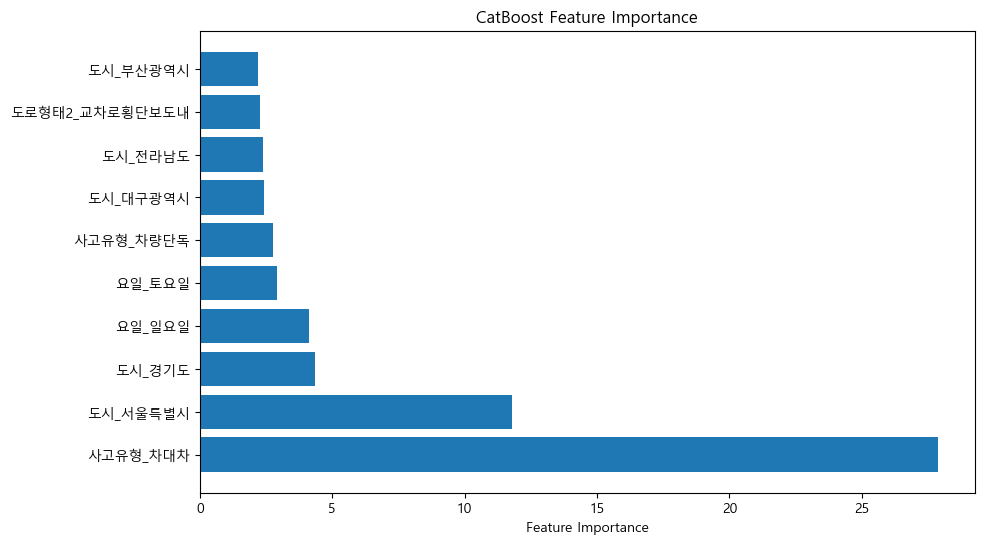

In [42]:
import matplotlib.pyplot as plt

# CatBoost 모델의 feature importance 시각화
feature_importance = model_cbr.get_feature_importance()
feature_names = X_train.columns

# 중요도를 기준으로 내림차순 정렬
sorted_idx = feature_importance.argsort()[::-1]

# 상위 10개의 피처와 중요도 시각화
top_features = 10
plt.figure(figsize=(10, 6))
plt.barh(range(top_features), feature_importance[sorted_idx][:top_features], align="center")
plt.yticks(range(top_features), feature_names[sorted_idx][:top_features])
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance")
plt.show()


In [44]:
X_train = train_enco
y_train = np.log2(eclo)
# 상위 3개의 피처 선택
top_features = 3
selected_features = feature_names[sorted_idx][:top_features]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 선택한 피처에 가중치 부여
weights = [30, 1, 1]  # 가중치는 상황에 따라 조절
weighted_features = {feature: weight for feature, weight in zip(selected_features, weights)}

# 선택한 피처에 가중치를 부여하여 새로운 가중 평균 피처 생성
X_train_weighted = X_train.copy()
for feature, weight in weighted_features.items():
    X_train_weighted[feature] = X_train[feature] * weight

# 가중 평균 피처를 사용하여 새로운 모델 학습
model_weighted = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.05)
model_weighted.fit(X_train_weighted, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=50, verbose=100)


# 테스트 데이터 예측
predictions_weighted = model_weighted.predict(X_valid)

# 로그 역변환 후 RMSLE 계산
predicted_eclo_back_weighted = np.exp2(predictions_weighted)
rmsle_value_back_weighted = rmsle(y_true_back, predicted_eclo_back_weighted)
print("로그역변환 후 최종 RMSLE (가중치 적용):", rmsle_value_back_weighted)


0:	learn: 0.8138172	test: 0.8136744	best: 0.8136744 (0)	total: 43.7ms	remaining: 43.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8133609046
bestIteration = 3

Shrink model to first 4 iterations.
로그역변환 후 최종 RMSLE (가중치 적용): 0.4512599335182627


In [81]:
predicted_eclo_back_weighted

array([4.02888535, 4.07120969, 4.09771696, ..., 4.02839697, 4.1068212 ,
       4.11143086])